In [1]:
import sqlite3
# import os.path
import hashlib
import pandas as pd
import numpy as np

name = "disaggregator_results_pie"
name = "Matthijs"

db = './../data/daf06fb3ab69f27bd681a63311722181.db'
#db = './test.db'
#db = './../data/Matthijs/1cb93dd0babab36e9e5efe90a47d7824.db'

db = './../data/Arne/disaggregation.db'

conn = sqlite3.connect(db)

df = pd.read_sql_query("SELECT date,demand_power_L1+demand_power_L2+demand_power_L3 as 'demand' FROM loads WHERE date > '2018-03-01';", conn)
conn.close()# close db

df['datetime'] = pd.to_datetime(df['date'])
df.sort_values(by='datetime',ascending=True);


In [2]:
df['dp'] = df['demand'] - df['demand'].shift(1)
df['dp-'] = [0-x if x <=0 else 0 for x in df['dp']]
df['dp+'] = [x if x >=0 else 0 for x in df['dp']]



In [3]:
#do the same again! this is much slower?
df['dp'] = df['demand'] - df['demand'].shift(1)
for x in range(1,len(df)):
    df.loc[x,'dp'] = df.loc[x,'demand'] -  df.loc[x-1,'demand']
    if df.loc[x,'dp'] > 0:
        df.loc[x,'dp+'] = df.loc[x,'dp']
        df.loc[x,'dp-'] = 0
    else:
        df.loc[x,'dp-'] = 0-df.loc[x,'dp']
        df.loc[x,'dp+'] = 0



In [4]:
print(df)

                       date  demand            datetime    dp   dp-  dp+
0       2018-03-13 14:35:47   129.0 2018-03-13 14:35:47   NaN   0.0  0.0
1       2018-03-13 14:35:57   128.0 2018-03-13 14:35:57  -1.0   1.0  0.0
2       2018-03-13 14:36:07   127.0 2018-03-13 14:36:07  -1.0   1.0  0.0
3       2018-03-13 14:36:20   127.0 2018-03-13 14:36:20   0.0   0.0  0.0
4       2018-03-13 14:36:26   126.0 2018-03-13 14:36:26  -1.0   1.0  0.0
5       2018-03-13 14:36:36   126.0 2018-03-13 14:36:36   0.0   0.0  0.0
6       2018-03-13 14:36:46   126.0 2018-03-13 14:36:46   0.0   0.0  0.0
7       2018-03-13 14:36:56   126.0 2018-03-13 14:36:56   0.0   0.0  0.0
8       2018-03-13 14:37:06   125.0 2018-03-13 14:37:06  -1.0   1.0  0.0
9       2018-03-13 14:37:16   125.0 2018-03-13 14:37:16   0.0   0.0  0.0
10      2018-03-13 14:37:26   124.0 2018-03-13 14:37:26  -1.0   1.0  0.0
11      2018-03-13 14:37:35   124.0 2018-03-13 14:37:35   0.0   0.0  0.0
12      2018-03-13 14:37:45   123.0 2018-03-13 14:3

In [5]:
# add user defined loads (that are always on)
user_loads = {'modem':10,'rPi':4}
baseload = 0
for user_load in user_loads:
    df.loc[:,user_load]  = user_loads[user_load]
    baseload = baseload + user_loads[user_load]
#     df.loc[:,] = np.array([df['demand'].min()] * len(df))


In [6]:
# find baseload and determine remaining unkwown profile
df.loc[:,'baseload'] = np.array([df['demand'].min()-baseload] * len(df)) #sets baseload colum to min value minus users defined loads
df.loc[:,'unknown'] = df.loc[:,'demand'] - df.loc[:,'baseload']-baseload #calculate remaining load = demand - baseload(s)


In [7]:
#function left_round round number left of the decimal point. (NEEDS A FIX)
def left_round(number,precision=2):
    rem = number

    d = len(str(number))
    while(round(rem,d) == round(number,d)):
        rem = round(number,d-precision)
        d = d -1
        
    i = 0
    while(rem > 10**precision):
        rem = round(rem / 10,0)
        i = i +1
#         print(rem*(10**i))
        if i > 100:
            break
    return rem*(10**i)

left_round(00.00034564,3)

left_round(122431234.00034564,3)

# left_round(123456)

122000000.0

# find square loads and save them to a dict

In [8]:
# create a dict to safe found devices/loads
loads = dict()

for x in range(1,len(df)):
    #filter for dP+ with minimim power
    if df.loc[x,'dp+'] > 10:
        print(' ') #new line in output
        print ('start dp>100:',df.loc[x,'datetime'],'start P:',df.loc[x-1,'unknown'],', dP+:' ,df.loc[x,'dp+'])
        
        #look forwar in time to see how long load remains on
        for y in range(x+1,len(df)):
            #find dP- of same/simulair size 
            if df.loc[y,'dp-'] > 0.9 *df.loc[x,'dp+'] and df.loc[y,'dp-'] < 1.1 *df.loc[x,'dp+']:
                print ('stop dP-:',df.loc[y,'datetime'],'dP-:' ,df.loc[y,'dp-'])
                break
            # check if load does not drop below start power (this means is must have been turned of or other loads were already present (=ON))    
            if df.loc[y,'unknown'] <= df.loc[x-1,'unknown']:
                print ('stop demand:',df.loc[x,'datetime'] ,df.loc[y,'unknown'], ' <= ',df.loc[x-1,'unknown'])
                break
            # check for 50% load reduction
            if df.loc[y,'unknown']<df.loc[x-1,'unknown']+0.5*df.loc[x,'dp+']:
                print ('stop 50% load reduction:',df.loc[x,'datetime'] ,df.loc[y,'unknown'], ' < ',df.loc[x-1,'unknown'],'+',0.5*df.loc[x,'dp+'])
                break
            
        
        print(x,y,(df.loc[x:y-1,'unknown']-df.loc[x-1,'unknown']).mean())
        
        # calculate key parameters
        mean = (df.loc[x:y-1,'unknown']-df.loc[x-1,'unknown']).mean()
        max = (df.loc[x:y-1,'unknown']-df.loc[x-1,'unknown']).max()
        min = (df.loc[x:y-1,'unknown']-df.loc[x-1,'unknown']).min()
        std = (df.loc[x:y-1,'unknown']-df.loc[x-1,'unknown']).std()
        time = pd.Timedelta(pd.to_datetime(df['datetime'][y])-pd.to_datetime(df['datetime'][x]))
        noise = df.loc[x+1:y-1,'dp'].abs().mean()
        
        print('mean load:',mean)
        print('max load:',max)
        print('std load:',std)
        print('noise:',noise)
        print('time past:',time)


        print('found profile from ',df.loc[x-1,'datetime'],'to',df.loc[y,'datetime'])
        profile = list(df.loc[x-1:y,'unknown']-df.loc[x-1,'unknown'])
        print(profile)
        
        
#         plt.plot(range(x,y),profile)
#         plt.title('A simple chirp')
#         plt.show()
#         break
        try:
            #drop loads which do not have a square looking profile.
            if (std/mean > 0.15):
                print('dropped because of large std:',std/mean)
                continue

            #drop loads which do not have odd start compared to mean
            if( abs(mean-df.loc[x,'dp+'])/df.loc[x,'dp+'] > 0.2):    
                print('dropped because large difference between mean and start dp+:',abs(mean-df.loc[x,'dp+'])/df.loc[x,'dp+'])
                continue
        except:
            print('Something went wrong in analysing found load, dropping ....')
            continue
#         print('hist:',df.hist(bins=10))
        
        # save this load to the distionairy (group by 'fingerprint')
        fingerprint = str(int(round(mean,-2)))+'_'#+str(int(left_round(df.loc[x,'dp+'],2)))
        temp = {'index':{'start':x,'stop':y},'time':time,'mean':mean,'max':max,'profile':profile}
        try:
            loads[fingerprint][len(loads[fingerprint])] = temp
        except:
            loads[fingerprint] = {0:temp}
            df[fingerprint] = 0 #add new colum to the dataframe before inserting found loads (only on first occurance!)
        
        df.loc[x:y-1,fingerprint] = profile[1:-1]
        df.loc[x:y-1,'unknown'] = df.loc[x:y-1,'unknown'] - profile[1:-1]
        print('Saved with fingerprint:',fingerprint)



 
start dp>100: 2018-03-13 15:15:17 start P: 19.0 , dP+: 93.0
stop 50% load reduction: 2018-03-13 15:15:17 21.0  <  19.0 + 46.5
241 259 86.61111111111111
mean load: 86.61111111111111
max load: 97.0
std load: 10.814689840206665
noise: 2.0588235294117645
time past: 0 days 02:00:18
found profile from  2018-03-13 15:15:07 to 2018-03-13 17:15:35
[0.0, 93.0, 96.0, 97.0, 97.0, 96.0, 96.0, 94.0, 92.0, 90.0, 90.0, 91.0, 91.0, 84.0, 70.0, 70.0, 71.0, 71.0, 70.0, 2.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-13 17:20:41 start P: 37.0 , dP+: 113.0
stop 50% load reduction: 2018-03-13 17:20:41 92.0  <  37.0 + 56.5
290 436 547.7083333333334
mean load: 547.7083333333334
max load: 4000.0
std load: 1198.1923674021214
noise: 57.25352112676056
time past: 0 days 00:30:36
found profile from  2018-03-13 17:20:31 to 2018-03-13 17:51:17
[0.0, 113.0, 109.0, 112.0, 113.0, 114.0, 115.0, 115.0, 115.0, 89.0, 90.0, 90.0, 91.0, 91.0, 91.0, 93.0, 93.0, 93.0, 93.0, 95.0, 95.0, 95.0, 95.0, 95.0, 94.0, 87.0, 

[0.0, 93.0, 81.0, 85.0, 85.0, 84.0, 86.0, 86.0, 86.0, 87.0, 86.0, -72.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-13 18:26:11 start P: 192.0 , dP+: 2018.0
stop dP-: 2018-03-13 18:30:08 dP-: 2000.0
648 672 1954.9166666666667
mean load: 1954.9166666666667
max load: 2018.0
std load: 43.74721523228319
noise: 9.521739130434783
time past: 0 days 00:03:57
found profile from  2018-03-13 18:26:01 to 2018-03-13 18:30:08
[0.0, 2018.0, 2001.0, 1999.0, 2005.0, 2012.0, 2004.0, 2003.0, 1979.0, 1976.0, 1965.0, 1982.0, 1978.0, 1983.0, 1915.0, 1917.0, 1915.0, 1911.0, 1906.0, 1908.0, 1900.0, 1900.0, 1913.0, 1917.0, 1911.0, -89.0]
Saved with fingerprint: 2000_
 
start dp>100: 2018-03-13 18:27:49 start P: 192.0 , dP+: 17.0
stop demand: 2018-03-13 18:27:49 192.0  <=  192.0
658 659 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-13 18:27:39 to 2018-03-13 18:27:59
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping

start dp>100: 2018-03-13 19:52:25 start P: 116.0 , dP+: 88.0
stop demand: 2018-03-13 19:52:25 115.0  <=  116.0
1172 1228 132.875
mean load: 132.875
max load: 1042.0
std load: 131.72561875490902
noise: 35.30909090909091
time past: 0 days 00:09:13
found profile from  2018-03-13 19:52:15 to 2018-03-13 20:01:38
[0.0, 88.0, 84.0, 87.0, 88.0, 88.0, 88.0, 88.0, 88.0, 89.0, 90.0, 91.0, 90.0, 91.0, 92.0, 93.0, 1042.0, 187.0, 192.0, 192.0, 191.0, 190.0, 189.0, 187.0, 186.0, 186.0, 185.0, 184.0, 184.0, 179.0, 170.0, 154.0, 153.0, 153.0, 153.0, 153.0, 83.0, 83.0, 83.0, 82.0, 82.0, 81.0, 82.0, 82.0, 81.0, 81.0, 81.0, 81.0, 81.0, 81.0, 80.0, 80.0, 79.0, 78.0, 79.0, 78.0, 78.0, -1.0]
dropped because of large std: 0.9913499059635674
 
start dp>100: 2018-03-13 19:54:53 start P: 209.0 , dP+: 949.0
stop dP-: 2018-03-13 19:55:03 dP-: 855.0
1187 1188 949.0
mean load: 949.0
max load: 949.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-13 19:54:43 to 2018-03-13 19:55:03
[0.0

found profile from  2018-03-13 23:04:08 to 2018-03-13 23:21:45
[0.0, 30.0, 67.0, 68.0, 67.0, 67.0, 67.0, 67.0, 67.0, 90.0, 98.0, 94.0, 86.0, 86.0, 86.0, 84.0, 84.0, 84.0, 85.0, 84.0, 84.0, 84.0, 84.0, 85.0, 85.0, 84.0, 85.0, 85.0, 84.0, 85.0, 84.0, 85.0, 85.0, 84.0, 85.0, 84.0, 84.0, 85.0, 85.0, 85.0, 84.0, 84.0, 84.0, 85.0, 85.0, 84.0, 85.0, 85.0, 85.0, 85.0, 84.0, 85.0, 85.0, 84.0, 85.0, 85.0, 85.0, 85.0, 84.0, 84.0, 84.0, 84.0, 84.0, 84.0, 84.0, 84.0, 84.0, 84.0, 84.0, 84.0, 84.0, 85.0, 85.0, 85.0, 84.0, 84.0, 85.0, 84.0, 85.0, 84.0, 84.0, 84.0, 78.0, 67.0, 67.0, 67.0, 67.0, 66.0, 67.0, 66.0, 67.0, 66.0, 66.0, 67.0, 67.0, 67.0, 67.0, 66.0, 67.0, 66.0, 67.0, 68.0, 67.0, 67.0, 67.0, 67.0, 66.0, -58.0]
dropped because large difference between mean and start dp+: 1.63427672956
 
start dp>100: 2018-03-13 23:04:28 start P: 115.0 , dP+: 37.0
stop demand: 2018-03-13 23:04:28 27.0  <=  115.0
2339 2444 49.49523809523809
mean load: 49.49523809523809
max load: 68.0
std load: 8.444529191143411
n

 
start dp>100: 2018-03-14 05:34:21 start P: 15.0 , dP+: 97.0
stop demand: 2018-03-14 05:34:21 15.0  <=  15.0
4708 4750 84.95238095238095
mean load: 84.95238095238095
max load: 97.0
std load: 5.591598143872211
noise: 0.5853658536585366
time past: 0 days 00:06:54
found profile from  2018-03-14 05:34:11 to 2018-03-14 05:41:15
[0.0, 97.0, 96.0, 96.0, 96.0, 96.0, 94.0, 93.0, 91.0, 89.0, 89.0, 87.0, 86.0, 86.0, 86.0, 85.0, 86.0, 85.0, 84.0, 84.0, 84.0, 83.0, 84.0, 83.0, 82.0, 82.0, 82.0, 82.0, 81.0, 81.0, 81.0, 81.0, 80.0, 80.0, 81.0, 80.0, 80.0, 80.0, 79.0, 79.0, 79.0, 79.0, 79.0, 0.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-14 05:53:26 start P: 19.0 , dP+: 97.0
stop 50% load reduction: 2018-03-14 05:53:26 55.0  <  19.0 + 48.5
4824 5036 518.6320754716982
mean load: 518.6320754716982
max load: 2223.0
std load: 849.2631746516325
noise: 21.38862559241706
time past: 0 days 00:34:54
found profile from  2018-03-14 05:53:16 to 2018-03-14 06:28:20
[0.0, 97.0, 87.0, 88.0, 88.0, 88.0, 8

start dp>100: 2018-03-14 08:58:45 start P: 14.0 , dP+: 91.0
stop demand: 2018-03-14 08:58:45 14.0  <=  14.0
5950 5990 85.05
mean load: 85.05
max load: 97.0
std load: 5.922360929085543
noise: 0.6923076923076923
time past: 0 days 00:06:35
found profile from  2018-03-14 08:58:35 to 2018-03-14 09:05:20
[0.0, 91.0, 96.0, 97.0, 97.0, 96.0, 95.0, 93.0, 91.0, 91.0, 89.0, 88.0, 89.0, 87.0, 87.0, 86.0, 86.0, 86.0, 84.0, 84.0, 84.0, 83.0, 83.0, 83.0, 83.0, 82.0, 81.0, 81.0, 81.0, 80.0, 80.0, 80.0, 79.0, 79.0, 79.0, 79.0, 79.0, 79.0, 78.0, 78.0, 78.0, 0.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-14 09:32:59 start P: 15.0 , dP+: 2050.0
stop dP-: 2018-03-14 09:52:34 dP-: 2015.0
6158 6277 3833.9915966386557
mean load: 3833.9915966386557
max load: 6037.0
std load: 1698.432275613026
noise: 76.3135593220339
time past: 0 days 00:19:35
found profile from  2018-03-14 09:32:49 to 2018-03-14 09:52:34
[0.0, 2050.0, 2040.0, 2036.0, 2044.0, 2041.0, 2048.0, 2067.0, 2049.0, 2058.0, 2049.0, 2221.0, 21

start dp>100: 2018-03-14 09:53:14 start P: 30.0 , dP+: 56.0
stop dP-: 2018-03-14 10:27:18 dP-: 54.0
6281 6488 921.7004830917874
mean load: 921.7004830917874
max load: 3971.0
std load: 900.4524090267598
noise: 80.10679611650485
time past: 0 days 00:34:04
found profile from  2018-03-14 09:53:04 to 2018-03-14 10:27:18
[0.0, 56.0, 63.0, 72.0, 71.0, 74.0, 63.0, 62.0, 62.0, 62.0, 64.0, 68.0, 66.0, 65.0, 64.0, 64.0, 82.0, 69.0, 70.0, 68.0, 68.0, 68.0, 2115.0, 2109.0, 2106.0, 2107.0, 2106.0, 2108.0, 2106.0, 2109.0, 2106.0, 2101.0, 2097.0, 2112.0, 2116.0, 2116.0, 2108.0, 2092.0, 2082.0, 2093.0, 2084.0, 2099.0, 2100.0, 2096.0, 2096.0, 2096.0, 2101.0, 2100.0, 2110.0, 2102.0, 2098.0, 3971.0, 3933.0, 2087.0, 63.0, 63.0, 63.0, 62.0, 63.0, 62.0, 65.0, 58.0, 58.0, 57.0, 58.0, 58.0, 70.0, 64.0, 63.0, 63.0, 63.0, 63.0, 64.0, 72.0, 58.0, 58.0, 59.0, 59.0, 58.0, 68.0, 64.0, 64.0, 63.0, 63.0, 63.0, 62.0, 58.0, 58.0, 58.0, 58.0, 57.0, 57.0, 64.0, 64.0, 63.0, 63.0, 67.0, 63.0, 77.0, 58.0, 58.0, 58.0, 59.0, 5

std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-14 10:28:27 to 2018-03-14 10:28:47
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-14 10:28:57 start P: 69.0 , dP+: 30.0
stop demand: 2018-03-14 10:28:57 69.0  <=  69.0
6498 6499 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:09
found profile from  2018-03-14 10:28:47 to 2018-03-14 10:29:06
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-14 10:30:06 start P: 105.0 , dP+: 11.0
stop demand: 2018-03-14 10:30:06 95.0  <=  105.0
6505 6506 11.0
mean load: 11.0
max load: 11.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-14 10:29:56 to 2018-03-14 10:30:16
[0.0, 11.0, -10.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03-14 10:31:05 start P: 84.0 , dP+: 2066.0
stop dP-: 2018-03-14 10:32:24 dP-: 2050.0
6511 6519 2056.375
mean load: 2056.375
m

 
start dp>100: 2018-03-14 10:47:42 start P: 2281.0 , dP+: 16.0
stop demand: 2018-03-14 10:47:42 2281.0  <=  2281.0
6612 6615 62.333333333333336
mean load: 62.333333333333336
max load: 89.0
std load: 40.27819923151149
noise: 40.0
time past: 0 days 00:00:30
found profile from  2018-03-14 10:47:32 to 2018-03-14 10:48:12
[0.0, 16.0, 89.0, 82.0, 0.0]
dropped because of large std: 0.6461743192221095
 
start dp>100: 2018-03-14 10:47:52 start P: 2297.0 , dP+: 73.0
stop demand: 2018-03-14 10:47:52 2281.0  <=  2297.0
6613 6615 69.5
mean load: 69.5
max load: 73.0
std load: 4.949747468305833
noise: 7.0
time past: 0 days 00:00:20
found profile from  2018-03-14 10:47:42 to 2018-03-14 10:48:12
[0.0, 73.0, 66.0, -16.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-14 10:48:22 start P: 2281.0 , dP+: 176.0
stop 50% load reduction: 2018-03-14 10:48:22 2285.0  <  2281.0 + 88.0
6616 6618 994.5
mean load: 994.5
max load: 1813.0
std load: 1157.5338008023782
noise: 1637.0
time past: 0 days 00:00:20
fo

stop demand: 2018-03-14 11:01:52 1980.0  <=  2087.0
6698 6699 163.0
mean load: 163.0
max load: 163.0
std load: nan
noise: nan
time past: 0 days 00:00:09
found profile from  2018-03-14 11:01:42 to 2018-03-14 11:02:01
[0.0, 163.0, -107.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-14 11:02:41 start P: 1982.0 , dP+: 174.0
stop 50% load reduction: 2018-03-14 11:02:41 2004.0  <  1982.0 + 87.0
6703 6704 174.0
mean load: 174.0
max load: 174.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-14 11:02:32 to 2018-03-14 11:02:51
[0.0, 174.0, 22.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-14 11:03:30 start P: 1967.0 , dP+: 233.0
stop dP-: 2018-03-14 11:03:50 dP-: 214.0
6708 6710 223.5
mean load: 223.5
max load: 233.0
std load: 13.435028842544403
noise: 19.0
time past: 0 days 00:00:20
found profile from  2018-03-14 11:03:20 to 2018-03-14 11:03:50
[0.0, 233.0, 214.0, 0.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-14 11:04:29 start P: 19

time past: 0 days 00:01:59
found profile from  2018-03-14 11:16:50 to 2018-03-14 11:18:59
[0.0, 0.0, 194.0, 184.0, 271.0, 189.0, 195.0, 155.0, 187.0, 173.0, 285.0, 195.0, 209.0, 22.0]
dropped because of large std: 0.37417311226836225
 
start dp>100: 2018-03-14 11:17:30 start P: 340.0 , dP+: 87.0
stop dP-: 2018-03-14 11:17:39 dP-: 82.0
6793 6794 87.0
mean load: 87.0
max load: 87.0
std load: nan
noise: nan
time past: 0 days 00:00:09
found profile from  2018-03-14 11:17:20 to 2018-03-14 11:17:39
[0.0, 87.0, 5.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-14 11:18:09 start P: 311.0 , dP+: 32.0
stop demand: 2018-03-14 11:18:09 178.0  <=  311.0
6797 6802 54.8
mean load: 54.8
max load: 130.0
std load: 44.013634251218114
noise: 57.5
time past: 0 days 00:00:50
found profile from  2018-03-14 11:17:59 to 2018-03-14 11:18:59
[0.0, 32.0, 18.0, 130.0, 40.0, 54.0, -133.0]
dropped because of large std: 0.8031685082339073
 
start dp>100: 2018-03-14 11:18:29 start P: 329.0 , dP+: 112.0
stop 50

start dp>100: 2018-03-14 11:33:37 start P: 174.0 , dP+: 46.0
stop dP-: 2018-03-14 11:35:17 dP-: 43.0
6891 6901 282.6
mean load: 282.6
max load: 2150.0
std load: 666.7186979695576
noise: 319.1111111111111
time past: 0 days 00:01:40
found profile from  2018-03-14 11:33:27 to 2018-03-14 11:35:17
[0.0, 46.0, 32.0, 27.0, 29.0, 28.0, 30.0, 26.0, 409.0, 49.0, 2150.0, 2107.0]
dropped because of large std: 2.3592310614634027
 
start dp>100: 2018-03-14 11:34:46 start P: 200.0 , dP+: 383.0
stop dP-: 2018-03-14 11:34:56 dP-: 360.0
6898 6899 383.0
mean load: 383.0
max load: 383.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-14 11:34:37 to 2018-03-14 11:34:56
[0.0, 383.0, 23.0]
Saved with fingerprint: 400_
 
start dp>100: 2018-03-14 11:35:06 start P: 223.0 , dP+: 2101.0
stop dP-: 2018-03-14 11:38:14 dP-: 1946.0
6900 6919 2085.157894736842
mean load: 2085.157894736842
max load: 2194.0
std load: 60.19621911151595
noise: 33.166666666666664
time past: 0 days 00:03:08
f

found profile from  2018-03-14 11:52:23 to 2018-03-14 11:52:53
[0.0, 72.0, 76.0, -1.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-14 11:53:22 start P: 37.0 , dP+: 2121.0
stop dP-: 2018-03-14 11:55:34 dP-: 2067.0
7011 7024 2086.5384615384614
mean load: 2086.5384615384614
max load: 2154.0
std load: 25.164841163202887
noise: 12.166666666666666
time past: 0 days 00:02:12
found profile from  2018-03-14 11:53:12 to 2018-03-14 11:55:34
[0.0, 2121.0, 2154.0, 2091.0, 2082.0, 2085.0, 2083.0, 2078.0, 2082.0, 2081.0, 2074.0, 2072.0, 2059.0, 2063.0, -4.0]
Saved with fingerprint: 2100_
 
start dp>100: 2018-03-14 11:53:32 start P: 37.0 , dP+: 33.0
stop demand: 2018-03-14 11:53:32 37.0  <=  37.0
7012 7013 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-14 11:53:22 to 2018-03-14 11:53:42
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-14 11:56:50 start P: 34.0 , dP+: 2113.0
sto

Saved with fingerprint: 100_
 
start dp>100: 2018-03-14 12:29:44 start P: 181.0 , dP+: 302.0
stop 50% load reduction: 2018-03-14 12:29:44 296.0  <  181.0 + 151.0
7232 7235 283.0
mean load: 283.0
max load: 332.0
std load: 60.77005841695399
noise: 73.5
time past: 0 days 00:00:30
found profile from  2018-03-14 12:29:35 to 2018-03-14 12:30:14
[0.0, 302.0, 332.0, 215.0, 115.0]
dropped because of large std: 0.2147351887524876
 
start dp>100: 2018-03-14 12:29:54 start P: 483.0 , dP+: 30.0
stop demand: 2018-03-14 12:29:54 396.0  <=  483.0
7233 7234 30.0
mean load: 30.0
max load: 30.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-14 12:29:44 to 2018-03-14 12:30:04
[0.0, 30.0, -87.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03-14 12:30:24 start P: 296.0 , dP+: 41.0
stop demand: 2018-03-14 12:30:24 127.0  <=  296.0
7236 7246 128.3
mean load: 128.3
max load: 190.0
std load: 44.882686590216004
noise: 24.88888888888889
time past: 0 days 00:01:39
found profile

7332 7333 29.0
mean load: 29.0
max load: 29.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-14 12:46:02 to 2018-03-14 12:46:22
[0.0, 29.0, 8.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03-14 12:46:32 start P: 38.0 , dP+: 108.0
stop dP-: 2018-03-14 12:46:41 dP-: 117.0
7334 7335 108.0
mean load: 108.0
max load: 108.0
std load: nan
noise: nan
time past: 0 days 00:00:09
found profile from  2018-03-14 12:46:22 to 2018-03-14 12:46:41
[0.0, 108.0, -9.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-14 12:47:11 start P: 28.0 , dP+: 75.0
stop 50% load reduction: 2018-03-14 12:47:11 44.0  <  28.0 + 37.5
7338 7351 261.61538461538464
mean load: 261.61538461538464
max load: 396.0
std load: 115.22553135882289
noise: 33.833333333333336
time past: 0 days 00:02:08
found profile from  2018-03-14 12:47:01 to 2018-03-14 12:49:19
[0.0, 75.0, 89.0, 189.0, 179.0, 168.0, 220.0, 269.0, 325.0, 396.0, 393.0, 365.0, 370.0, 363.0, 16.0]
dropped because of large std: 

start dp>100: 2018-03-14 16:10:06 start P: 25.0 , dP+: 95.0
stop demand: 2018-03-14 16:10:06 24.0  <=  25.0
8571 8612 117.34146341463415
mean load: 117.34146341463415
max load: 188.0
std load: 40.12331601207554
noise: 5.9
time past: 0 days 00:06:45
found profile from  2018-03-14 16:09:57 to 2018-03-14 16:16:51
[0.0, 95.0, 97.0, 97.0, 96.0, 96.0, 94.0, 93.0, 91.0, 89.0, 88.0, 87.0, 87.0, 87.0, 86.0, 188.0, 171.0, 173.0, 173.0, 173.0, 173.0, 172.0, 173.0, 172.0, 169.0, 163.0, 150.0, 150.0, 150.0, 150.0, 150.0, 81.0, 80.0, 81.0, 80.0, 80.0, 80.0, 80.0, 79.0, 80.0, 78.0, 79.0, -1.0]
dropped because of large std: 0.34193638671691895
 
start dp>100: 2018-03-14 16:12:25 start P: 111.0 , dP+: 102.0
stop demand: 2018-03-14 16:12:25 106.0  <=  111.0
8585 8601 79.625
mean load: 79.625
max load: 102.0
std load: 11.89327541092024
noise: 2.933333333333333
time past: 0 days 00:02:38
found profile from  2018-03-14 16:12:15 to 2018-03-14 16:15:03
[0.0, 102.0, 85.0, 87.0, 87.0, 87.0, 87.0, 86.0, 87.0, 8

mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-14 17:52:09 to 2018-03-14 17:52:28
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-14 17:52:48 start P: 590.0 , dP+: 73.0
stop demand: 2018-03-14 17:52:48 590.0  <=  590.0
9195 9196 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-14 17:52:38 to 2018-03-14 17:52:58
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-14 17:53:37 start P: 590.0 , dP+: 14.0
stop demand: 2018-03-14 17:53:37 590.0  <=  590.0
9200 9201 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-14 17:53:28 to 2018-03-14 17:53:47
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-14 17:54:56 start P: 590.0 , dP+: 419.0
stop demand: 2018-03-1

start dp>100: 2018-03-14 18:41:01 start P: 54.0 , dP+: 97.0
stop 50% load reduction: 2018-03-14 18:41:01 102.0  <  54.0 + 48.5
9488 9529 204.7560975609756
mean load: 204.7560975609756
max load: 559.0
std load: 174.97382382628052
noise: 44.9
time past: 0 days 00:06:45
found profile from  2018-03-14 18:40:51 to 2018-03-14 18:47:46
[0.0, 97.0, 85.0, 85.0, 86.0, 86.0, 86.0, 554.0, 553.0, 552.0, 552.0, 124.0, 124.0, 125.0, 126.0, 125.0, 126.0, 127.0, 127.0, 127.0, 128.0, 129.0, 129.0, 128.0, 129.0, 129.0, 125.0, 124.0, 125.0, 129.0, 129.0, 129.0, 129.0, 129.0, 129.0, 559.0, 558.0, 555.0, 554.0, 128.0, 129.0, 125.0, 48.0]
dropped because of large std: 0.8545475612718882
 
start dp>100: 2018-03-14 18:42:01 start P: 140.0 , dP+: 468.0
stop dP-: 2018-03-14 18:42:40 dP-: 428.0
9494 9498 466.75
mean load: 466.75
max load: 468.0
std load: 0.9574271077563381
noise: 0.6666666666666666
time past: 0 days 00:00:39
found profile from  2018-03-14 18:41:51 to 2018-03-14 18:42:40
[0.0, 468.0, 467.0, 466.0,

mean load: 61.45454545454545
max load: 66.0
std load: 6.976584212401315
noise: 2.5
time past: 0 days 00:01:48
found profile from  2018-03-14 20:34:35 to 2018-03-14 20:36:33
[0.0, 63.0, 64.0, 65.0, 64.0, 65.0, 65.0, 66.0, 66.0, 63.0, 47.0, 48.0, -7.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-14 20:37:13 start P: 179.0 , dP+: 51.0
stop dP-: 2018-03-14 20:42:49 dP-: 51.0
10194 10228 49.85294117647059
mean load: 49.85294117647059
max load: 51.0
std load: 0.6096373955153139
noise: 0.48484848484848486
time past: 0 days 00:05:36
found profile from  2018-03-14 20:37:03 to 2018-03-14 20:42:49
[0.0, 51.0, 51.0, 50.0, 49.0, 49.0, 50.0, 50.0, 49.0, 50.0, 50.0, 50.0, 50.0, 50.0, 49.0, 50.0, 49.0, 50.0, 51.0, 49.0, 49.0, 49.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 50.0, 49.0, 50.0, 50.0, 51.0, 0.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03-14 20:43:18 start P: 118.0 , dP+: 93.0
stop demand: 2018-03-14 20:43:18 110.0  <=  118.0
10231 10255 78.04166666666667
mean load: 7

mean load: 84.81818181818181
max load: 97.0
std load: 5.583500307791123
noise: 1.0
time past: 0 days 00:07:15
found profile from  2018-03-15 02:28:15 to 2018-03-15 02:35:40
[0.0, 94.0, 97.0, 97.0, 97.0, 97.0, 95.0, 92.0, 91.0, 90.0, 88.0, 86.0, 86.0, 85.0, 86.0, 85.0, 84.0, 84.0, 84.0, 87.0, 83.0, 84.0, 83.0, 83.0, 83.0, 83.0, 83.0, 81.0, 82.0, 82.0, 82.0, 81.0, 81.0, 80.0, 81.0, 80.0, 80.0, 82.0, 80.0, 80.0, 78.0, 79.0, 79.0, 78.0, 79.0, 1.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-15 03:17:38 start P: 3.0 , dP+: 94.0
stop 50% load reduction: 2018-03-15 03:17:38 4.0  <  3.0 + 47.0
12627 12671 84.29545454545455
mean load: 84.29545454545455
max load: 97.0
std load: 5.475440071321209
noise: 0.9534883720930233
time past: 0 days 00:07:14
found profile from  2018-03-15 03:17:28 to 2018-03-15 03:24:52
[0.0, 94.0, 96.0, 97.0, 96.0, 95.0, 95.0, 93.0, 89.0, 89.0, 88.0, 86.0, 86.0, 85.0, 84.0, 85.0, 84.0, 84.0, 84.0, 83.0, 83.0, 82.0, 83.0, 83.0, 81.0, 82.0, 82.0, 81.0, 81.0, 82.0, 

Saved with fingerprint: 900_
 
start dp>100: 2018-03-15 08:04:29 start P: 150.0 , dP+: 886.0
stop dP-: 2018-03-15 08:04:49 dP-: 867.0
14370 14372 876.0
mean load: 876.0
max load: 886.0
std load: 14.142135623730951
noise: 20.0
time past: 0 days 00:00:20
found profile from  2018-03-15 08:04:20 to 2018-03-15 08:04:49
[0.0, 886.0, 866.0, -1.0]
Saved with fingerprint: 900_
 
start dp>100: 2018-03-15 08:05:58 start P: 149.0 , dP+: 63.0
stop dP-: 2018-03-15 08:07:27 dP-: 67.0
14379 14388 237.44444444444446
mean load: 237.44444444444446
max load: 1055.0
std load: 312.17547593905863
noise: 227.5
time past: 0 days 00:01:29
found profile from  2018-03-15 08:05:49 to 2018-03-15 08:07:27
[0.0, 63.0, 65.0, 65.0, 165.0, 164.0, 165.0, 164.0, 1055.0, 231.0, 164.0]
dropped because of large std: 1.3147305959061897
 
start dp>100: 2018-03-15 08:06:28 start P: 214.0 , dP+: 100.0
stop 50% load reduction: 2018-03-15 08:06:28 215.0  <  214.0 + 50.0
14382 14402 137.8
mean load: 137.8
max load: 990.0
std load: 

stop dP-: 2018-03-15 14:59:56 dP-: 124.0
15088 16888 256.12944444444446
mean load: 256.12944444444446
max load: 2289.0
std load: 332.6685046487533
noise: 40.594219010561424
time past: 0 days 04:57:17
found profile from  2018-03-15 10:02:29 to 2018-03-15 14:59:56
[0.0, 124.0, 125.0, 125.0, 125.0, 124.0, 124.0, 124.0, 125.0, 124.0, 124.0, 124.0, 123.0, 124.0, 124.0, 123.0, 123.0, 123.0, 123.0, 123.0, 122.0, 123.0, 123.0, 123.0, 123.0, 124.0, 124.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 211.0, 208.0, 211.0, 212.0, 213.0, 213.0, 211.0, 194.0, 194.0, 194.0, 194.0, 194.0, 193.0, 124.0, 125.0, 124.0, 123.0, 123.0, 123.0, 123.0, 124.0, 123.0, 123.0, 123.0, 123.0, 123.0, 122.0, 124.0, 122.0, 123.0, 123.0, 124.0, 123.0, 124.0, 123.0, 123.0, 123.0, 123.0, 123.0, 123.0, 124.0, 124.0, 124.0, 124.0, 125.0, 124.0, 220.0, 221.0, 223.0, 222.0, 223.0, 220.0, 218.0, 216.0, 214.0, 215.0, 213.0, 211.0, 212.0, 212.0, 212.0, 211.0, 211.0, 210.0, 210.0, 209.0, 209.0, 288.0, 293.0, 296.0, 297.0, 298.0, 296

found profile from  2018-03-15 11:07:50 to 2018-03-15 11:09:58
[0.0, 94.0, 84.0, 84.0, 84.0, 84.0, 81.0, 76.0, 63.0, 62.0, 62.0, 63.0, 63.0, -9.0]
dropped because of large std: 0.15528403431496526
 
start dp>100: 2018-03-15 11:18:02 start P: 154.0 , dP+: 93.0
stop demand: 2018-03-15 11:18:02 148.0  <=  154.0
15545 15558 74.61538461538461
mean load: 74.61538461538461
max load: 93.0
std load: 11.558102940783302
noise: 3.1666666666666665
time past: 0 days 00:02:09
found profile from  2018-03-15 11:17:52 to 2018-03-15 11:20:11
[0.0, 93.0, 83.0, 85.0, 83.0, 84.0, 84.0, 80.0, 64.0, 63.0, 63.0, 63.0, 62.0, 63.0, -6.0]
dropped because of large std: 0.15490241054658033
 
start dp>100: 2018-03-15 11:27:44 start P: 148.0 , dP+: 93.0
stop demand: 2018-03-15 11:27:44 143.0  <=  148.0
15604 15619 77.66666666666667
mean load: 77.66666666666667
max load: 93.0
std load: 10.334869317486497
noise: 2.642857142857143
time past: 0 days 00:02:29
found profile from  2018-03-15 11:27:35 to 2018-03-15 11:30:13


time past: 0 days 00:00:10
found profile from  2018-03-15 13:22:00 to 2018-03-15 13:22:20
[0.0, 164.0, -608.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-15 13:23:49 start P: 238.0 , dP+: 857.0
stop dP-: 2018-03-15 13:23:59 dP-: 858.0
16306 16307 857.0
mean load: 857.0
max load: 857.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-15 13:23:39 to 2018-03-15 13:23:59
[0.0, 857.0, -1.0]
Saved with fingerprint: 900_
 
start dp>100: 2018-03-15 13:26:28 start P: 157.0 , dP+: 893.0
stop dP-: 2018-03-15 13:26:48 dP-: 861.0
16322 16324 879.5
mean load: 879.5
max load: 893.0
std load: 19.091883092036785
noise: 27.0
time past: 0 days 00:00:20
found profile from  2018-03-15 13:26:18 to 2018-03-15 13:26:48
[0.0, 893.0, 866.0, 5.0]
Saved with fingerprint: 900_
 
start dp>100: 2018-03-15 13:26:58 start P: 162.0 , dP+: 71.0
stop dP-: 2018-03-15 13:30:35 dP-: 68.0
16325 16347 121.13636363636364
mean load: 121.13636363636364
max load: 963.0
std load: 188.230177

16567 16590 153.08695652173913
mean load: 153.08695652173913
max load: 970.0
std load: 254.83914945483085
noise: 82.81818181818181
time past: 0 days 00:03:48
found profile from  2018-03-15 14:06:45 to 2018-03-15 14:10:43
[0.0, 93.0, 80.0, 83.0, 81.0, 81.0, 81.0, 82.0, 970.0, 950.0, 83.0, 82.0, 82.0, 83.0, 82.0, 83.0, 83.0, 81.0, 63.0, 60.0, 60.0, 60.0, 59.0, 59.0, -11.0]
dropped because of large std: 1.664669252332039
 
start dp>100: 2018-03-15 14:08:04 start P: 335.0 , dP+: 888.0
stop dP-: 2018-03-15 14:08:24 dP-: 867.0
16574 16576 878.0
mean load: 878.0
max load: 888.0
std load: 14.142135623730951
noise: 20.0
time past: 0 days 00:00:20
found profile from  2018-03-15 14:07:55 to 2018-03-15 14:08:24
[0.0, 888.0, 868.0, 1.0]
Saved with fingerprint: 900_
 
start dp>100: 2018-03-15 14:12:02 start P: 239.0 , dP+: 860.0
stop dP-: 2018-03-15 14:12:12 dP-: 861.0
16598 16599 860.0
mean load: 860.0
max load: 860.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-1

std load: 11.08973141501375
noise: 4.285714285714286
time past: 0 days 00:01:20
found profile from  2018-03-15 15:39:33 to 2018-03-15 15:41:03
[0.0, 98.0, 95.0, 76.0, 76.0, 75.0, 74.0, 71.0, 68.0, 0.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-15 15:47:19 start P: 74.0 , dP+: 89.0
stop demand: 2018-03-15 15:47:19 71.0  <=  74.0
17175 17197 79.0909090909091
mean load: 79.0909090909091
max load: 89.0
std load: 8.684463910910875
noise: 2.0
time past: 0 days 00:03:38
found profile from  2018-03-15 15:47:09 to 2018-03-15 15:50:57
[0.0, 89.0, 81.0, 81.0, 82.0, 82.0, 82.0, 82.0, 83.0, 83.0, 83.0, 84.0, 83.0, 84.0, 87.0, 88.0, 88.0, 77.0, 64.0, 64.0, 64.0, 64.0, 65.0, -3.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-15 15:57:23 start P: 73.0 , dP+: 88.0
stop demand: 2018-03-15 15:57:23 69.0  <=  73.0
17236 17258 79.5909090909091
mean load: 79.5909090909091
max load: 88.0
std load: 9.006130668072144
noise: 1.8571428571428572
time past: 0 days 00:03:38
found profile from  20

start dp>100: 2018-03-15 17:47:42 start P: 58.0 , dP+: 90.0
stop demand: 2018-03-15 17:47:42 53.0  <=  58.0
17904 17929 78.92
mean load: 78.92
max load: 90.0
std load: 9.219182899440348
noise: 1.875
time past: 0 days 00:04:08
found profile from  2018-03-15 17:47:32 to 2018-03-15 17:51:50
[0.0, 90.0, 80.0, 81.0, 81.0, 81.0, 82.0, 82.0, 82.0, 82.0, 84.0, 83.0, 83.0, 85.0, 85.0, 86.0, 86.0, 86.0, 87.0, 84.0, 74.0, 62.0, 62.0, 62.0, 62.0, 61.0, -5.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-15 17:57:47 start P: 57.0 , dP+: 88.0
stop demand: 2018-03-15 17:57:47 52.0  <=  57.0
17965 17989 77.83333333333333
mean load: 77.83333333333333
max load: 88.0
std load: 9.32349377818659
noise: 1.9565217391304348
time past: 0 days 00:03:57
found profile from  2018-03-15 17:57:37 to 2018-03-15 18:01:44
[0.0, 88.0, 80.0, 80.0, 81.0, 80.0, 81.0, 81.0, 81.0, 82.0, 83.0, 82.0, 83.0, 83.0, 84.0, 84.0, 85.0, 86.0, 86.0, 74.0, 61.0, 61.0, 61.0, 60.0, 61.0, -5.0]
Saved with fingerprint: 100_
 
start 

18782 18805 1943.695652173913
mean load: 1943.695652173913
max load: 1959.0
std load: 5.676384753830363
noise: 3.0454545454545454
time past: 0 days 00:03:48
found profile from  2018-03-15 20:12:31 to 2018-03-15 20:16:29
[0.0, 1959.0, 1948.0, 1942.0, 1943.0, 1947.0, 1947.0, 1949.0, 1947.0, 1946.0, 1949.0, 1943.0, 1940.0, 1939.0, 1938.0, 1941.0, 1937.0, 1936.0, 1935.0, 1939.0, 1938.0, 1945.0, 1949.0, 1948.0, -6.0]
Saved with fingerprint: 1900_
 
start dp>100: 2018-03-15 20:20:57 start P: 99.0 , dP+: 20.0
stop 50% load reduction: 2018-03-15 20:20:57 104.0  <  99.0 + 10.0
18832 19743 94.22392974753019
mean load: 94.22392974753019
max load: 2131.0
std load: 199.7444860076856
noise: 7.141758241758242
time past: 0 days 02:30:25
found profile from  2018-03-15 20:20:47 to 2018-03-15 22:51:22
[0.0, 20.0, 21.0, 22.0, 22.0, 23.0, 23.0, 23.0, 23.0, 24.0, 22.0, 23.0, 23.0, 14.0, 14.0, 15.0, 15.0, 14.0, 14.0, 14.0, 110.0, 129.0, 124.0, 126.0, 124.0, 121.0, 106.0, 106.0, 104.0, 104.0, 102.0, 102.0, 10

start dp>100: 2018-03-15 22:42:28 start P: 110.0 , dP+: 52.0
stop dP-: 2018-03-15 22:49:04 dP-: 51.0
19689 19729 116.325
mean load: 116.325
max load: 154.0
std load: 38.13497452537869
noise: 4.794871794871795
time past: 0 days 00:06:36
found profile from  2018-03-15 22:42:18 to 2018-03-15 22:49:04
[0.0, 52.0, 52.0, 52.0, 52.0, 52.0, 53.0, 60.0, 53.0, 53.0, 46.0, 141.0, 146.0, 153.0, 152.0, 154.0, 153.0, 150.0, 149.0, 146.0, 146.0, 135.0, 135.0, 135.0, 135.0, 135.0, 134.0, 134.0, 133.0, 126.0, 124.0, 132.0, 131.0, 131.0, 132.0, 131.0, 130.0, 130.0, 130.0, 136.0, 129.0, 78.0]
dropped because of large std: 0.3278312875596706
 
start dp>100: 2018-03-15 22:44:06 start P: 156.0 , dP+: 95.0
stop 50% load reduction: 2018-03-15 22:44:06 188.0  <  156.0 + 47.5
19699 19729 91.6
mean load: 91.6
max load: 108.0
std load: 8.907958471946927
noise: 2.413793103448276
time past: 0 days 00:04:58
found profile from  2018-03-15 22:43:57 to 2018-03-15 22:49:04
[0.0, 95.0, 100.0, 107.0, 106.0, 108.0, 107.0, 

start dp>100: 2018-03-16 06:08:49 start P: 17.0 , dP+: 91.0
stop demand: 2018-03-16 06:08:49 8.0  <=  17.0
22392 22442 124.28
mean load: 124.28
max load: 178.0
std load: 46.725878858530216
noise: 5.714285714285714
time past: 0 days 00:08:16
found profile from  2018-03-16 06:08:39 to 2018-03-16 06:17:05
[0.0, 91.0, 82.0, 84.0, 77.0, 75.0, 76.0, 78.0, 176.0, 173.0, 177.0, 174.0, 173.0, 173.0, 173.0, 170.0, 169.0, 169.0, 177.0, 177.0, 178.0, 167.0, 168.0, 170.0, 169.0, 165.0, 164.0, 167.0, 166.0, 160.0, 151.0, 139.0, 138.0, 138.0, 137.0, 139.0, 72.0, 70.0, 69.0, 72.0, 72.0, 72.0, 70.0, 71.0, 69.0, 70.0, 70.0, 70.0, 69.0, 69.0, 69.0, -9.0]
dropped because of large std: 0.37597263323567925
 
start dp>100: 2018-03-16 06:09:58 start P: 95.0 , dP+: 98.0
stop demand: 2018-03-16 06:09:58 89.0  <=  95.0
22399 22427 86.17857142857143
mean load: 86.17857142857143
max load: 100.0
std load: 13.570265892830411
noise: 2.925925925925926
time past: 0 days 00:04:37
found profile from  2018-03-16 06:09:48 

stop dP-: 2018-03-16 07:59:47 dP-: 128.0
22992 23064 1647.236111111111
mean load: 1647.236111111111
max load: 2692.0
std load: 378.41952623054607
noise: 153.53521126760563
time past: 0 days 00:11:54
found profile from  2018-03-16 07:47:43 to 2018-03-16 07:59:47
[0.0, 127.0, 135.0, 840.0, 1781.0, 1786.0, 1776.0, 1766.0, 1810.0, 1805.0, 1772.0, 165.0, 1797.0, 1797.0, 1803.0, 1653.0, 1721.0, 1878.0, 1879.0, 2692.0, 2523.0, 1684.0, 1834.0, 1796.0, 1841.0, 1689.0, 1702.0, 1837.0, 1843.0, 1860.0, 1624.0, 1617.0, 1799.0, 1804.0, 1810.0, 1606.0, 1602.0, 1798.0, 1765.0, 1752.0, 1516.0, 1515.0, 1711.0, 1761.0, 1716.0, 1615.0, 1527.0, 1640.0, 1686.0, 1669.0, 1641.0, 1668.0, 1693.0, 1633.0, 1623.0, 1701.0, 1695.0, 1702.0, 1556.0, 1527.0, 1653.0, 1662.0, 1655.0, 1506.0, 1522.0, 1672.0, 1714.0, 1662.0, 1502.0, 1485.0, 1677.0, 1677.0, 1650.0, 1522.0]
dropped because of large std: 0.22972998447398688
 
start dp>100: 2018-03-16 07:48:13 start P: 2292.0 , dP+: 705.0
stop 50% load reduction: 2018-03-16 0

time past: 0 days 00:00:10
found profile from  2018-03-16 08:06:33 to 2018-03-16 08:06:53
[0.0, 236.0, 66.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-16 08:07:32 start P: 1708.0 , dP+: 188.0
stop demand: 2018-03-16 08:07:32 1708.0  <=  1708.0
23111 23113 167.0
mean load: 167.0
max load: 188.0
std load: 29.698484809834994
noise: 42.0
time past: 0 days 00:00:20
found profile from  2018-03-16 08:07:23 to 2018-03-16 08:07:52
[0.0, 188.0, 146.0, 0.0]
dropped because of large std: 0.17783523838224546
 
start dp>100: 2018-03-16 08:08:32 start P: 1697.0 , dP+: 175.0
stop dP-: 2018-03-16 08:08:52 dP-: 169.0
23117 23119 174.5
mean load: 174.5
max load: 175.0
std load: 0.7071067811865476
noise: 1.0
time past: 0 days 00:00:20
found profile from  2018-03-16 08:08:22 to 2018-03-16 08:08:52
[0.0, 175.0, 174.0, 5.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-16 08:09:12 start P: 31.0 , dP+: 128.0
stop dP-: 2018-03-16 08:12:00 dP-: 122.0
23121 23138 947.2941176470588
mean load: 94

mean load: 154.0
max load: 161.0
std load: 9.899494936611665
noise: 14.0
time past: 0 days 00:00:20
found profile from  2018-03-16 08:18:06 to 2018-03-16 08:18:36
[0.0, 147.0, 161.0, 57.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-16 08:18:26 start P: 31.0 , dP+: 14.0
stop demand: 2018-03-16 08:18:26 28.0  <=  31.0
23177 23181 82.25
mean load: 82.25
max load: 144.0
std load: 66.6051799787374
noise: 69.0
time past: 0 days 00:00:40
found profile from  2018-03-16 08:18:16 to 2018-03-16 08:19:06
[0.0, 0.0, 57.0, 144.0, 128.0, -3.0]
dropped because of large std: 0.8097894222338893
 
start dp>100: 2018-03-16 08:18:46 start P: 88.0 , dP+: 87.0
stop demand: 2018-03-16 08:18:46 28.0  <=  88.0
23179 23181 79.0
mean load: 79.0
max load: 87.0
std load: 11.313708498984761
noise: 16.0
time past: 0 days 00:00:20
found profile from  2018-03-16 08:18:36 to 2018-03-16 08:19:06
[0.0, 87.0, 71.0, -60.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-16 08:19:16 start P: 28.0 , dP+: 154.0


[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-16 08:33:08 start P: 129.0 , dP+: 11.0
stop demand: 2018-03-16 08:33:08 129.0  <=  129.0
23266 23267 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-16 08:32:58 to 2018-03-16 08:33:18
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-16 08:33:18 start P: 129.0 , dP+: 58.0
stop demand: 2018-03-16 08:33:18 129.0  <=  129.0
23267 23268 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-16 08:33:08 to 2018-03-16 08:33:28
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-16 08:33:28 start P: 129.0 , dP+: 24.0
stop demand: 2018-03-16 08:33:28 129.0  <=  129.0
23268 23269 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile fr

max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-16 08:46:31 to 2018-03-16 08:46:50
[0.0, 0.0, -3.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-16 08:47:00 start P: 27.0 , dP+: 92.0
stop dP-: 2018-03-16 08:56:35 dP-: 100.0
23350 23408 550.8448275862069
mean load: 550.8448275862069
max load: 2430.0
std load: 764.3162705739063
noise: 128.17543859649123
time past: 0 days 00:09:35
found profile from  2018-03-16 08:46:50 to 2018-03-16 08:56:35
[0.0, 92.0, 255.0, 235.0, 267.0, 82.0, 79.0, 252.0, 287.0, 130.0, 91.0, 92.0, 122.0, 252.0, 369.0, 112.0, 94.0, 95.0, 350.0, 357.0, 448.0, 84.0, 82.0, 83.0, 342.0, 381.0, 367.0, 83.0, 82.0, 88.0, 348.0, 386.0, 439.0, 90.0, 90.0, 168.0, 368.0, 413.0, 97.0, 82.0, 79.0, 89.0, 81.0, 80.0, 81.0, 81.0, 219.0, 54.0, 2057.0, 2085.0, 2065.0, 2151.0, 2430.0, 2030.0, 2006.0, 2007.0, 2009.0, 2103.0, 2108.0, 2008.0]
dropped because of large std: 1.3875346237217618
 
start dp>100:

Saved with fingerprint: 100_
 
start dp>100: 2018-03-16 09:16:54 start P: 12.0 , dP+: 2024.0
stop dP-: 2018-03-16 09:18:53 dP-: 2001.0
23531 23543 2071.8333333333335
mean load: 2071.8333333333335
max load: 2098.0
std load: 35.49092927222476
noise: 12.545454545454545
time past: 0 days 00:01:59
found profile from  2018-03-16 09:16:44 to 2018-03-16 09:18:53
[0.0, 2024.0, 2008.0, 2009.0, 2095.0, 2083.0, 2090.0, 2088.0, 2089.0, 2090.0, 2094.0, 2098.0, 2094.0, 93.0]
Saved with fingerprint: 2100_
 
start dp>100: 2018-03-16 09:17:23 start P: 12.0 , dP+: 86.0
stop demand: 2018-03-16 09:17:23 12.0  <=  12.0
23534 23535 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-16 09:17:13 to 2018-03-16 09:17:33
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-16 09:27:38 start P: 15.0 , dP+: 89.0
stop demand: 2018-03-16 09:27:38 12.0  <=  15.0
23596 23634 82.44736842105263
mean load: 82.44736

stop 50% load reduction: 2018-03-16 10:20:38 104.0  <  97.0 + 46.5
23917 23933 140.875
mean load: 140.875
max load: 942.0
std load: 214.09153026996032
noise: 116.86666666666666
time past: 0 days 00:02:39
found profile from  2018-03-16 10:20:28 to 2018-03-16 10:23:17
[0.0, 93.0, 99.0, 99.0, 99.0, 98.0, 104.0, 103.0, 95.0, 96.0, 942.0, 80.0, 68.0, 68.0, 69.0, 67.0, 74.0, 7.0]
dropped because of large std: 1.5197269229455923
 
start dp>100: 2018-03-16 10:22:08 start P: 193.0 , dP+: 846.0
stop dP-: 2018-03-16 10:22:18 dP-: 862.0
23926 23927 846.0
mean load: 846.0
max load: 846.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-16 10:21:58 to 2018-03-16 10:22:18
[0.0, 846.0, -16.0]
Saved with fingerprint: 800_
 
start dp>100: 2018-03-16 10:25:46 start P: 92.0 , dP+: 854.0
stop dP-: 2018-03-16 10:25:56 dP-: 855.0
23948 23949 854.0
mean load: 854.0
max load: 854.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-16 10:25:36 to 2018

found profile from  2018-03-16 11:12:20 to 2018-03-16 11:13:49
[0.0, 2065.0, 2045.0, 2041.0, 2043.0, 2040.0, 1973.0, 1973.0, 1970.0, -79.0]
Saved with fingerprint: 2000_
 
start dp>100: 2018-03-16 11:19:06 start P: 20.0 , dP+: 94.0
stop demand: 2018-03-16 11:19:06 18.0  <=  20.0
24271 24297 81.92307692307692
mean load: 81.92307692307692
max load: 94.0
std load: 10.150558908446676
noise: 2.28
time past: 0 days 00:04:18
found profile from  2018-03-16 11:18:56 to 2018-03-16 11:23:24
[0.0, 94.0, 82.0, 85.0, 85.0, 84.0, 85.0, 85.0, 86.0, 86.0, 87.0, 87.0, 88.0, 88.0, 88.0, 89.0, 90.0, 90.0, 92.0, 92.0, 78.0, 66.0, 66.0, 66.0, 66.0, 66.0, 59.0, -2.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-16 11:28:31 start P: 11.0 , dP+: 92.0
stop demand: 2018-03-16 11:28:31 11.0  <=  11.0
24328 24370 139.71428571428572
mean load: 139.71428571428572
max load: 189.0
std load: 44.518171523758866
noise: 6.463414634146342
time past: 0 days 00:06:56
found profile from  2018-03-16 11:28:21 to 2018-03

stop dP-: 2018-03-16 13:04:27 dP-: 1412.0
24908 24909 1501.0
mean load: 1501.0
max load: 1501.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-16 13:04:07 to 2018-03-16 13:04:27
[0.0, 1501.0, 89.0]
Saved with fingerprint: 1500_
 
start dp>100: 2018-03-16 13:07:06 start P: 104.0 , dP+: 89.0
stop demand: 2018-03-16 13:07:06 102.0  <=  104.0
24925 24951 78.1923076923077
mean load: 78.1923076923077
max load: 89.0
std load: 3.666270374854869
noise: 1.4
time past: 0 days 00:04:17
found profile from  2018-03-16 13:06:56 to 2018-03-16 13:11:23
[0.0, 89.0, 84.0, 77.0, 78.0, 85.0, 85.0, 79.0, 79.0, 79.0, 79.0, 78.0, 78.0, 78.0, 77.0, 77.0, 76.0, 76.0, 77.0, 77.0, 75.0, 76.0, 75.0, 75.0, 75.0, 75.0, 74.0, -2.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-16 13:17:10 start P: 78.0 , dP+: 29.0
stop 50% load reduction: 2018-03-16 13:17:10 86.0  <  78.0 + 14.5
24986 25040 21.77777777777778
mean load: 21.77777777777778
max load: 29.0
std load: 2.85278193696507

time past: 0 days 00:03:18
found profile from  2018-03-16 14:40:43 to 2018-03-16 14:44:12
[0.0, 94.0, 93.0, 94.0, 88.0, 86.0, 88.0, 102.0, 84.0, 84.0, 85.0, 85.0, 85.0, 94.0, 88.0, 70.0, 69.0, 69.0, 69.0, 69.0, 64.0, -2.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-16 14:41:53 start P: 77.0 , dP+: 14.0
stop demand: 2018-03-16 14:41:53 77.0  <=  77.0
25499 25500 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-16 14:41:43 to 2018-03-16 14:42:03
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-16 14:46:00 start P: 81.0 , dP+: 12.0
stop demand: 2018-03-16 14:46:00 75.0  <=  81.0
25524 25525 12.0
mean load: 12.0
max load: 12.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-16 14:45:50 to 2018-03-16 14:46:10
[0.0, 12.0, -6.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03-16 14:47:00 start P: 75.0 , dP+: 13.0
stop 50% load reductio

start dp>100: 2018-03-16 15:25:48 start P: 175.0 , dP+: 99.0
stop demand: 2018-03-16 15:25:48 175.0  <=  175.0
25765 25766 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-16 15:25:39 to 2018-03-16 15:25:58
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-16 15:26:28 start P: 175.0 , dP+: 22.0
stop demand: 2018-03-16 15:26:28 175.0  <=  175.0
25769 25770 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-16 15:26:18 to 2018-03-16 15:26:38
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-16 15:28:27 start P: 175.0 , dP+: 13.0
stop demand: 2018-03-16 15:28:27 175.0  <=  175.0
25781 25782 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-16 15:28:17 to 2018-03-16 15:28:37
[0.0, 0.0, 0.0]
Something went 

start dp>100: 2018-03-16 16:59:27 start P: 339.0 , dP+: 15.0
stop dP-: 2018-03-16 16:59:46 dP-: 16.0
26332 26334 996.0
mean load: 996.0
max load: 1977.0
std load: 1387.3435046880063
noise: 1962.0
time past: 0 days 00:00:19
found profile from  2018-03-16 16:59:17 to 2018-03-16 16:59:46
[0.0, 15.0, 1977.0, 1961.0]
dropped because of large std: 1.3929151653494038
 
start dp>100: 2018-03-16 16:59:36 start P: 354.0 , dP+: 1962.0
stop dP-: 2018-03-16 17:01:35 dP-: 1995.0
26333 26345 1910.4166666666667
mean load: 1910.4166666666667
max load: 1962.0
std load: 35.2896027266681
noise: 10.636363636363637
time past: 0 days 00:01:59
found profile from  2018-03-16 16:59:27 to 2018-03-16 17:01:35
[0.0, 1962.0, 1946.0, 1945.0, 1945.0, 1951.0, 1881.0, 1879.0, 1875.0, 1880.0, 1881.0, 1891.0, 1889.0, -106.0]
Saved with fingerprint: 1900_
 
start dp>100: 2018-03-16 17:03:54 start P: 247.0 , dP+: 843.0
stop 50% load reduction: 2018-03-16 17:03:54 341.0  <  247.0 + 421.5
26359 26360 843.0
mean load: 843.0
m

max load: 3901.0
std load: 783.7364784460776
noise: 134.5625
time past: 0 days 00:02:49
found profile from  2018-03-16 18:47:46 to 2018-03-16 18:50:45
[0.0, 1895.0, 1875.0, 1879.0, 3901.0, 3891.0, 3872.0, 3890.0, 3883.0, 3871.0, 3862.0, 3866.0, 3864.0, 3867.0, 3876.0, 3880.0, 3883.0, 3876.0, 2019.0]
dropped because of large std: 0.22231433037298426
 
start dp>100: 2018-03-16 18:48:26 start P: 2023.0 , dP+: 2022.0
stop dP-: 2018-03-16 18:50:45 dP-: 1857.0
26992 27006 1998.2857142857142
mean load: 1998.2857142857142
max load: 2022.0
std load: 11.431593007158657
noise: 8.23076923076923
time past: 0 days 00:02:19
found profile from  2018-03-16 18:48:16 to 2018-03-16 18:50:45
[0.0, 2022.0, 2012.0, 1993.0, 2011.0, 2004.0, 1992.0, 1983.0, 1987.0, 1985.0, 1988.0, 1997.0, 2001.0, 2004.0, 1997.0, 140.0]
Saved with fingerprint: 2000_
 
start dp>100: 2018-03-16 18:48:56 start P: 2023.0 , dP+: 18.0
stop demand: 2018-03-16 18:48:56 2023.0  <=  2023.0
26995 26996 0.0
mean load: 0.0
max load: 0.0
std 

start dp>100: 2018-03-16 20:30:09 start P: 103.0 , dP+: 2109.0
stop dP-: 2018-03-16 20:30:19 dP-: 2109.0
27608 27609 2109.0
mean load: 2109.0
max load: 2109.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-16 20:29:59 to 2018-03-16 20:30:19
[0.0, 2109.0, 0.0]
Saved with fingerprint: 2100_
 
start dp>100: 2018-03-16 20:30:59 start P: 104.0 , dP+: 2086.0
stop dP-: 2018-03-16 20:31:09 dP-: 2092.0
27613 27614 2086.0
mean load: 2086.0
max load: 2086.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-16 20:30:49 to 2018-03-16 20:31:09
[0.0, 2086.0, -6.0]
Saved with fingerprint: 2100_
 
start dp>100: 2018-03-16 20:32:18 start P: 96.0 , dP+: 2093.0
stop dP-: 2018-03-16 20:32:28 dP-: 2082.0
27621 27622 2093.0
mean load: 2093.0
max load: 2093.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-16 20:32:08 to 2018-03-16 20:32:28
[0.0, 2093.0, 11.0]
Saved with fingerprint: 2100_
 
start dp>100: 2018-03-16

start dp>100: 2018-03-16 20:50:28 start P: 100.0 , dP+: 2172.0
stop dP-: 2018-03-16 20:50:38 dP-: 2173.0
27731 27732 2172.0
mean load: 2172.0
max load: 2172.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-16 20:50:18 to 2018-03-16 20:50:38
[0.0, 2172.0, -1.0]
Saved with fingerprint: 2200_
 
start dp>100: 2018-03-16 20:53:06 start P: 107.0 , dP+: 86.0
stop dP-: 2018-03-16 20:56:54 dP-: 89.0
27747 27770 180.2173913043478
mean load: 180.2173913043478
max load: 2255.0
std load: 452.3354503947202
noise: 201.77272727272728
time past: 0 days 00:03:48
found profile from  2018-03-16 20:52:56 to 2018-03-16 20:56:54
[0.0, 86.0, 76.0, 79.0, 79.0, 80.0, 2255.0, 80.0, 81.0, 80.0, 88.0, 88.0, 89.0, 83.0, 83.0, 90.0, 92.0, 108.0, 90.0, 89.0, 89.0, 89.0, 82.0, 89.0, 0.0]
dropped because of large std: 2.5099433918163006
 
start dp>100: 2018-03-16 20:53:56 start P: 187.0 , dP+: 2175.0
stop dP-: 2018-03-16 20:54:06 dP-: 2175.0
27752 27753 2175.0
mean load: 2175.0
max load

 
start dp>100: 2018-03-16 21:50:05 start P: 128.0 , dP+: 50.0
stop dP-: 2018-03-16 22:07:55 dP-: 51.0
28092 28200 64.25925925925925
mean load: 64.25925925925925
max load: 144.0
std load: 30.97281604932968
noise: 2.1682242990654204
time past: 0 days 00:17:50
found profile from  2018-03-16 21:49:55 to 2018-03-16 22:07:55
[0.0, 50.0, 49.0, 50.0, 49.0, 50.0, 49.0, 49.0, 49.0, 48.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 50.0, 50.0, 49.0, 49.0, 50.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 48.0, 49.0, 49.0, 48.0, 49.0, 49.0, 49.0, 49.0, 49.0, 50.0, 49.0, 49.0, 49.0, 49.0, 49.0, 49.0, 48.0, 55.0, 55.0, 57.0, 56.0, 56.0, 57.0, 56.0, 55.0, 55.0, 55.0, 55.0, 55.0, 54.0, 56.0, 55.0, 56.0, 55.0, 55.0, 54.0, 54.0, 46.0, 47.0, 46.0, 47.0, 47.0, 41.0, 46.0, 54.0, 54.0, 55.0, 56.0, 48.0, 55.0, 54.0, 62.0, 62.0, 62.0, 53.0, 53.0, 53.0, 47.0, 140.0, 142.0, 144.0, 143.0, 143.0, 141.0, 138.0, 137.0, 136.0, 128.0, 126.0, 126.0, 126.0, 126.0, 133.0, 132.0, 132.0, 81.0]
d

mean load: 82.17021276595744
max load: 97.0
std load: 6.644118513641355
noise: 0.6739130434782609
time past: 0 days 00:07:46
found profile from  2018-03-17 05:08:50 to 2018-03-17 05:16:46
[0.0, 96.0, 96.0, 97.0, 96.0, 95.0, 94.0, 90.0, 92.0, 89.0, 86.0, 85.0, 85.0, 84.0, 84.0, 83.0, 82.0, 83.0, 83.0, 83.0, 82.0, 82.0, 81.0, 81.0, 81.0, 80.0, 80.0, 80.0, 79.0, 79.0, 79.0, 78.0, 78.0, 78.0, 79.0, 77.0, 76.0, 76.0, 76.0, 76.0, 76.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, 75.0, -4.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-17 05:31:08 start P: 103.0 , dP+: 2117.0
stop dP-: 2018-03-17 05:32:27 dP-: 2105.0
30884 30892 2106.125
mean load: 2106.125
max load: 2117.0
std load: 5.693040864574423
noise: 4.857142857142857
time past: 0 days 00:01:19
found profile from  2018-03-17 05:30:58 to 2018-03-17 05:32:27
[0.0, 2117.0, 2109.0, 2105.0, 2103.0, 2107.0, 2104.0, 2107.0, 2097.0, -8.0]
Saved with fingerprint: 2100_
 
start dp>100: 2018-03-17 05:46:29 start P: 88.0 , dP+: 22.0
stop 50% load

Saved with fingerprint: 1700_
 
start dp>100: 2018-03-17 08:08:01 start P: 2125.0 , dP+: 11.0
stop demand: 2018-03-17 08:08:01 2125.0  <=  2125.0
31834 31835 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:09
found profile from  2018-03-17 08:07:51 to 2018-03-17 08:08:10
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-17 08:08:20 start P: 2125.0 , dP+: 12.0
stop demand: 2018-03-17 08:08:20 2125.0  <=  2125.0
31836 31837 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-17 08:08:10 to 2018-03-17 08:08:30
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-17 08:19:54 start P: 3.0 , dP+: 2011.0
stop dP-: 2018-03-17 08:26:30 dP-: 1982.0
31906 31946 1991.1
mean load: 1991.1
max load: 2011.0
std load: 6.020477875231654
noise: 4.0256410256410255
time past: 0 days 00:06:36
found profile from  2018-0

start dp>100: 2018-03-17 09:46:36 start P: 11.0 , dP+: 880.0
stop dP-: 2018-03-17 09:46:55 dP-: 858.0
32431 32433 869.0
mean load: 869.0
max load: 880.0
std load: 15.556349186104045
noise: 22.0
time past: 0 days 00:00:19
found profile from  2018-03-17 09:46:26 to 2018-03-17 09:46:55
[0.0, 880.0, 858.0, 0.0]
Saved with fingerprint: 900_
 
start dp>100: 2018-03-17 09:50:43 start P: 11.0 , dP+: 856.0
stop dP-: 2018-03-17 09:50:53 dP-: 856.0
32456 32457 856.0
mean load: 856.0
max load: 856.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-17 09:50:33 to 2018-03-17 09:50:53
[0.0, 856.0, 0.0]
Saved with fingerprint: 900_
 
start dp>100: 2018-03-17 09:54:41 start P: 10.0 , dP+: 864.0
stop dP-: 2018-03-17 09:54:51 dP-: 863.0
32480 32481 864.0
mean load: 864.0
max load: 864.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-17 09:54:31 to 2018-03-17 09:54:51
[0.0, 864.0, 1.0]
Saved with fingerprint: 900_
 
start dp>100: 2018-03-17 0

Saved with fingerprint: 200_
 
start dp>100: 2018-03-17 11:02:03 start P: 132.0 , dP+: 165.0
stop dP-: 2018-03-17 11:02:13 dP-: 164.0
32888 32889 165.0
mean load: 165.0
max load: 165.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-17 11:01:53 to 2018-03-17 11:02:13
[0.0, 165.0, 1.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-17 11:02:23 start P: 133.0 , dP+: 136.0
stop demand: 2018-03-17 11:02:23 132.0  <=  133.0
32890 32895 1099.8
mean load: 1099.8
max load: 1486.0
std load: 546.5182522112138
noise: 383.0
time past: 0 days 00:00:50
found profile from  2018-03-17 11:02:13 to 2018-03-17 11:03:13
[0.0, 136.0, 1323.0, 1232.0, 1322.0, 1486.0, -1.0]
dropped because of large std: 0.4969251247601508
 
start dp>100: 2018-03-17 11:02:33 start P: 269.0 , dP+: 1187.0
stop demand: 2018-03-17 11:02:33 132.0  <=  269.0
32891 32895 1204.75
mean load: 1204.75
max load: 1350.0
std load: 105.81548405912372
noise: 115.0
time past: 0 days 00:00:40
found profile 

start dp>100: 2018-03-17 11:12:18 start P: 1813.0 , dP+: 27.0
stop demand: 2018-03-17 11:12:18 1813.0  <=  1813.0
32950 32951 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-17 11:12:08 to 2018-03-17 11:12:28
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-17 11:12:28 start P: 1813.0 , dP+: 25.0
stop demand: 2018-03-17 11:12:28 1804.0  <=  1813.0
32951 32952 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-17 11:12:18 to 2018-03-17 11:12:38
[0.0, 0.0, -9.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-17 11:12:57 start P: 1811.0 , dP+: 208.0
stop dP-: 2018-03-17 11:14:17 dP-: 220.0
32954 32962 999.75
mean load: 999.75
max load: 1520.0
std load: 634.0166176280961
noise: 205.85714285714286
time past: 0 days 00:01:20
found profile from  2018-03-17 11:12:47 to 2018-03-17 11

Saved with fingerprint: 500_
 
start dp>100: 2018-03-17 11:27:00 start P: 115.0 , dP+: 12.0
stop demand: 2018-03-17 11:27:00 108.0  <=  115.0
33039 33041 10.5
mean load: 10.5
max load: 12.0
std load: 2.1213203435596424
noise: 3.0
time past: 0 days 00:00:19
found profile from  2018-03-17 11:26:50 to 2018-03-17 11:27:19
[0.0, 12.0, 9.0, -7.0]
dropped because of large std: 0.20203050891044214
 
start dp>100: 2018-03-17 11:27:49 start P: 93.0 , dP+: 90.0
stop 50% load reduction: 2018-03-17 11:27:49 112.0  <  93.0 + 45.0
33044 33046 134.5
mean load: 134.5
max load: 179.0
std load: 62.932503525602726
noise: 89.0
time past: 0 days 00:00:20
found profile from  2018-03-17 11:27:39 to 2018-03-17 11:28:09
[0.0, 90.0, 179.0, 19.0]
dropped because of large std: 0.4678996544654478
 
start dp>100: 2018-03-17 11:27:59 start P: 183.0 , dP+: 89.0
stop demand: 2018-03-17 11:27:59 112.0  <=  183.0
33045 33046 89.0
mean load: 89.0
max load: 89.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found pro

33100 33101 257.0
mean load: 257.0
max load: 257.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-17 11:36:54 to 2018-03-17 11:37:14
[0.0, 257.0, 124.0]
Saved with fingerprint: 300_
 
start dp>100: 2018-03-17 11:37:53 start P: 104.0 , dP+: 278.0
stop dP-: 2018-03-17 11:38:03 dP-: 257.0
33105 33106 278.0
mean load: 278.0
max load: 278.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-17 11:37:43 to 2018-03-17 11:38:03
[0.0, 278.0, 21.0]
Saved with fingerprint: 300_
 
start dp>100: 2018-03-17 11:38:23 start P: 62.0 , dP+: 83.0
stop dP-: 2018-03-17 11:49:37 dP-: 89.0
33108 33176 1928.0588235294117
mean load: 1928.0588235294117
max load: 4300.0
std load: 981.3327806299418
noise: 240.98507462686567
time past: 0 days 00:11:14
found profile from  2018-03-17 11:38:13 to 2018-03-17 11:49:37
[0.0, 83.0, 85.0, 278.0, 117.0, 83.0, 121.0, 109.0, 119.0, 255.0, 324.0, 84.0, 2186.0, 2173.0, 2194.0, 2296.0, 2305.0, 2300.0, 2299.0, 2284.0,

std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-17 11:49:47 to 2018-03-17 11:50:07
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-17 11:50:17 start P: 2368.0 , dP+: 16.0
stop demand: 2018-03-17 11:50:17 2368.0  <=  2368.0
33180 33181 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:09
found profile from  2018-03-17 11:50:07 to 2018-03-17 11:50:26
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-17 11:50:36 start P: 2368.0 , dP+: 266.0
stop demand: 2018-03-17 11:50:36 2368.0  <=  2368.0
33182 33183 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-17 11:50:26 to 2018-03-17 11:50:46
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-17 11:51:06 start P: 2368.0 , dP+: 114.0
stop demand: 2018-03-17 11:51:06 2368.0

33442 33563 1867.900826446281
mean load: 1867.900826446281
max load: 2094.0
std load: 463.0833331226444
noise: 44.50833333333333
time past: 0 days 00:19:59
found profile from  2018-03-17 12:33:23 to 2018-03-17 12:53:32
[0.0, 13.0, 16.0, 16.0, 19.0, 19.0, 18.0, 2061.0, 2012.0, 2014.0, 2006.0, 2006.0, 1997.0, 2003.0, 1988.0, 1989.0, 1991.0, 1985.0, 1995.0, 1986.0, 1912.0, 1929.0, 1924.0, 1931.0, 1937.0, 1918.0, 1930.0, 1946.0, 1946.0, 1944.0, 1941.0, 1950.0, 1931.0, 1840.0, 1905.0, 1901.0, 1908.0, 1917.0, 1913.0, 1934.0, 1940.0, 1941.0, 1935.0, 1936.0, 1935.0, 1928.0, 1923.0, 1921.0, 1917.0, 1922.0, 1919.0, 1933.0, 1931.0, 1953.0, 1930.0, 1926.0, 1925.0, 1929.0, 1914.0, 1925.0, 1918.0, 1921.0, 1929.0, 1926.0, 1932.0, 1931.0, 1934.0, 2047.0, 1975.0, 1977.0, 1970.0, 1994.0, 1991.0, 1987.0, 1989.0, 1986.0, 1991.0, 1985.0, 1980.0, 1983.0, 1977.0, 1980.0, 1988.0, 1982.0, 1975.0, 1969.0, 1977.0, 1968.0, 1972.0, 1986.0, 1978.0, 1989.0, 1981.0, 1989.0, 1984.0, 1977.0, 1977.0, 2041.0, 2037.0, 205

start dp>100: 2018-03-17 13:07:44 start P: 167.0 , dP+: 19.0
stop demand: 2018-03-17 13:07:44 158.0  <=  167.0
33649 33656 50.0
mean load: 50.0
max load: 226.0
std load: 78.66172300850438
noise: 66.66666666666667
time past: 0 days 00:01:09
found profile from  2018-03-17 13:07:34 to 2018-03-17 13:08:53
[0.0, 19.0, 15.0, 13.0, 15.0, 13.0, 226.0, 49.0, -9.0]
dropped because of large std: 1.5732344601700876
 
start dp>100: 2018-03-17 13:08:33 start P: 180.0 , dP+: 213.0
stop 50% load reduction: 2018-03-17 13:08:33 216.0  <  180.0 + 106.5
33654 33655 213.0
mean load: 213.0
max load: 213.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-17 13:08:23 to 2018-03-17 13:08:43
[0.0, 213.0, 36.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-17 13:09:13 start P: 163.0 , dP+: 68.0
stop dP-: 2018-03-17 13:21:36 dP-: 64.0
33658 33733 129.84
mean load: 129.84
max load: 1551.0
std load: 172.55653519307194
noise: 42.71621621621622
time past: 0 days 00:12:23
found pr

start dp>100: 2018-03-17 14:29:28 start P: 1183.0 , dP+: 60.0
stop demand: 2018-03-17 14:29:28 325.0  <=  1183.0
34144 34185 1262.1707317073171
mean load: 1262.1707317073171
max load: 3884.0
std load: 1379.426817602859
noise: 171.45
time past: 0 days 00:06:47
found profile from  2018-03-17 14:29:18 to 2018-03-17 14:36:15
[0.0, 60.0, 70.0, 67.0, 70.0, 69.0, 72.0, 67.0, 68.0, 65.0, 65.0, 64.0, 66.0, 64.0, 64.0, 67.0, 67.0, 68.0, 66.0, 62.0, 1094.0, 1080.0, 1075.0, 1079.0, 3056.0, 3067.0, 3057.0, 3059.0, 3055.0, 3043.0, 3045.0, 3052.0, 3884.0, 3862.0, 3063.0, 2981.0, 2973.0, 999.0, 992.0, 988.0, 990.0, 994.0, -858.0]
dropped because of large std: 1.0929003366580459
 
start dp>100: 2018-03-17 14:32:37 start P: 1245.0 , dP+: 1032.0
stop demand: 2018-03-17 14:32:37 325.0  <=  1245.0
34163 34185 2232.909090909091
mean load: 2232.909090909091
max load: 3822.0
std load: 1101.5053296929577
noise: 275.3333333333333
time past: 0 days 00:03:38
found profile from  2018-03-17 14:32:27 to 2018-03-17 1

stop demand: 2018-03-17 15:06:18 391.0  <=  418.0
34367 34379 183.75
mean load: 183.75
max load: 911.0
std load: 316.1884147725271
noise: 88.63636363636364
time past: 0 days 00:01:59
found profile from  2018-03-17 15:06:08 to 2018-03-17 15:08:17
[0.0, 50.0, 49.0, 50.0, 49.0, 47.0, 49.0, 49.0, 48.0, 48.0, 48.0, 911.0, 807.0, -27.0]
dropped because of large std: 1.7207532776736167
 
start dp>100: 2018-03-17 15:07:57 start P: 466.0 , dP+: 863.0
stop dP-: 2018-03-17 15:08:17 dP-: 834.0
34377 34379 811.0
mean load: 811.0
max load: 863.0
std load: 73.53910524340094
noise: 104.0
time past: 0 days 00:00:20
found profile from  2018-03-17 15:07:47 to 2018-03-17 15:08:17
[0.0, 863.0, 759.0, -75.0]
Saved with fingerprint: 800_
 
start dp>100: 2018-03-17 15:10:55 start P: 322.0 , dP+: 56.0
stop demand: 2018-03-17 15:10:55 254.0  <=  322.0
34395 34401 183.66666666666666
mean load: 183.66666666666666
max load: 836.0
std load: 319.59578637188986
noise: 160.0
time past: 0 days 00:01:00
found profile fr

noise: 129.78571428571428
time past: 0 days 00:02:29
found profile from  2018-03-17 15:54:41 to 2018-03-17 15:57:20
[0.0, 11.0, 18.0, 17.0, 20.0, 17.0, 35.0, 66.0, 920.0, 65.0, 67.0, 64.0, 68.0, 36.0, 36.0, 32.0, 22.0]
dropped because of large std: 2.326919595304106
 
start dp>100: 2018-03-17 15:55:41 start P: 2326.0 , dP+: 18.0
stop 50% load reduction: 2018-03-17 15:55:41 2331.0  <  2326.0 + 9.0
34666 34676 121.9
mean load: 121.9
max load: 903.0
std load: 274.8936966255219
noise: 198.33333333333334
time past: 0 days 00:01:39
found profile from  2018-03-17 15:55:31 to 2018-03-17 15:57:20
[0.0, 18.0, 49.0, 903.0, 48.0, 50.0, 47.0, 51.0, 19.0, 19.0, 15.0, 5.0]
dropped because of large std: 2.255075444015766
 
start dp>100: 2018-03-17 15:55:50 start P: 2344.0 , dP+: 31.0
stop dP-: 2018-03-17 15:56:50 dP-: 32.0
34667 34673 173.33333333333334
mean load: 173.33333333333334
max load: 885.0
std load: 348.64690829930885
noise: 343.6
time past: 0 days 00:01:00
found profile from  2018-03-17 15:5

34824 34867 197.6046511627907
mean load: 197.6046511627907
max load: 2676.0
std load: 550.555093888362
noise: 70.26190476190476
time past: 0 days 00:07:06
found profile from  2018-03-17 16:21:36 to 2018-03-17 16:28:52
[0.0, 15.0, 9.0, 23.0, 26.0, 16.0, 20.0, 17.0, 13.0, 27.0, 22.0, 10.0, 9.0, 12.0, 22.0, 106.0, 103.0, 106.0, 108.0, 102.0, 97.0, 97.0, 97.0, 91.0, 86.0, 102.0, 104.0, 115.0, 112.0, 116.0, 116.0, 140.0, 134.0, 134.0, 139.0, 110.0, 108.0, 109.0, 104.0, 107.0, 109.0, 98.0, 2676.0, 2630.0, 2616.0]
dropped because of large std: 2.786144408285226
 
start dp>100: 2018-03-17 16:22:06 start P: 2257.0 , dP+: 14.0
stop 50% load reduction: 2018-03-17 16:22:06 2261.0  <  2257.0 + 7.0
34826 34831 11.4
mean load: 11.4
max load: 17.0
std load: 4.159326868617084
noise: 5.0
time past: 0 days 00:00:49
found profile from  2018-03-17 16:21:56 to 2018-03-17 16:22:55
[0.0, 14.0, 17.0, 7.0, 11.0, 8.0, 4.0]
dropped because of large std: 0.3648532340892179
 
start dp>100: 2018-03-17 16:23:05 start

max load: 846.0
std load: 26.870057685088806
noise: 38.0
time past: 0 days 00:00:19
found profile from  2018-03-17 16:47:31 to 2018-03-17 16:48:01
[0.0, 846.0, 808.0, -10.0]
Saved with fingerprint: 800_
 
start dp>100: 2018-03-17 16:48:21 start P: 2359.0 , dP+: 2412.0
stop dP-: 2018-03-17 16:49:40 dP-: 2400.0
34985 34993 2468.0
mean load: 2468.0
max load: 2514.0
std load: 43.05478237913049
noise: 21.714285714285715
time past: 0 days 00:01:19
found profile from  2018-03-17 16:48:11 to 2018-03-17 16:49:40
[0.0, 2412.0, 2419.0, 2420.0, 2501.0, 2489.0, 2501.0, 2514.0, 2488.0, 88.0]
Saved with fingerprint: 2500_
 
start dp>100: 2018-03-17 16:48:51 start P: 2359.0 , dP+: 81.0
stop demand: 2018-03-17 16:48:51 2359.0  <=  2359.0
34988 34989 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-17 16:48:41 to 2018-03-17 16:49:01
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-17 16:49:

Saved with fingerprint: 2700_
 
start dp>100: 2018-03-17 17:03:52 start P: 448.0 , dP+: 848.0
stop demand: 2018-03-17 17:03:52 448.0  <=  448.0
35079 35080 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-17 17:03:42 to 2018-03-17 17:04:02
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-17 17:04:52 start P: 455.0 , dP+: 2440.0
stop 50% load reduction: 2018-03-17 17:04:52 1595.0  <  455.0 + 1220.0
35085 35089 2439.0
mean load: 2439.0
max load: 2446.0
std load: 5.773502691896258
noise: 8.0
time past: 0 days 00:00:39
found profile from  2018-03-17 17:04:42 to 2018-03-17 17:05:31
[0.0, 2440.0, 2438.0, 2446.0, 2432.0, 1140.0]
Saved with fingerprint: 2400_
 
start dp>100: 2018-03-17 17:05:41 start P: 1595.0 , dP+: 1285.0
stop demand: 2018-03-17 17:05:41 445.0  <=  1595.0
35090 35098 1287.25
mean load: 1287.25
max load: 1293.0
std load: 2.866057521105554
noise: 3.285714285714285

time past: 0 days 00:00:20
found profile from  2018-03-17 17:19:53 to 2018-03-17 17:20:23
[0.0, 2480.0, 2470.0, 0.0]
Saved with fingerprint: 2500_
 
start dp>100: 2018-03-17 17:20:43 start P: 458.0 , dP+: 2492.0
stop dP-: 2018-03-17 17:21:12 dP-: 2479.0
35181 35184 2484.0
mean load: 2484.0
max load: 2492.0
std load: 8.0
noise: 12.0
time past: 0 days 00:00:29
found profile from  2018-03-17 17:20:33 to 2018-03-17 17:21:12
[0.0, 2492.0, 2476.0, 2484.0, 5.0]
Saved with fingerprint: 2500_
 
start dp>100: 2018-03-17 17:21:32 start P: 462.0 , dP+: 3360.0
stop 50% load reduction: 2018-03-17 17:21:32 465.0  <  462.0 + 1680.0
35186 35201 3674.3333333333335
mean load: 3674.3333333333335
max load: 4512.0
std load: 1078.119173552234
noise: 913.8571428571429
time past: 0 days 00:02:29
found profile from  2018-03-17 17:21:22 to 2018-03-17 17:24:01
[0.0, 3360.0, 2791.0, 2475.0, 4512.0, 4492.0, 2043.0, 2041.0, 4485.0, 4491.0, 4477.0, 4486.0, 2032.0, 4484.0, 4484.0, 4462.0, 3.0]
dropped because of large

stop dP-: 2018-03-17 17:41:01 dP-: 2504.0
35302 35304 2467.0
mean load: 2467.0
max load: 2470.0
std load: 4.242640687119285
noise: 6.0
time past: 0 days 00:00:19
found profile from  2018-03-17 17:40:32 to 2018-03-17 17:41:01
[0.0, 2470.0, 2464.0, -40.0]
Saved with fingerprint: 2500_
 
start dp>100: 2018-03-17 17:42:31 start P: 489.0 , dP+: 28.0
stop 50% load reduction: 2018-03-17 17:42:31 490.0  <  489.0 + 14.0
35313 35318 200.4
mean load: 200.4
max load: 890.0
std load: 385.4987678320127
noise: 216.5
time past: 0 days 00:00:49
found profile from  2018-03-17 17:42:21 to 2018-03-17 17:43:20
[0.0, 28.0, 28.0, 29.0, 27.0, 890.0, 1.0]
dropped because of large std: 1.9236465460679275
 
start dp>100: 2018-03-17 17:43:10 start P: 516.0 , dP+: 863.0
stop dP-: 2018-03-17 17:43:20 dP-: 889.0
35317 35318 863.0
mean load: 863.0
max load: 863.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-17 17:43:00 to 2018-03-17 17:43:20
[0.0, 863.0, -26.0]
Saved with fingerprin

stop dP-: 2018-03-17 18:26:46 dP-: 845.0
35580 35581 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-17 18:26:26 to 2018-03-17 18:26:46
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-17 18:30:14 start P: 532.0 , dP+: 833.0
stop dP-: 2018-03-17 18:30:24 dP-: 827.0
35602 35603 833.0
mean load: 833.0
max load: 833.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-17 18:30:04 to 2018-03-17 18:30:24
[0.0, 833.0, 6.0]
Saved with fingerprint: 800_
 
start dp>100: 2018-03-17 18:33:32 start P: 534.0 , dP+: 80.0
stop dP-: 2018-03-17 18:40:29 dP-: 77.0
35622 35664 560.2857142857143
mean load: 560.2857142857143
max load: 2097.0
std load: 825.5086912341602
noise: 182.7560975609756
time past: 0 days 00:06:57
found profile from  2018-03-17 18:33:22 to 2018-03-17 18:40:29
[0.0, 80.0, 261.0, 930.0, 92.0, 91.0, 97.0, 95.0, 96.0, 95.0, 87.0, 85.0, 85.0, 84.

mean load: 1699.2727272727273
max load: 2821.0
std load: 871.0853105074257
noise: 387.6
time past: 0 days 00:01:49
found profile from  2018-03-17 19:04:45 to 2018-03-17 19:06:44
[0.0, 15.0, 11.0, 1996.0, 1958.0, 1965.0, 1955.0, 2821.0, 1948.0, 1954.0, 2028.0, 2041.0, 2027.0]
dropped because of large std: 0.5126224275402141
 
start dp>100: 2018-03-17 19:05:15 start P: 2746.0 , dP+: 1985.0
stop dP-: 2018-03-17 19:09:03 dP-: 1936.0
35814 35837 1995.0
mean load: 1995.0
max load: 2810.0
std load: 185.4150136119707
noise: 97.54545454545455
time past: 0 days 00:03:48
found profile from  2018-03-17 19:05:05 to 2018-03-17 19:09:03
[0.0, 1985.0, 1947.0, 1954.0, 1944.0, 2810.0, 1937.0, 1943.0, 2017.0, 2030.0, 2016.0, 2042.0, 2033.0, 2027.0, 1950.0, 1957.0, 1954.0, 1949.0, 1940.0, 1932.0, 1940.0, 1863.0, 1856.0, 1859.0, -77.0]
Saved with fingerprint: 2000_
 
start dp>100: 2018-03-17 19:05:55 start P: 2746.0 , dP+: 866.0
stop dP-: 2018-03-17 19:06:04 dP-: 873.0
35818 35819 0.0
mean load: 0.0
max lo

stop demand: 2018-03-17 19:28:42 2674.0  <=  2674.0
35956 35957 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-17 19:28:32 to 2018-03-17 19:28:52
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-17 19:29:22 start P: 2674.0 , dP+: 93.0
stop demand: 2018-03-17 19:29:22 2674.0  <=  2674.0
35960 35961 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-17 19:29:12 to 2018-03-17 19:29:32
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-17 19:31:40 start P: 2740.0 , dP+: 1879.0
stop dP-: 2018-03-17 19:33:00 dP-: 2025.0
35974 35982 1971.625
mean load: 1971.625
max load: 2728.0
std load: 305.9210624140996
noise: 131.28571428571428
time past: 0 days 00:01:20
found profile from  2018-03-17 19:31:30 to 2018-03-17 19:33:00
[0.0, 1879.0, 1853.0, 1844.0, 1853.0, 1860.0, 1876

std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-17 20:07:01 to 2018-03-17 20:07:21
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-17 20:07:31 start P: 3731.0 , dP+: 29.0
stop demand: 2018-03-17 20:07:31 3731.0  <=  3731.0
36191 36192 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:09
found profile from  2018-03-17 20:07:21 to 2018-03-17 20:07:40
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-17 20:07:40 start P: 3731.0 , dP+: 19.0
stop demand: 2018-03-17 20:07:40 3731.0  <=  3731.0
36192 36193 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-17 20:07:31 to 2018-03-17 20:07:50
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-17 20:08:10 start P: 2671.0 , dP+: 22.0
stop demand: 2018-03-17 20:08:10 2620.0  

time past: 0 days 00:01:49
found profile from  2018-03-17 21:12:15 to 2018-03-17 21:14:13
[0.0, 53.0, 51.0, 51.0, 51.0, 54.0, 52.0, 53.0, 52.0, 52.0, 52.0, 52.0, 5.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-17 21:14:23 start P: 425.0 , dP+: 86.0
stop dP-: 2018-03-17 21:17:02 dP-: 79.0
36596 36612 82.5625
mean load: 82.5625
max load: 92.0
std load: 7.597971220442116
noise: 3.3333333333333335
time past: 0 days 00:02:39
found profile from  2018-03-17 21:14:13 to 2018-03-17 21:17:02
[0.0, 86.0, 84.0, 84.0, 84.0, 85.0, 86.0, 87.0, 85.0, 81.0, 81.0, 81.0, 83.0, 92.0, 92.0, 66.0, 64.0, -15.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-17 21:18:01 start P: 390.0 , dP+: 15.0
stop 50% load reduction: 2018-03-17 21:18:01 397.0  <  390.0 + 7.5
36618 36624 15.333333333333334
mean load: 15.333333333333334
max load: 16.0
std load: 0.816496580927726
noise: 0.8
time past: 0 days 00:01:00
found profile from  2018-03-17 21:17:51 to 2018-03-17 21:19:01
[0.0, 15.0, 16.0, 16.0, 16.0, 

noise: 8.68
time past: 0 days 00:08:25
found profile from  2018-03-17 22:50:09 to 2018-03-17 22:58:45
[0.0, 15.0, 14.0, 15.0, 76.0, 76.0, 76.0, 76.0, 73.0, 75.0, 75.0, 66.0, 158.0, 158.0, 108.0, 106.0, 106.0, 105.0, 104.0, 103.0, 102.0, 102.0, 92.0, 94.0, 177.0, 178.0, 178.0, 178.0, 178.0, 177.0, 177.0, 177.0, 177.0, 178.0, 178.0, 178.0, 179.0, 179.0, 178.0, 180.0, 180.0, 181.0, 176.0, 95.0, 98.0, 97.0, 96.0, 85.0, 84.0, 85.0, 84.0, 85.0, 5.0]
dropped because of large std: 0.42018020540892587
 
start dp>100: 2018-03-17 22:50:49 start P: 407.0 , dP+: 61.0
stop demand: 2018-03-17 22:50:49 397.0  <=  407.0
37180 37228 112.58333333333333
mean load: 112.58333333333333
max load: 166.0
std load: 44.51097561674659
noise: 7.8936170212765955
time past: 0 days 00:07:56
found profile from  2018-03-17 22:50:39 to 2018-03-17 22:58:45
[0.0, 61.0, 61.0, 61.0, 61.0, 58.0, 60.0, 60.0, 51.0, 143.0, 143.0, 93.0, 91.0, 91.0, 90.0, 89.0, 88.0, 87.0, 87.0, 77.0, 79.0, 162.0, 163.0, 163.0, 163.0, 163.0, 162.0

Saved with fingerprint: 100_
 
start dp>100: 2018-03-18 00:24:47 start P: 232.0 , dP+: 11.0
stop demand: 2018-03-18 00:24:47 232.0  <=  232.0
37749 37750 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:09
found profile from  2018-03-18 00:24:37 to 2018-03-18 00:24:56
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-18 00:25:46 start P: 232.0 , dP+: 13.0
stop demand: 2018-03-18 00:25:46 232.0  <=  232.0
37755 37756 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-18 00:25:36 to 2018-03-18 00:25:56
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-18 00:29:54 start P: 232.0 , dP+: 12.0
stop demand: 2018-03-18 00:29:54 232.0  <=  232.0
37780 37781 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-18 00:29:44 to 2018-03-18 00:30:04


stop demand: 2018-03-18 01:02:45 92.0  <=  92.0
37979 37980 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-18 01:02:36 to 2018-03-18 01:02:55
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-18 01:05:34 start P: 92.0 , dP+: 92.0
stop demand: 2018-03-18 01:05:34 92.0  <=  92.0
37996 37997 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-18 01:05:24 to 2018-03-18 01:05:44
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-18 01:06:53 start P: 92.0 , dP+: 12.0
stop demand: 2018-03-18 01:06:53 92.0  <=  92.0
38004 38005 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-18 01:06:43 to 2018-03-18 01:07:03
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-

dropped because of large std: 0.18633899812498247
 
start dp>100: 2018-03-18 03:34:22 start P: 9.0 , dP+: 70.0
stop demand: 2018-03-18 03:34:22 5.0  <=  9.0
38897 38956 109.66101694915254
mean load: 109.66101694915254
max load: 189.0
std load: 44.87976664511968
noise: 4.448275862068965
time past: 0 days 00:09:45
found profile from  2018-03-18 03:34:12 to 2018-03-18 03:44:07
[0.0, 70.0, 92.0, 86.0, 85.0, 85.0, 87.0, 86.0, 85.0, 86.0, 86.0, 86.0, 88.0, 88.0, 88.0, 88.0, 182.0, 187.0, 189.0, 189.0, 188.0, 187.0, 185.0, 183.0, 182.0, 181.0, 179.0, 179.0, 179.0, 176.0, 165.0, 153.0, 152.0, 102.0, 81.0, 82.0, 81.0, 81.0, 81.0, 80.0, 80.0, 80.0, 79.0, 79.0, 79.0, 78.0, 79.0, 79.0, 78.0, 78.0, 79.0, 77.0, 78.0, 78.0, 77.0, 77.0, 77.0, 76.0, 76.0, 76.0, -4.0]
dropped because of large std: 0.40925907759846386
 
start dp>100: 2018-03-18 03:34:32 start P: 79.0 , dP+: 22.0
stop dP-: 2018-03-18 03:39:49 dP-: 21.0
38898 38930 66.0625
mean load: 66.0625
max load: 119.0
std load: 46.81324426601598
nois

Saved with fingerprint: 100_
 
start dp>100: 2018-03-18 05:34:26 start P: 8.0 , dP+: 92.0
stop demand: 2018-03-18 05:34:26 6.0  <=  8.0
39624 39660 86.16666666666667
mean load: 86.16666666666667
max load: 95.0
std load: 8.768449936317952
noise: 1.8571428571428572
time past: 0 days 00:05:56
found profile from  2018-03-18 05:34:16 to 2018-03-18 05:40:22
[0.0, 92.0, 83.0, 83.0, 84.0, 85.0, 84.0, 86.0, 86.0, 87.0, 87.0, 95.0, 95.0, 95.0, 90.0, 89.0, 89.0, 90.0, 91.0, 92.0, 92.0, 91.0, 91.0, 92.0, 92.0, 91.0, 92.0, 92.0, 91.0, 91.0, 92.0, 79.0, 67.0, 66.0, 66.0, 67.0, 67.0, -2.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-18 05:44:30 start P: 9.0 , dP+: 90.0
stop demand: 2018-03-18 05:44:30 5.0  <=  9.0
39685 39721 603.3611111111111
mean load: 603.3611111111111
max load: 2180.0
std load: 916.0626663772293
noise: 120.88571428571429
time past: 0 days 00:05:57
found profile from  2018-03-18 05:44:20 to 2018-03-18 05:50:27
[0.0, 90.0, 82.0, 82.0, 83.0, 84.0, 83.0, 84.0, 84.0, 84.0, 85

[0.0, 2020.0, 1990.0, 1976.0, 1986.0, 1979.0, 1986.0, 1972.0, 1986.0, 1983.0, 1967.0, 1970.0, 1973.0, 1964.0, 1971.0, 1958.0, 1959.0, 1971.0, 1982.0, 1979.0, 1994.0, 1987.0, 1987.0, 1984.0, 1973.0, 1971.0, 27.0]
Saved with fingerprint: 2000_
 
start dp>100: 2018-03-18 07:03:16 start P: 2095.0 , dP+: 14.0
stop demand: 2018-03-18 07:03:16 2095.0  <=  2095.0
40162 40163 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-18 07:03:06 to 2018-03-18 07:03:26
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-18 07:04:45 start P: 2095.0 , dP+: 12.0
stop demand: 2018-03-18 07:04:45 2095.0  <=  2095.0
40171 40172 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-18 07:04:35 to 2018-03-18 07:04:55
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-18 07:04:55 start P: 2095.0 , 

start dp>100: 2018-03-18 08:07:50 start P: 1965.0 , dP+: 13.0
stop demand: 2018-03-18 08:07:50 1965.0  <=  1965.0
40553 40554 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-18 08:07:40 to 2018-03-18 08:08:00
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-18 08:08:40 start P: 1965.0 , dP+: 19.0
stop demand: 2018-03-18 08:08:40 1965.0  <=  1965.0
40558 40559 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:09
found profile from  2018-03-18 08:08:30 to 2018-03-18 08:08:49
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-18 08:08:49 start P: 1965.0 , dP+: 12.0
stop dP-: 2018-03-18 08:13:57 dP-: 11.0
40559 40590 162.4516129032258
mean load: 162.4516129032258
max load: 179.0
std load: 30.592851790004165
noise: 66.56666666666666
time past: 0 days 00:05:08
found profile from  2018-03-18 08:08:4

time past: 0 days 00:04:08
found profile from  2018-03-18 08:37:14 to 2018-03-18 08:41:31
[0.0, 207.0, 185.0, 189.0, 183.0, 186.0, 191.0, 196.0, 184.0, 193.0, 183.0, 186.0, 186.0, 172.0, 186.0, 183.0, 191.0, 193.0, 195.0, 197.0, 200.0, 280.0, 119.0, 111.0, 113.0, 111.0, 103.0]
dropped because of large std: 0.1973402961826468
 
start dp>100: 2018-03-18 08:39:32 start P: 2398.0 , dP+: 14.0
stop demand: 2018-03-18 08:39:32 2345.0  <=  2398.0
40745 40753 31.125
mean load: 31.125
max load: 108.0
std load: 31.55692135989006
noise: 14.285714285714286
time past: 0 days 00:01:20
found profile from  2018-03-18 08:39:22 to 2018-03-18 08:40:52
[0.0, 14.0, 11.0, 19.0, 21.0, 23.0, 25.0, 28.0, 108.0, -53.0]
dropped because of large std: 1.0138769914824117
 
start dp>100: 2018-03-18 08:40:42 start P: 2426.0 , dP+: 80.0
stop demand: 2018-03-18 08:40:42 2345.0  <=  2426.0
40752 40753 80.0
mean load: 80.0
max load: 80.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-18 08

max load: 100.0
std load: 6.173313204298591
noise: 0.7959183673469388
time past: 0 days 00:08:16
found profile from  2018-03-18 14:51:16 to 2018-03-18 14:59:41
[0.0, 95.0, 99.0, 100.0, 100.0, 99.0, 97.0, 93.0, 90.0, 89.0, 86.0, 85.0, 84.0, 84.0, 83.0, 82.0, 82.0, 83.0, 82.0, 83.0, 83.0, 83.0, 83.0, 82.0, 82.0, 83.0, 82.0, 82.0, 81.0, 81.0, 81.0, 82.0, 81.0, 80.0, 80.0, 80.0, 81.0, 81.0, 80.0, 80.0, 79.0, 79.0, 79.0, 79.0, 79.0, 79.0, 79.0, 79.0, 78.0, 79.0, 78.0, 0.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-18 15:38:39 start P: 2.0 , dP+: 98.0
stop demand: 2018-03-18 15:38:39 2.0  <=  2.0
43283 43333 368.6
mean load: 368.6
max load: 2133.0
std load: 713.6727655771451
noise: 84.42857142857143
time past: 0 days 00:08:16
found profile from  2018-03-18 15:38:29 to 2018-03-18 15:46:55
[0.0, 98.0, 99.0, 100.0, 99.0, 98.0, 95.0, 91.0, 89.0, 87.0, 85.0, 84.0, 83.0, 83.0, 83.0, 82.0, 82.0, 82.0, 82.0, 82.0, 82.0, 82.0, 82.0, 82.0, 2133.0, 2121.0, 2121.0, 2118.0, 2114.0, 2116.0, 211

Saved with fingerprint: 100_
 
start dp>100: 2018-03-19 02:32:06 start P: 4.0 , dP+: 93.0
stop 50% load reduction: 2018-03-19 02:32:06 5.0  <  4.0 + 46.5
47240 47294 81.31481481481481
mean load: 81.31481481481481
max load: 98.0
std load: 6.166935797855424
noise: 0.7358490566037735
time past: 0 days 00:08:55
found profile from  2018-03-19 02:31:56 to 2018-03-19 02:41:01
[0.0, 93.0, 98.0, 98.0, 98.0, 98.0, 95.0, 90.0, 89.0, 86.0, 84.0, 83.0, 82.0, 81.0, 80.0, 80.0, 80.0, 79.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 80.0, 79.0, 79.0, 79.0, 79.0, 79.0, 79.0, 78.0, 79.0, 78.0, 78.0, 79.0, 79.0, 78.0, 78.0, 77.0, 77.0, 78.0, 77.0, 77.0, 77.0, 77.0, 77.0, 77.0, 76.0, 77.0, 76.0, 77.0, 76.0, 1.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-19 03:22:28 start P: 5.0 , dP+: 2151.0
stop dP-: 2018-03-19 03:23:47 dP-: 2103.0
47545 47553 2107.375
mean load: 2107.375
max load: 2151.0
std load: 18.039143945479072
noise: 8.714285714285714
time past: 0 days 00:01:19
found profile from  

stop demand: 2018-03-19 13:13:59 2.0  <=  2.0
51127 51183 81.03571428571429
mean load: 81.03571428571429
max load: 105.0
std load: 7.185754305225369
noise: 1.3454545454545455
time past: 0 days 00:09:15
found profile from  2018-03-19 13:13:49 to 2018-03-19 13:23:14
[0.0, 97.0, 103.0, 105.0, 97.0, 96.0, 94.0, 90.0, 88.0, 86.0, 89.0, 89.0, 80.0, 80.0, 80.0, 79.0, 79.0, 78.0, 79.0, 79.0, 79.0, 80.0, 79.0, 79.0, 79.0, 78.0, 79.0, 79.0, 78.0, 79.0, 78.0, 78.0, 78.0, 77.0, 78.0, 77.0, 77.0, 77.0, 78.0, 77.0, 77.0, 76.0, 77.0, 77.0, 77.0, 76.0, 76.0, 76.0, 83.0, 83.0, 76.0, 75.0, 75.0, 76.0, 76.0, 75.0, 75.0, 0.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-19 13:27:51 start P: 10.0 , dP+: 16.0
stop 50% load reduction: 2018-03-19 13:27:51 17.0  <  10.0 + 8.0
51211 51212 16.0
mean load: 16.0
max load: 16.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-19 13:27:41 to 2018-03-19 13:28:01
[0.0, 16.0, 7.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03

start dp>100: 2018-03-20 03:00:28 start P: 4.0 , dP+: 2106.0
stop dP-: 2018-03-20 03:01:48 dP-: 2078.0
56132 56140 2079.875
mean load: 2079.875
max load: 2106.0
std load: 10.894789055848147
noise: 5.714285714285714
time past: 0 days 00:01:20
found profile from  2018-03-20 03:00:18 to 2018-03-20 03:01:48
[0.0, 2106.0, 2081.0, 2076.0, 2074.0, 2072.0, 2075.0, 2077.0, 2078.0, 0.0]
Saved with fingerprint: 2100_
 
start dp>100: 2018-03-20 03:15:40 start P: 4.0 , dP+: 92.0
stop demand: 2018-03-20 03:15:40 4.0  <=  4.0
56224 56282 78.46551724137932
mean load: 78.46551724137932
max load: 95.0
std load: 5.846623008623074
noise: 0.7017543859649122
time past: 0 days 00:09:34
found profile from  2018-03-20 03:15:30 to 2018-03-20 03:25:14
[0.0, 92.0, 95.0, 95.0, 95.0, 94.0, 92.0, 89.0, 85.0, 82.0, 80.0, 79.0, 78.0, 78.0, 77.0, 77.0, 77.0, 77.0, 77.0, 77.0, 77.0, 76.0, 77.0, 78.0, 77.0, 78.0, 77.0, 77.0, 77.0, 77.0, 77.0, 77.0, 76.0, 77.0, 76.0, 76.0, 77.0, 76.0, 76.0, 75.0, 76.0, 75.0, 76.0, 75.0, 7

Saved with fingerprint: 2100_
 
start dp>100: 2018-03-20 16:10:48 start P: 3.0 , dP+: 91.0
stop demand: 2018-03-20 16:10:48 2.0  <=  3.0
60918 60973 78.49090909090908
mean load: 78.49090909090908
max load: 95.0
std load: 5.912550140019885
noise: 0.6666666666666666
time past: 0 days 00:09:05
found profile from  2018-03-20 16:10:38 to 2018-03-20 16:19:53
[0.0, 91.0, 95.0, 95.0, 94.0, 94.0, 91.0, 88.0, 85.0, 82.0, 81.0, 80.0, 79.0, 78.0, 78.0, 78.0, 77.0, 77.0, 77.0, 77.0, 78.0, 78.0, 77.0, 77.0, 77.0, 77.0, 77.0, 77.0, 77.0, 77.0, 77.0, 76.0, 76.0, 76.0, 77.0, 77.0, 76.0, 76.0, 75.0, 75.0, 75.0, 75.0, 75.0, 74.0, 75.0, 74.0, 75.0, 75.0, 74.0, 74.0, 74.0, 74.0, 73.0, 74.0, 73.0, 73.0, -1.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-20 17:27:56 start P: 3.0 , dP+: 2088.0
stop 50% load reduction: 2018-03-20 17:27:56 575.0  <  3.0 + 1044.0
61385 61391 2072.6666666666665
mean load: 2072.6666666666665
max load: 2088.0
std load: 8.846845012017937
noise: 5.8
time past: 0 days 00:00:59

std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-21 07:19:31 to 2018-03-21 07:19:51
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-21 08:37:28 start P: 2.0 , dP+: 2001.0
stop dP-: 2018-03-21 08:38:37 dP-: 1981.0
66893 66900 1978.4285714285713
mean load: 1978.4285714285713
max load: 2001.0
std load: 11.631238725334216
noise: 8.666666666666666
time past: 0 days 00:01:09
found profile from  2018-03-21 08:37:18 to 2018-03-21 08:38:37
[0.0, 2001.0, 1983.0, 1974.0, 1965.0, 1971.0, 1974.0, 1981.0, 0.0]
Saved with fingerprint: 2000_
 
start dp>100: 2018-03-21 09:08:21 start P: 2.0 , dP+: 91.0
stop demand: 2018-03-21 09:08:21 2.0  <=  2.0
67080 67139 76.86440677966101
mean load: 76.86440677966101
max load: 96.0
std load: 5.87648037729905
noise: 0.7586206896551724
time past: 0 days 00:09:44
found profile from  2018-03-21 09:08:11 to 2018-03-21 09:18:05
[0.0, 91.0, 96.0, 94.0, 94.0, 93.0, 89.0, 85.0, 83.0, 80.0, 7

time past: 0 days 00:13:43
found profile from  2018-03-21 10:04:19 to 2018-03-21 10:18:12
[0.0, 2050.0, 2006.0, 2000.0, 1996.0, 1979.0, 1980.0, 1984.0, 1983.0, 1989.0, 1992.0, 2005.0, 1988.0, 1985.0, 1995.0, 1997.0, 1999.0, 2003.0, 2008.0, 2002.0, 1999.0, 2001.0, 2007.0, 2007.0, 2014.0, 2014.0, 2008.0, 2007.0, 2015.0, 2015.0, 2007.0, 2009.0, 2013.0, 2011.0, 2012.0, 2016.0, 2031.0, 2011.0, 2017.0, 2017.0, 2013.0, 2007.0, 2007.0, 2004.0, 2009.0, 2007.0, 2012.0, 2013.0, 2020.0, 2021.0, 2023.0, 2020.0, 2011.0, 2018.0, 2014.0, 2014.0, 2010.0, 2009.0, 2008.0, 2010.0, 2010.0, 2009.0, 2005.0, 2003.0, 2020.0, 2002.0, 1999.0, 1998.0, 1997.0, 2003.0, 2012.0, 2013.0, 2013.0, 2014.0, 2003.0, 2005.0, 1999.0, 1991.0, 1987.0, 1980.0, 1984.0, 1973.0, 1976.0, 1984.0, 0.0]
Saved with fingerprint: 2000_
 
start dp>100: 2018-03-21 10:06:08 start P: 73.0 , dP+: 13.0
stop demand: 2018-03-21 10:06:08 73.0  <=  73.0
67430 67431 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:1

Saved with fingerprint: 1300_
 
start dp>100: 2018-03-21 11:05:26 start P: 62.0 , dP+: 16.0
stop demand: 2018-03-21 11:05:26 62.0  <=  62.0
67789 67790 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-21 11:05:16 to 2018-03-21 11:05:36
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-21 11:05:55 start P: 62.0 , dP+: 16.0
stop demand: 2018-03-21 11:05:55 62.0  <=  62.0
67792 67793 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-21 11:05:45 to 2018-03-21 11:06:05
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-21 11:10:13 start P: 33.0 , dP+: 2025.0
stop dP-: 2018-03-21 11:13:11 dP-: 2011.0
67818 67836 2013.2777777777778
mean load: 2013.2777777777778
max load: 2025.0
std load: 4.54785735659637
noise: 4.823529411764706
time past: 0 days 00:02:58
found profile f

found profile from  2018-03-21 22:00:11 to 2018-03-21 22:01:00
[0.0, 20.0, 20.0, 15.0, 12.0, 3.0]
dropped because of large std: 0.235676005618448
 
start dp>100: 2018-03-21 22:38:29 start P: 35.0 , dP+: 11.0
stop 50% load reduction: 2018-03-21 22:38:29 38.0  <  35.0 + 5.5
71986 71988 10.5
mean load: 10.5
max load: 11.0
std load: 0.7071067811865476
noise: 1.0
time past: 0 days 00:00:20
found profile from  2018-03-21 22:38:19 to 2018-03-21 22:38:49
[0.0, 11.0, 10.0, 3.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03-21 23:00:27 start P: 37.0 , dP+: 2133.0
stop dP-: 2018-03-21 23:01:36 dP-: 2115.0
72119 72126 2116.0
mean load: 2116.0
max load: 2133.0
std load: 8.205689083394114
noise: 6.166666666666667
time past: 0 days 00:01:09
found profile from  2018-03-21 23:00:17 to 2018-03-21 23:01:36
[0.0, 2133.0, 2115.0, 2119.0, 2110.0, 2109.0, 2112.0, 2114.0, -1.0]
Saved with fingerprint: 2100_
 
start dp>100: 2018-03-21 23:06:33 start P: 36.0 , dP+: 12.0
stop 50% load reduction: 2018-03-21 

start dp>100: 2018-03-22 10:52:51 start P: 2.0 , dP+: 776.0
stop dP-: 2018-03-22 10:53:01 dP-: 777.0
76433 76434 776.0
mean load: 776.0
max load: 776.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-22 10:52:41 to 2018-03-22 10:53:01
[0.0, 776.0, -1.0]
Saved with fingerprint: 800_
 
start dp>100: 2018-03-22 10:54:10 start P: 2.0 , dP+: 90.0
stop 50% load reduction: 2018-03-22 10:54:10 44.0  <  2.0 + 45.0
76441 76447 76.5
mean load: 76.5
max load: 90.0
std load: 16.861198059449986
noise: 8.2
time past: 0 days 00:01:00
found profile from  2018-03-22 10:54:00 to 2018-03-22 10:55:10
[0.0, 90.0, 89.0, 88.0, 80.0, 63.0, 49.0, 42.0]
dropped because of large std: 0.22040781777058804
 
start dp>100: 2018-03-22 11:18:17 start P: 32.0 , dP+: 26.0
stop 50% load reduction: 2018-03-22 11:18:17 35.0  <  32.0 + 13.0
76587 76598 17.545454545454547
mean load: 17.545454545454547
max load: 26.0
std load: 3.7246110230099556
noise: 1.2
time past: 0 days 00:01:49
found profil

std load: 3.5456210417116734
noise: 4.333333333333333
time past: 0 days 00:01:10
found profile from  2018-03-23 12:48:55 to 2018-03-23 12:50:14
[0.0, 1985.0, 1983.0, 1987.0, 1987.0, 1993.0, 1985.0, 1991.0, 0.0]
Saved with fingerprint: 2000_
 
start dp>100: 2018-03-23 14:07:31 start P: 32.0 , dP+: 15.0
stop 50% load reduction: 2018-03-23 14:07:31 38.0  <  32.0 + 7.5
86332 86334 17.0
mean load: 17.0
max load: 19.0
std load: 2.8284271247461903
noise: 4.0
time past: 0 days 00:00:20
found profile from  2018-03-23 14:07:21 to 2018-03-23 14:07:51
[0.0, 15.0, 19.0, 6.0]
dropped because of large std: 0.1663780661615406
 
start dp>100: 2018-03-23 14:31:07 start P: 33.0 , dP+: 13.0
stop 50% load reduction: 2018-03-23 14:31:07 38.0  <  33.0 + 6.5
86475 86476 13.0
mean load: 13.0
max load: 13.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-23 14:30:57 to 2018-03-23 14:31:17
[0.0, 13.0, 5.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03-23 14:50:46 start P: 39.

found profile from  2018-03-23 22:01:36 to 2018-03-23 22:15:58
[0.0, 14.0, 9.0, 7.0, 15.0, 32.0, 35.0, 37.0, 38.0, 39.0, 41.0, 41.0, 42.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 47.0, 49.0, 49.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 51.0, 52.0, 52.0, 52.0, 52.0, 52.0, 53.0, 46.0, 46.0, 46.0, 46.0, 54.0, 53.0, 46.0, 47.0, 47.0, 54.0, 54.0, 54.0, 54.0, 55.0, 54.0, 55.0, 55.0, 55.0, 56.0, 55.0, 55.0, 55.0, 55.0, 55.0, 48.0, 56.0, 55.0, 55.0, 56.0, 55.0, 55.0, 55.0, 55.0, 48.0, 48.0, 47.0, 48.0, 47.0, 47.0, 47.0, 53.0, 53.0, 52.0, 52.0, 51.0, 50.0, -24.0]
dropped because of large std: 0.20222010145995392
 
start dp>100: 2018-03-23 22:02:26 start P: 50.0 , dP+: 17.0
stop demand: 2018-03-23 22:02:26 11.0  <=  50.0
89208 89290 34.609756097560975
mean load: 34.609756097560975
max load: 41.0
std load: 5.321180824955674
noise: 1.1851851851851851
time past: 0 days 00:13:32
found profile from  2018-03-23 22:02:16 to 2018-03-23 22:15:58
[0.0, 17.0, 20.0, 22.0, 23.0, 

found profile from  2018-03-24 09:34:51 to 2018-03-24 09:48:53
[0.0, 15.0, 9.0, 9.0, 13.0, 15.0, 20.0, 28.0, 31.0, 32.0, 34.0, 36.0, 37.0, 37.0, 38.0, 39.0, 38.0, 39.0, 40.0, 40.0, 40.0, 40.0, 40.0, 40.0, 41.0, 41.0, 41.0, 42.0, 41.0, 42.0, 42.0, 42.0, 42.0, 42.0, 43.0, 42.0, 43.0, 43.0, 43.0, 43.0, 44.0, 44.0, 44.0, 45.0, 44.0, 45.0, 44.0, 45.0, 45.0, 46.0, 45.0, 45.0, 46.0, 45.0, 46.0, 46.0, 47.0, 46.0, 46.0, 47.0, 47.0, 46.0, 47.0, 47.0, 46.0, 47.0, 46.0, 47.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 46.0, 45.0, 46.0, 45.0, 45.0, 44.0, 44.0, 44.0, -30.0]
dropped because of large std: 0.2100948097453348
 
start dp>100: 2018-03-24 10:22:25 start P: 3.0 , dP+: 834.0
stop dP-: 2018-03-24 10:22:44 dP-: 793.0
93689 93691 813.0
mean load: 813.0
max load: 834.0
std load: 29.698484809834994
noise: 42.0
time past: 0 days 00:00:19
found profile from  2018-03-24 10:22:15 to 2018-03-24 10:22:44
[0.0, 834.0, 792.0, -1.0]
Saved with fingerprint: 800_
 
start dp>100: 2018-03-24 10:23:

Saved with fingerprint: 1300_
 
start dp>100: 2018-03-24 11:32:35 start P: 2.0 , dP+: 755.0
stop dP-: 2018-03-24 11:32:55 dP-: 731.0
94114 94116 743.0
mean load: 743.0
max load: 755.0
std load: 16.97056274847714
noise: 24.0
time past: 0 days 00:00:20
found profile from  2018-03-24 11:32:25 to 2018-03-24 11:32:55
[0.0, 755.0, 731.0, 0.0]
Saved with fingerprint: 700_
 
start dp>100: 2018-03-24 11:36:23 start P: 2.0 , dP+: 735.0
stop dP-: 2018-03-24 11:36:33 dP-: 734.0
94137 94138 735.0
mean load: 735.0
max load: 735.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-24 11:36:13 to 2018-03-24 11:36:33
[0.0, 735.0, 1.0]
Saved with fingerprint: 700_
 
start dp>100: 2018-03-24 11:40:01 start P: 2.0 , dP+: 737.0
stop dP-: 2018-03-24 11:40:11 dP-: 737.0
94159 94160 737.0
mean load: 737.0
max load: 737.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-24 11:39:51 to 2018-03-24 11:40:11
[0.0, 737.0, 0.0]
Saved with fingerprint: 700_


94891 94892 730.0
mean load: 730.0
max load: 730.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-24 13:40:44 to 2018-03-24 13:41:04
[0.0, 730.0, 0.0]
Saved with fingerprint: 700_
 
start dp>100: 2018-03-24 13:44:52 start P: 2.0 , dP+: 729.0
stop dP-: 2018-03-24 13:45:02 dP-: 729.0
94915 94916 729.0
mean load: 729.0
max load: 729.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-24 13:44:42 to 2018-03-24 13:45:02
[0.0, 729.0, 0.0]
Saved with fingerprint: 700_
 
start dp>100: 2018-03-24 13:48:50 start P: 3.0 , dP+: 732.0
stop dP-: 2018-03-24 13:48:59 dP-: 732.0
94939 94940 732.0
mean load: 732.0
max load: 732.0
std load: nan
noise: nan
time past: 0 days 00:00:09
found profile from  2018-03-24 13:48:40 to 2018-03-24 13:48:59
[0.0, 732.0, 0.0]
Saved with fingerprint: 700_
 
start dp>100: 2018-03-24 13:52:47 start P: 2.0 , dP+: 734.0
stop dP-: 2018-03-24 13:52:57 dP-: 734.0
94963 94964 734.0
mean load: 734.0
max load: 734.0
s

start dp>100: 2018-03-25 01:57:44 start P: 35.0 , dP+: 2070.0
stop dP-: 2018-03-25 01:58:54 dP-: 2062.0
99353 99360 2063.8571428571427
mean load: 2063.8571428571427
max load: 2070.0
std load: 2.9680841985233175
noise: 2.3333333333333335
time past: 0 days 00:01:10
found profile from  2018-03-25 01:57:35 to 2018-03-25 01:58:54
[0.0, 2070.0, 2064.0, 2064.0, 2061.0, 2062.0, 2064.0, 2062.0, 0.0]
Saved with fingerprint: 2100_
 
start dp>100: 2018-03-25 02:24:10 start P: 35.0 , dP+: 14.0
stop demand: 2018-03-25 02:24:10 4.0  <=  35.0
99513 99625 40.607142857142854
mean load: 40.607142857142854
max load: 47.0
std load: 6.253441780774337
noise: 0.7387387387387387
time past: 0 days 00:18:29
found profile from  2018-03-25 02:24:00 to 2018-03-25 02:42:39
[0.0, 14.0, 16.0, 19.0, 32.0, 35.0, 35.0, 31.0, 30.0, 30.0, 32.0, 33.0, 34.0, 33.0, 33.0, 34.0, 35.0, 36.0, 36.0, 36.0, 36.0, 36.0, 36.0, 37.0, 37.0, 37.0, 37.0, 37.0, 37.0, 38.0, 38.0, 38.0, 38.0, 38.0, 39.0, 39.0, 39.0, 39.0, 39.0, 40.0, 40.0, 4

stop 50% load reduction: 2018-03-25 13:57:14 44.0  <  2.0 + 42.5
103710 103713 68.0
mean load: 68.0
max load: 85.0
std load: 17.0
noise: 17.0
time past: 0 days 00:00:30
found profile from  2018-03-25 13:57:04 to 2018-03-25 13:57:44
[0.0, 85.0, 68.0, 51.0, 42.0]
dropped because of large std: 0.25
 
start dp>100: 2018-03-25 13:59:23 start P: 36.0 , dP+: 2099.0
stop dP-: 2018-03-25 14:00:32 dP-: 2078.0
103723 103730 2077.5714285714284
mean load: 2077.5714285714284
max load: 2099.0
std load: 9.846440014156432
noise: 6.666666666666667
time past: 0 days 00:01:09
found profile from  2018-03-25 13:59:13 to 2018-03-25 14:00:32
[0.0, 2099.0, 2073.0, 2069.0, 2073.0, 2077.0, 2077.0, 2075.0, -3.0]
Saved with fingerprint: 2100_
 
start dp>100: 2018-03-25 15:04:07 start P: 40.0 , dP+: 12.0
stop 50% load reduction: 2018-03-25 15:04:07 44.0  <  40.0 + 6.0
104115 104116 12.0
mean load: 12.0
max load: 12.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-25 15:03:57 to 2018

stop demand: 2018-03-25 19:12:19 297.0  <=  306.0
105618 105623 60.2
mean load: 60.2
max load: 62.0
std load: 1.6431676725154982
noise: 1.75
time past: 0 days 00:00:49
found profile from  2018-03-25 19:12:09 to 2018-03-25 19:13:08
[0.0, 59.0, 62.0, 61.0, 61.0, 58.0, -9.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-25 19:13:18 start P: 297.0 , dP+: 26.0
stop demand: 2018-03-25 19:13:18 288.0  <=  297.0
105624 105632 37.125
mean load: 37.125
max load: 55.0
std load: 11.306603633022858
noise: 8.142857142857142
time past: 0 days 00:01:19
found profile from  2018-03-25 19:13:08 to 2018-03-25 19:14:37
[0.0, 26.0, 55.0, 51.0, 43.0, 36.0, 31.0, 28.0, 27.0, -9.0]
dropped because of large std: 0.3045549800140837
 
start dp>100: 2018-03-25 19:13:28 start P: 323.0 , dP+: 29.0
stop 50% load reduction: 2018-03-25 19:13:28 333.0  <  323.0 + 14.5
105625 105628 23.666666666666668
mean load: 23.666666666666668
max load: 29.0
std load: 6.110100926607786
noise: 6.0
time past: 0 days 00:00:30
fou

time past: 0 days 00:00:10
found profile from  2018-03-25 23:02:50 to 2018-03-25 23:03:10
[0.0, 794.0, 0.0]
Saved with fingerprint: 800_
 
start dp>100: 2018-03-25 23:05:48 start P: 10.0 , dP+: 788.0
stop dP-: 2018-03-25 23:05:58 dP-: 788.0
107032 107033 788.0
mean load: 788.0
max load: 788.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-25 23:05:38 to 2018-03-25 23:05:58
[0.0, 788.0, 0.0]
Saved with fingerprint: 800_
 
start dp>100: 2018-03-25 23:08:46 start P: 10.0 , dP+: 808.0
stop dP-: 2018-03-25 23:08:56 dP-: 806.0
107050 107051 808.0
mean load: 808.0
max load: 808.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-25 23:08:37 to 2018-03-25 23:08:56
[0.0, 808.0, 2.0]
Saved with fingerprint: 800_
 
start dp>100: 2018-03-25 23:12:05 start P: 8.0 , dP+: 792.0
stop dP-: 2018-03-25 23:12:15 dP-: 792.0
107070 107071 792.0
mean load: 792.0
max load: 792.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile fro

stop dP-: 2018-03-26 00:57:06 dP-: 729.0
107705 107706 729.0
mean load: 729.0
max load: 729.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 00:56:46 to 2018-03-26 00:57:06
[0.0, 729.0, 0.0]
Saved with fingerprint: 700_
 
start dp>100: 2018-03-26 01:00:54 start P: 5.0 , dP+: 731.0
stop dP-: 2018-03-26 01:01:04 dP-: 732.0
107729 107730 731.0
mean load: 731.0
max load: 731.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 01:00:44 to 2018-03-26 01:01:04
[0.0, 731.0, -1.0]
Saved with fingerprint: 700_
 
start dp>100: 2018-03-26 01:02:03 start P: 5.0 , dP+: 93.0
stop demand: 2018-03-26 01:02:03 5.0  <=  5.0
107736 107748 79.33333333333333
mean load: 79.33333333333333
max load: 93.0
std load: 10.120486274099799
noise: 3.0
time past: 0 days 00:01:59
found profile from  2018-03-26 01:01:54 to 2018-03-26 01:04:02
[0.0, 93.0, 84.0, 87.0, 88.0, 88.0, 88.0, 83.0, 69.0, 68.0, 68.0, 68.0, 68.0, 0.0]
Saved with fingerprint: 100_


mean load: 61.619502868068835
max load: 2142.0
std load: 256.0626393113478
noise: 9.162835249042146
time past: 0 days 01:26:22
found profile from  2018-03-26 03:31:20 to 2018-03-26 04:57:52
[0.0, 21.0, 22.0, 22.0, 22.0, 23.0, 23.0, 22.0, 19.0, 20.0, 24.0, 24.0, 25.0, 25.0, 26.0, 26.0, 28.0, 28.0, 29.0, 29.0, 29.0, 29.0, 30.0, 29.0, 29.0, 28.0, 28.0, 29.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 29.0, 29.0, 30.0, 29.0, 30.0, 30.0, 29.0, 29.0, 28.0, 29.0, 30.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 30.0, 29.0, 30.0, 30.0, 29.0, 30.0, 29.0, 30.0, 29.0, 29.0, 29.0, 30.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 30.0, 29.0, 29.0, 29.0, 29.0, 28.0, 29.0, 31.0, 29.0, 29.0, 29.0, 29.0, 28.0, 29.0, 29.0, 31.0, 29.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 28.0, 27.0, 28.0, 28.0, 30.0, 27.0, 26.0, 31.0, 31.0, 31.0, 34.0, 31.0, 31.0, 31.0, 31.0, 31.0, 38.0, 38.0, 33.0, 32.0, 33.0, 33.0, 33.0, 32.0, 32.0, 31.0, 33.0, 31.0, 31.0, 

std load: 5.631543812693436
noise: 4.285714285714286
time past: 0 days 00:01:19
found profile from  2018-03-26 07:59:32 to 2018-03-26 08:01:01
[0.0, 1994.0, 1979.0, 1977.0, 1979.0, 1978.0, 1984.0, 1983.0, 1986.0, 0.0]
Saved with fingerprint: 2000_
 
start dp>100: 2018-03-26 08:18:21 start P: 22.0 , dP+: 98.0
stop demand: 2018-03-26 08:18:21 21.0  <=  22.0
110378 110429 85.45098039215686
mean load: 85.45098039215686
max load: 101.0
std load: 6.090365261592104
noise: 0.72
time past: 0 days 00:08:25
found profile from  2018-03-26 08:18:11 to 2018-03-26 08:26:46
[0.0, 98.0, 99.0, 101.0, 100.0, 99.0, 98.0, 95.0, 92.0, 91.0, 89.0, 88.0, 87.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 85.0, 86.0, 85.0, 85.0, 84.0, 84.0, 84.0, 84.0, 84.0, 83.0, 83.0, 83.0, 84.0, 84.0, 84.0, 84.0, 82.0, 84.0, 83.0, 81.0, 81.0, 81.0, 81.0, 80.0, 80.0, 79.0, 79.0, 79.0, 80.0, 79.0, 79.0, 79.0, 78.0, -1.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-26 08:50:13 start P: 14.0 , dP+: 96.0
stop demand: 2018-03-26 

std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 13:00:53 to 2018-03-26 13:01:13
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 13:19:32 start P: 2.0 , dP+: 95.0
stop 50% load reduction: 2018-03-26 13:19:32 22.0  <  2.0 + 47.5
112202 112255 340.47169811320754
mean load: 340.47169811320754
max load: 1904.0
std load: 583.1145026682675
noise: 72.17307692307692
time past: 0 days 00:08:45
found profile from  2018-03-26 13:19:22 to 2018-03-26 13:28:17
[0.0, 95.0, 98.0, 99.0, 98.0, 97.0, 95.0, 92.0, 91.0, 90.0, 89.0, 87.0, 86.0, 86.0, 85.0, 85.0, 91.0, 86.0, 85.0, 87.0, 99.0, 97.0, 97.0, 111.0, 89.0, 89.0, 88.0, 96.0, 95.0, 135.0, 94.0, 217.0, 93.0, 92.0, 95.0, 93.0, 204.0, 99.0, 222.0, 231.0, 99.0, 262.0, 98.0, 283.0, 269.0, 91.0, 91.0, 1725.0, 1883.0, 1880.0, 1865.0, 1718.0, 1719.0, 1904.0, 20.0]
dropped because of large std: 1.7126665913781203
 
start dp>100: 2018-03-26 13:22:41 start P: 89.0 , dP+: 1

max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 13:32:55 to 2018-03-26 13:33:15
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 13:33:25 start P: 1911.0 , dP+: 13.0
stop demand: 2018-03-26 13:33:25 1911.0  <=  1911.0
112286 112287 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:09
found profile from  2018-03-26 13:33:15 to 2018-03-26 13:33:34
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 13:33:54 start P: 1911.0 , dP+: 148.0
stop demand: 2018-03-26 13:33:54 1911.0  <=  1911.0
112289 112290 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 13:33:44 to 2018-03-26 13:34:04
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 13:34:04 start P: 1911.0 , dP+: 72.0
stop demand: 2018-03-2

std load: 55.154328932550705
noise: 78.0
time past: 0 days 00:00:20
found profile from  2018-03-26 13:44:58 to 2018-03-26 13:45:28
[0.0, 176.0, 254.0, -1.0]
dropped because of large std: 0.25653176247698
 
start dp>100: 2018-03-26 13:45:18 start P: 1887.0 , dP+: 78.0
stop demand: 2018-03-26 13:45:18 1710.0  <=  1887.0
112358 112359 78.0
mean load: 78.0
max load: 78.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 13:45:08 to 2018-03-26 13:45:28
[0.0, 78.0, -177.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-26 13:45:57 start P: 1710.0 , dP+: 39.0
stop demand: 2018-03-26 13:45:57 1697.0  <=  1710.0
112362 112365 120.0
mean load: 120.0
max load: 174.0
std load: 71.43528539874394
noise: 81.0
time past: 0 days 00:00:30
found profile from  2018-03-26 13:45:48 to 2018-03-26 13:46:27
[0.0, 39.0, 174.0, 147.0, -13.0]
dropped because of large std: 0.5952940449895329
 
start dp>100: 2018-03-26 13:46:07 start P: 1749.0 , dP+: 135.0
stop demand: 2018-03

Saved with fingerprint: 2300_
 
start dp>100: 2018-03-26 14:01:09 start P: 114.0 , dP+: 192.0
stop demand: 2018-03-26 14:01:09 114.0  <=  114.0
112454 112455 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 14:00:59 to 2018-03-26 14:01:19
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 14:01:29 start P: 114.0 , dP+: 97.0
stop demand: 2018-03-26 14:01:29 114.0  <=  114.0
112456 112457 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 14:01:19 to 2018-03-26 14:01:39
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 14:01:39 start P: 114.0 , dP+: 17.0
stop demand: 2018-03-26 14:01:39 114.0  <=  114.0
112457 112458 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 14:01:29 to 2018-03-26 1

found profile from  2018-03-26 14:15:51 to 2018-03-26 14:16:21
[0.0, 176.0, 175.0, -2.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-26 14:16:31 start P: 124.0 , dP+: 196.0
stop dP-: 2018-03-26 14:16:50 dP-: 177.0
112547 112549 187.0
mean load: 187.0
max load: 196.0
std load: 12.727922061357855
noise: 18.0
time past: 0 days 00:00:19
found profile from  2018-03-26 14:16:21 to 2018-03-26 14:16:50
[0.0, 196.0, 178.0, 1.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-26 14:17:00 start P: 125.0 , dP+: 185.0
stop demand: 2018-03-26 14:17:00 124.0  <=  125.0
112550 112552 173.5
mean load: 173.5
max load: 185.0
std load: 16.263455967290593
noise: 23.0
time past: 0 days 00:00:20
found profile from  2018-03-26 14:16:50 to 2018-03-26 14:17:20
[0.0, 185.0, 162.0, -1.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-26 14:17:30 start P: 124.0 , dP+: 203.0
stop dP-: 2018-03-26 14:17:50 dP-: 195.0
112553 112555 199.0
mean load: 199.0
max load: 203.0
std load: 5.656854249492381


std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 14:26:35 to 2018-03-26 14:26:55
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 14:27:14 start P: 295.0 , dP+: 200.0
stop demand: 2018-03-26 14:27:14 295.0  <=  295.0
112612 112613 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 14:27:05 to 2018-03-26 14:27:24
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 14:27:44 start P: 295.0 , dP+: 168.0
stop demand: 2018-03-26 14:27:44 295.0  <=  295.0
112615 112616 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 14:27:34 to 2018-03-26 14:27:54
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 14:27:54 start P: 295.0 , dP+: 24.0
stop demand: 2018-03-26 14:27:54 295.0  <=

found profile from  2018-03-26 14:43:45 to 2018-03-26 14:44:15
[0.0, 268.0, 312.0, 19.0]
Saved with fingerprint: 300_
 
start dp>100: 2018-03-26 14:44:05 start P: 120.0 , dP+: 44.0
stop 50% load reduction: 2018-03-26 14:44:05 139.0  <  120.0 + 22.0
112714 112715 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 14:43:55 to 2018-03-26 14:44:15
[0.0, 0.0, 19.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 14:44:55 start P: 143.0 , dP+: 71.0
stop 50% load reduction: 2018-03-26 14:44:55 174.0  <  143.0 + 35.5
112719 112722 187.66666666666666
mean load: 187.66666666666666
max load: 443.0
std load: 221.39858475910214
noise: 383.0
time past: 0 days 00:00:29
found profile from  2018-03-26 14:44:45 to 2018-03-26 14:45:24
[0.0, 71.0, 443.0, 49.0, 31.0]
dropped because of large std: 1.179743790901077
 
start dp>100: 2018-03-26 14:45:05 start P: 214.0 , dP+: 372.0
stop dP-: 2018-03-26 14:45:

start dp>100: 2018-03-26 14:58:27 start P: 100.0 , dP+: 21.0
stop dP-: 2018-03-26 15:00:26 dP-: 19.0
112801 112813 121.83333333333333
mean load: 121.83333333333333
max load: 655.0
std load: 194.43196208130976
noise: 173.1818181818182
time past: 0 days 00:01:59
found profile from  2018-03-26 14:58:17 to 2018-03-26 15:00:26
[0.0, 21.0, 21.0, 22.0, 21.0, 20.0, 139.0, 362.0, 83.0, 54.0, 48.0, 655.0, 16.0, -3.0]
dropped because of large std: 1.595884777685169
 
start dp>100: 2018-03-26 14:59:17 start P: 120.0 , dP+: 119.0
stop 50% load reduction: 2018-03-26 14:59:17 154.0  <  120.0 + 59.5
112806 112809 174.66666666666666
mean load: 174.66666666666666
max load: 342.0
std load: 147.5951670392135
noise: 251.0
time past: 0 days 00:00:29
found profile from  2018-03-26 14:59:07 to 2018-03-26 14:59:46
[0.0, 119.0, 342.0, 63.0, 34.0]
dropped because of large std: 0.8450104983161079
 
start dp>100: 2018-03-26 14:59:26 start P: 239.0 , dP+: 223.0
stop demand: 2018-03-26 14:59:26 183.0  <=  239.0
1128

noise: 1.0
time past: 0 days 00:00:40
found profile from  2018-03-26 15:36:26 to 2018-03-26 15:37:15
[0.0, 94.0, 97.0, 97.0, 97.0, 28.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-26 15:44:31 start P: 113.0 , dP+: 92.0
stop demand: 2018-03-26 15:44:31 112.0  <=  113.0
113080 113097 80.58823529411765
mean load: 80.58823529411765
max load: 92.0
std load: 9.361215355987515
noise: 2.1875
time past: 0 days 00:02:49
found profile from  2018-03-26 15:44:21 to 2018-03-26 15:47:20
[0.0, 92.0, 83.0, 85.0, 86.0, 86.0, 86.0, 86.0, 87.0, 88.0, 88.0, 88.0, 80.0, 67.0, 67.0, 67.0, 67.0, 67.0, -1.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-26 15:54:16 start P: 111.0 , dP+: 1905.0
stop dP-: 2018-03-26 15:57:14 dP-: 1872.0
113139 113157 1951.6666666666667
mean load: 1951.6666666666667
max load: 1983.0
std load: 15.423435186143724
noise: 10.058823529411764
time past: 0 days 00:02:58
found profile from  2018-03-26 15:54:06 to 2018-03-26 15:57:14
[0.0, 1905.0, 1983.0, 1966.0, 1963.0, 

time past: 0 days 00:00:10
found profile from  2018-03-26 16:55:41 to 2018-03-26 16:56:01
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 16:56:11 start P: 395.0 , dP+: 17.0
stop demand: 2018-03-26 16:56:11 221.0  <=  395.0
113514 113515 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 16:56:01 to 2018-03-26 16:56:21
[0.0, 0.0, -174.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 16:56:31 start P: 221.0 , dP+: 1845.0
stop 50% load reduction: 2018-03-26 16:56:31 435.0  <  221.0 + 922.5
113516 113582 1738.7424242424242
mean load: 1738.7424242424242
max load: 1954.0
std load: 89.42952715037873
noise: 73.56923076923077
time past: 0 days 00:19:31
found profile from  2018-03-26 16:56:21 to 2018-03-26 17:16:02
[0.0, 1845.0, 1875.0, 1824.0, 1665.0, 1668.0, 1842.0, 1820.0, 1760.0, 1600.0, 1607.0, 1783.0, 1766.0, 1767.0, 1600.0, 1602.

std load: 23.60790827950103
noise: 26.625
time past: 0 days 00:04:08
found profile from  2018-03-26 17:22:18 to 2018-03-26 17:26:36
[0.0, 155.0, 134.0, 121.0, 154.0, 164.0, 143.0, 180.0, 138.0, 147.0, 168.0, 197.0, 152.0, 167.0, 151.0, 136.0, 180.0, 221.0, 142.0, 149.0, 139.0, 129.0, 171.0, 197.0, 158.0, 172.0, 40.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-26 17:22:58 start P: 2205.0 , dP+: 33.0
stop demand: 2018-03-26 17:22:58 2205.0  <=  2205.0
113624 113625 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 17:22:48 to 2018-03-26 17:23:08
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 17:23:28 start P: 2205.0 , dP+: 37.0
stop demand: 2018-03-26 17:23:28 2205.0  <=  2205.0
113627 113628 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 17:23:18 to 2018-03-26 17:23:38
[0.0, 0.0, 0.0]
Some

noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 17:30:04 to 2018-03-26 17:30:24
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 17:30:44 start P: 421.0 , dP+: 149.0
stop demand: 2018-03-26 17:30:44 421.0  <=  421.0
113671 113672 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 17:30:34 to 2018-03-26 17:30:54
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 17:31:14 start P: 421.0 , dP+: 139.0
stop demand: 2018-03-26 17:31:14 421.0  <=  421.0
113674 113675 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 17:31:04 to 2018-03-26 17:31:24
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 17:31:24 start P: 421.0 , dP+: 50.0
stop demand: 2018-03-26 17:31:24 421.0  <=  421.0
113675

start dp>100: 2018-03-26 17:45:56 start P: 324.0 , dP+: 151.0
stop demand: 2018-03-26 17:45:56 287.0  <=  324.0
113763 113766 199.0
mean load: 199.0
max load: 242.0
std load: 45.70557952810576
noise: 45.5
time past: 0 days 00:00:29
found profile from  2018-03-26 17:45:46 to 2018-03-26 17:46:25
[0.0, 151.0, 204.0, 242.0, -37.0]
dropped because of large std: 0.22967627903570734
 
start dp>100: 2018-03-26 17:46:05 start P: 475.0 , dP+: 53.0
stop demand: 2018-03-26 17:46:05 287.0  <=  475.0
113764 113766 72.0
mean load: 72.0
max load: 91.0
std load: 26.870057685088806
noise: 38.0
time past: 0 days 00:00:20
found profile from  2018-03-26 17:45:56 to 2018-03-26 17:46:25
[0.0, 53.0, 91.0, -188.0]
dropped because of large std: 0.3731952456262334
 
start dp>100: 2018-03-26 17:46:15 start P: 528.0 , dP+: 38.0
stop demand: 2018-03-26 17:46:15 287.0  <=  528.0
113765 113766 38.0
mean load: 38.0
max load: 38.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 17:46:

mean load: 137.0
max load: 303.0
std load: 144.34680460612904
noise: 249.0
time past: 0 days 00:00:30
found profile from  2018-03-26 18:02:26 to 2018-03-26 18:03:06
[0.0, 67.0, 303.0, 41.0, 29.0]
dropped because of large std: 1.0536263109936426
 
start dp>100: 2018-03-26 18:02:46 start P: 336.0 , dP+: 236.0
stop demand: 2018-03-26 18:02:46 310.0  <=  336.0
113865 113866 236.0
mean load: 236.0
max load: 236.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 18:02:36 to 2018-03-26 18:02:56
[0.0, 236.0, -26.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-26 18:03:56 start P: 281.0 , dP+: 471.0
stop dP-: 2018-03-26 18:04:06 dP-: 500.0
113872 113873 471.0
mean load: 471.0
max load: 471.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 18:03:46 to 2018-03-26 18:04:06
[0.0, 471.0, -29.0]
Saved with fingerprint: 500_
 
start dp>100: 2018-03-26 18:04:26 start P: 237.0 , dP+: 107.0
stop dP-: 2018-03-26 18:04:45 dP-: 99.

std load: 42.79939110300378
noise: 23.818181818181817
time past: 0 days 00:01:59
found profile from  2018-03-26 18:21:55 to 2018-03-26 18:24:04
[0.0, 1870.0, 1848.0, 1845.0, 1844.0, 1940.0, 1916.0, 1929.0, 1933.0, 1937.0, 1935.0, 1939.0, 1850.0, 8.0]
Saved with fingerprint: 1900_
 
start dp>100: 2018-03-26 18:22:45 start P: 218.0 , dP+: 96.0
stop demand: 2018-03-26 18:22:45 218.0  <=  218.0
113986 113987 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 18:22:35 to 2018-03-26 18:22:55
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 18:23:05 start P: 218.0 , dP+: 13.0
stop demand: 2018-03-26 18:23:05 218.0  <=  218.0
113988 113989 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 18:22:55 to 2018-03-26 18:23:15
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2

114249 114250 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 19:06:01 to 2018-03-26 19:06:21
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 19:07:00 start P: 161.0 , dP+: 11.0
stop demand: 2018-03-26 19:07:00 161.0  <=  161.0
114254 114255 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 19:06:50 to 2018-03-26 19:07:10
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 19:08:10 start P: 161.0 , dP+: 22.0
stop demand: 2018-03-26 19:08:10 161.0  <=  161.0
114261 114262 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-26 19:08:00 to 2018-03-26 19:08:20
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-26 19:11:57 start P: 161.0 , dP+: 97

mean load: 80.72
max load: 89.0
std load: 8.42872074121176
noise: 1.75
time past: 0 days 00:04:08
found profile from  2018-03-26 21:12:40 to 2018-03-26 21:16:58
[0.0, 89.0, 81.0, 81.0, 82.0, 82.0, 83.0, 83.0, 82.0, 83.0, 83.0, 84.0, 84.0, 85.0, 86.0, 86.0, 86.0, 87.0, 88.0, 88.0, 88.0, 75.0, 63.0, 63.0, 63.0, 63.0, 39.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-26 21:17:27 start P: 13.0 , dP+: 17.0
stop dP-: 2018-03-26 21:17:57 dP-: 17.0
115044 115047 17.0
mean load: 17.0
max load: 17.0
std load: 0.0
noise: 0.0
time past: 0 days 00:00:30
found profile from  2018-03-26 21:17:17 to 2018-03-26 21:17:57
[0.0, 17.0, 17.0, 17.0, 0.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03-26 21:18:17 start P: 13.0 , dP+: 24.0
stop 50% load reduction: 2018-03-26 21:18:17 14.0  <  13.0 + 12.0
115049 115053 22.5
mean load: 22.5
max load: 24.0
std load: 3.0
noise: 2.0
time past: 0 days 00:00:39
found profile from  2018-03-26 21:18:07 to 2018-03-26 21:18:56
[0.0, 24.0, 24.0, 24.0, 18.0, 1.

found profile from  2018-03-26 22:22:21 to 2018-03-26 22:23:40
[0.0, 90.0, 80.0, 81.0, 80.0, 81.0, 80.0, 81.0, 1.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-26 22:32:35 start P: 10.0 , dP+: 92.0
stop demand: 2018-03-26 22:32:35 10.0  <=  10.0
115499 115530 84.41935483870968
mean load: 84.41935483870968
max load: 92.0
std load: 9.083957263764095
noise: 1.5666666666666667
time past: 0 days 00:05:07
found profile from  2018-03-26 22:32:25 to 2018-03-26 22:37:42
[0.0, 92.0, 81.0, 85.0, 85.0, 85.0, 86.0, 86.0, 86.0, 87.0, 87.0, 88.0, 88.0, 88.0, 89.0, 89.0, 90.0, 91.0, 91.0, 92.0, 92.0, 92.0, 92.0, 92.0, 92.0, 89.0, 67.0, 67.0, 67.0, 67.0, 67.0, 67.0, 0.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-26 22:42:49 start P: 14.0 , dP+: 89.0
stop demand: 2018-03-26 22:42:49 11.0  <=  14.0
115561 115590 80.24137931034483
mean load: 80.24137931034483
max load: 89.0
std load: 9.057968758477625
noise: 1.4285714285714286
time past: 0 days 00:04:48
found profile from  2018-03-26 2

Saved with fingerprint: 500_
 
start dp>100: 2018-03-27 00:53:16 start P: 91.0 , dP+: 90.0
stop 50% load reduction: 2018-03-27 00:53:16 95.0  <  91.0 + 45.0
116351 116365 82.64285714285714
mean load: 82.64285714285714
max load: 90.0
std load: 2.205138853368957
noise: 1.1538461538461537
time past: 0 days 00:02:19
found profile from  2018-03-27 00:53:07 to 2018-03-27 00:55:35
[0.0, 90.0, 82.0, 81.0, 81.0, 82.0, 82.0, 82.0, 82.0, 83.0, 82.0, 83.0, 82.0, 82.0, 83.0, 4.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 01:03:11 start P: 4.0 , dP+: 95.0
stop demand: 2018-03-27 01:03:11 4.0  <=  4.0
116411 116438 85.07407407407408
mean load: 85.07407407407408
max load: 95.0
std load: 9.097446496876625
noise: 2.0384615384615383
time past: 0 days 00:04:27
found profile from  2018-03-27 01:03:01 to 2018-03-27 01:07:38
[0.0, 95.0, 85.0, 85.0, 86.0, 87.0, 87.0, 86.0, 87.0, 88.0, 89.0, 88.0, 89.0, 89.0, 90.0, 91.0, 92.0, 92.0, 93.0, 93.0, 93.0, 94.0, 80.0, 68.0, 67.0, 68.0, 67.0, 68.0, 0.0]

117077 117085 2100.0
mean load: 2100.0
max load: 2143.0
std load: 42.00680217026081
noise: 13.857142857142858
time past: 0 days 00:01:19
found profile from  2018-03-27 02:53:00 to 2018-03-27 02:54:29
[0.0, 2067.0, 2058.0, 2060.0, 2059.0, 2129.0, 2142.0, 2143.0, 2142.0, 4.0]
Saved with fingerprint: 2100_
 
start dp>100: 2018-03-27 02:53:49 start P: 86.0 , dP+: 70.0
stop demand: 2018-03-27 02:53:49 86.0  <=  86.0
117081 117082 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-27 02:53:39 to 2018-03-27 02:53:59
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-27 02:53:59 start P: 86.0 , dP+: 13.0
stop demand: 2018-03-27 02:53:59 86.0  <=  86.0
117082 117083 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-27 02:53:49 to 2018-03-27 02:54:09
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....

start dp>100: 2018-03-27 04:54:22 start P: 90.0 , dP+: 88.0
stop 50% load reduction: 2018-03-27 04:54:22 96.0  <  90.0 + 44.0
117811 117821 82.8
mean load: 82.8
max load: 88.0
std load: 1.8737959096740266
noise: 1.0
time past: 0 days 00:01:39
found profile from  2018-03-27 04:54:12 to 2018-03-27 04:56:01
[0.0, 88.0, 82.0, 82.0, 82.0, 82.0, 82.0, 82.0, 83.0, 82.0, 83.0, 6.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 05:04:17 start P: 4.0 , dP+: 85.0
stop demand: 2018-03-27 05:04:17 4.0  <=  4.0
117871 117899 84.57142857142857
mean load: 84.57142857142857
max load: 94.0
std load: 9.024364434083624
noise: 1.8518518518518519
time past: 0 days 00:04:37
found profile from  2018-03-27 05:04:07 to 2018-03-27 05:08:54
[0.0, 85.0, 81.0, 85.0, 86.0, 86.0, 88.0, 87.0, 88.0, 88.0, 88.0, 89.0, 89.0, 89.0, 90.0, 91.0, 91.0, 93.0, 93.0, 93.0, 94.0, 93.0, 90.0, 70.0, 68.0, 68.0, 69.0, 67.0, 69.0, 0.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 05:14:21 start P: 5.0 , dP+: 100

found profile from  2018-03-27 06:45:00 to 2018-03-27 06:47:09
[0.0, 1980.0, 1972.0, 1972.0, 1975.0, 1980.0, 1992.0, 1983.0, 1991.0, 1988.0, 1983.0, 1974.0, 1980.0, 145.0]
Saved with fingerprint: 2000_
 
start dp>100: 2018-03-27 06:45:59 start P: 1945.0 , dP+: 12.0
stop demand: 2018-03-27 06:45:59 1945.0  <=  1945.0
118487 118488 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-27 06:45:50 to 2018-03-27 06:46:09
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-27 06:47:39 start P: 2096.0 , dP+: 101.0
stop 50% load reduction: 2018-03-27 06:47:39 2128.0  <  2096.0 + 50.5
118497 118504 91.57142857142857
mean load: 91.57142857142857
max load: 106.0
std load: 15.120153690324964
noise: 7.0
time past: 0 days 00:01:09
found profile from  2018-03-27 06:47:29 to 2018-03-27 06:48:48
[0.0, 101.0, 103.0, 103.0, 106.0, 82.0, 77.0, 69.0, 32.0]
dropped because of large std: 0.165118683045

119717 119722 96.6
mean load: 96.6
max load: 98.0
std load: 1.140175425099138
noise: 1.25
time past: 0 days 00:00:49
found profile from  2018-03-27 10:08:57 to 2018-03-27 10:09:56
[0.0, 95.0, 97.0, 98.0, 97.0, 96.0, 27.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 10:17:12 start P: 5.0 , dP+: 91.0
stop demand: 2018-03-27 10:17:12 2.0  <=  5.0
119766 119782 77.5625
mean load: 77.5625
max load: 91.0
std load: 9.729465555722985
noise: 2.4
time past: 0 days 00:02:39
found profile from  2018-03-27 10:17:03 to 2018-03-27 10:19:51
[0.0, 91.0, 82.0, 83.0, 83.0, 84.0, 83.0, 84.0, 84.0, 85.0, 85.0, 76.0, 64.0, 64.0, 64.0, 64.0, 65.0, -3.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 10:27:17 start P: 6.0 , dP+: 90.0
stop demand: 2018-03-27 10:27:17 2.0  <=  6.0
119827 119843 77.0625
mean load: 77.0625
max load: 90.0
std load: 9.490126448051154
noise: 2.4
time past: 0 days 00:02:38
found profile from  2018-03-27 10:27:07 to 2018-03-27 10:29:55
[0.0, 90.0, 82.0, 83.0, 82.0

noise: 2.8421052631578947
time past: 0 days 00:03:19
found profile from  2018-03-27 13:26:47 to 2018-03-27 13:30:15
[0.0, 75.0, 83.0, 86.0, 86.0, 86.0, 86.0, 87.0, 87.0, 87.0, 88.0, 89.0, 89.0, 89.0, 90.0, 98.0, 67.0, 67.0, 67.0, 67.0, 67.0, 4.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 13:33:13 start P: 2.0 , dP+: 96.0
stop dP-: 2018-03-27 13:40:09 dP-: 93.0
120953 120995 461.1904761904762
mean load: 461.1904761904762
max load: 2202.0
std load: 780.0397812899606
noise: 54.390243902439025
time past: 0 days 00:06:56
found profile from  2018-03-27 13:33:03 to 2018-03-27 13:40:09
[0.0, 96.0, 98.0, 98.0, 97.0, 96.0, 94.0, 93.0, 90.0, 90.0, 88.0, 87.0, 88.0, 88.0, 87.0, 87.0, 86.0, 85.0, 86.0, 85.0, 85.0, 84.0, 84.0, 84.0, 180.0, 165.0, 168.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 169.0, 170.0, 2202.0, 2196.0, 2185.0, 2171.0, 2178.0, 2167.0, 2180.0, 2087.0]
dropped because of large std: 1.6913614256158154
 
start dp>100: 2018-03-27 13:37:01 start P: 86.0 , dP+: 96.

time past: 0 days 00:01:00
found profile from  2018-03-27 15:26:49 to 2018-03-27 15:27:59
[0.0, 19.0, 19.0, 21.0, 20.0, 22.0, 14.0, -17.0]
Saved with fingerprint: 0_
 
start dp>100: 2018-03-27 15:33:16 start P: 9.0 , dP+: 95.0
stop demand: 2018-03-27 15:33:16 9.0  <=  9.0
121680 121725 124.93333333333334
mean load: 124.93333333333334
max load: 188.0
std load: 40.712629266828024
noise: 6.340909090909091
time past: 0 days 00:07:26
found profile from  2018-03-27 15:33:06 to 2018-03-27 15:40:42
[0.0, 95.0, 97.0, 97.0, 98.0, 97.0, 96.0, 94.0, 91.0, 90.0, 89.0, 88.0, 87.0, 87.0, 86.0, 87.0, 86.0, 85.0, 85.0, 86.0, 85.0, 91.0, 92.0, 188.0, 171.0, 175.0, 167.0, 168.0, 167.0, 168.0, 167.0, 169.0, 168.0, 175.0, 176.0, 176.0, 176.0, 170.0, 170.0, 167.0, 146.0, 146.0, 145.0, 146.0, 66.0, 66.0, 0.0]
dropped because of large std: 0.32587483404611545
 
start dp>100: 2018-03-27 15:36:54 start P: 101.0 , dP+: 96.0
stop demand: 2018-03-27 15:36:54 75.0  <=  101.0
121702 121723 74.71428571428571
mean loa

mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-27 16:37:50 to 2018-03-27 16:38:10
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-27 16:46:35 start P: 236.0 , dP+: 90.0
stop demand: 2018-03-27 16:46:35 230.0  <=  236.0
122124 122212 89.39772727272727
mean load: 89.39772727272727
max load: 184.0
std load: 25.395963011944936
noise: 6.183908045977011
time past: 0 days 00:14:32
found profile from  2018-03-27 16:46:25 to 2018-03-27 17:01:07
[0.0, 90.0, 83.0, 81.0, 81.0, 83.0, 83.0, 83.0, 85.0, 85.0, 85.0, 86.0, 87.0, 88.0, 88.0, 88.0, 90.0, 89.0, 90.0, 91.0, 184.0, 172.0, 163.0, 161.0, 160.0, 160.0, 159.0, 89.0, 88.0, 86.0, 85.0, 84.0, 85.0, 84.0, 92.0, 95.0, 81.0, 79.0, 86.0, 87.0, 79.0, 79.0, 77.0, 79.0, 77.0, 77.0, 77.0, 76.0, 75.0, 75.0, 74.0, 73.0, 76.0, 75.0, 73.0, 74.0, 74.0, 74.0, 72.0, 78.0, 72.0, 76.0, 165.0, 87.0, 86.0, 80.0, 81.0, 82.0, 81.0, 93.0, 99.0, 87.0, 87.0, 

time past: 0 days 00:00:29
found profile from  2018-03-27 18:11:18 to 2018-03-27 18:11:57
[0.0, 17.0, 10.0, 9.0, 8.0]
dropped because of large std: 0.3632415786283895
 
start dp>100: 2018-03-27 18:17:24 start P: 61.0 , dP+: 89.0
stop demand: 2018-03-27 18:17:24 58.0  <=  61.0
122674 122698 78.58333333333333
mean load: 78.58333333333333
max load: 89.0
std load: 8.948726733168666
noise: 1.6956521739130435
time past: 0 days 00:03:58
found profile from  2018-03-27 18:17:14 to 2018-03-27 18:21:22
[0.0, 89.0, 81.0, 81.0, 82.0, 81.0, 81.0, 82.0, 82.0, 83.0, 83.0, 83.0, 83.0, 84.0, 85.0, 85.0, 86.0, 86.0, 83.0, 75.0, 63.0, 62.0, 62.0, 62.0, 62.0, -3.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 18:22:31 start P: 57.0 , dP+: 31.0
stop dP-: 2018-03-27 18:32:06 dP-: 32.0
122705 122763 71.34482758620689
mean load: 71.34482758620689
max load: 128.0
std load: 38.727365420667226
noise: 4.192982456140351
time past: 0 days 00:09:35
found profile from  2018-03-27 18:22:22 to 2018-03-27 18:3

found profile from  2018-03-27 19:49:23 to 2018-03-27 19:50:52
[0.0, 13.0, 2083.0, 2076.0, 2075.0, 2066.0, 2062.0, 2057.0, 2046.0, -17.0]
dropped because of large std: 0.40121101876256476
 
start dp>100: 2018-03-27 19:49:43 start P: 171.0 , dP+: 2070.0
stop dP-: 2018-03-27 19:50:52 dP-: 2063.0
123233 123240 2053.4285714285716
mean load: 2053.4285714285716
max load: 2070.0
std load: 12.686700948330932
noise: 6.166666666666667
time past: 0 days 00:01:09
found profile from  2018-03-27 19:49:33 to 2018-03-27 19:50:52
[0.0, 2070.0, 2063.0, 2062.0, 2053.0, 2049.0, 2044.0, 2033.0, -30.0]
Saved with fingerprint: 2100_
 
start dp>100: 2018-03-27 19:57:48 start P: 74.0 , dP+: 29.0
stop demand: 2018-03-27 19:57:48 69.0  <=  74.0
123282 123306 82.375
mean load: 82.375
max load: 102.0
std load: 18.372504267069264
noise: 7.0
time past: 0 days 00:03:58
found profile from  2018-03-27 19:57:38 to 2018-03-27 20:01:46
[0.0, 29.0, 102.0, 94.0, 100.0, 100.0, 99.0, 94.0, 96.0, 88.0, 88.0, 89.0, 92.0, 98.0, 

found profile from  2018-03-27 21:58:20 to 2018-03-27 22:01:58
[0.0, 92.0, 83.0, 84.0, 84.0, 85.0, 85.0, 85.0, 86.0, 86.0, 86.0, 87.0, 86.0, 87.0, 88.0, 87.0, 76.0, 65.0, 65.0, 65.0, 65.0, 64.0, -4.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 22:08:35 start P: 15.0 , dP+: 84.0
stop demand: 2018-03-27 22:08:35 5.0  <=  15.0
124074 124095 72.76190476190476
mean load: 72.76190476190476
max load: 84.0
std load: 9.369657207735841
noise: 1.95
time past: 0 days 00:03:28
found profile from  2018-03-27 22:08:25 to 2018-03-27 22:12:03
[0.0, 84.0, 76.0, 76.0, 77.0, 76.0, 77.0, 77.0, 79.0, 78.0, 78.0, 79.0, 79.0, 80.0, 80.0, 77.0, 70.0, 57.0, 57.0, 57.0, 57.0, 57.0, -10.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-27 22:16:40 start P: 4.0 , dP+: 95.0
stop 50% load reduction: 2018-03-27 22:16:40 5.0  <  4.0 + 47.5
124123 124164 132.97560975609755
mean load: 132.97560975609755
max load: 181.0
std load: 40.69796543125838
noise: 6.0
time past: 0 days 00:06:46
found profile fro

stop dP-: 2018-03-28 01:22:46 dP-: 71.0
125226 125250 85.45833333333333
mean load: 85.45833333333333
max load: 95.0
std load: 9.136544712054024
noise: 2.0
time past: 0 days 00:03:57
found profile from  2018-03-28 01:18:39 to 2018-03-28 01:22:46
[0.0, 74.0, 86.0, 88.0, 89.0, 89.0, 90.0, 90.0, 90.0, 90.0, 91.0, 91.0, 92.0, 92.0, 92.0, 93.0, 93.0, 94.0, 95.0, 82.0, 70.0, 70.0, 70.0, 70.0, 70.0, -1.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-28 01:18:59 start P: 5.0 , dP+: 12.0
stop demand: 2018-03-28 01:18:59 5.0  <=  5.0
125227 125228 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 01:18:49 to 2018-03-28 01:19:09
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 01:28:53 start P: 4.0 , dP+: 98.0
stop 50% load reduction: 2018-03-28 01:28:53 5.0  <  4.0 + 49.0
125287 125311 87.33333333333333
mean load: 87.33333333333333
max load: 98.0
std load: 9.281429175306

 
start dp>100: 2018-03-28 03:59:29 start P: 8.0 , dP+: 93.0
stop demand: 2018-03-28 03:59:29 5.0  <=  8.0
126199 126242 128.65116279069767
mean load: 128.65116279069767
max load: 192.0
std load: 51.149120795371786
noise: 5.904761904761905
time past: 0 days 00:07:06
found profile from  2018-03-28 03:59:19 to 2018-03-28 04:06:35
[0.0, 93.0, 84.0, 182.0, 184.0, 191.0, 192.0, 191.0, 192.0, 188.0, 187.0, 186.0, 185.0, 184.0, 185.0, 186.0, 186.0, 186.0, 173.0, 160.0, 159.0, 160.0, 158.0, 156.0, 81.0, 82.0, 81.0, 80.0, 81.0, 79.0, 80.0, 80.0, 80.0, 80.0, 79.0, 78.0, 78.0, 79.0, 78.0, 78.0, 78.0, 78.0, 77.0, 77.0, -3.0]
dropped because of large std: 0.3975799338758111
 
start dp>100: 2018-03-28 03:59:48 start P: 92.0 , dP+: 98.0
stop demand: 2018-03-28 03:59:48 89.0  <=  92.0
126201 126222 95.57142857142857
mean load: 95.57142857142857
max load: 108.0
std load: 12.68688862003379
noise: 2.7
time past: 0 days 00:03:29
found profile from  2018-03-28 03:59:39 to 2018-03-28 04:03:17
[0.0, 98.0, 10

found profile from  2018-03-28 05:53:55 to 2018-03-28 05:55:04
[0.0, 2021.0, 2025.0, 2033.0, 2032.0, 2035.0, 2026.0, 7.0]
Saved with fingerprint: 2000_
 
start dp>100: 2018-03-28 05:59:51 start P: 6.0 , dP+: 91.0
stop 50% load reduction: 2018-03-28 05:59:51 11.0  <  6.0 + 45.5
126928 126952 83.91666666666667
mean load: 83.91666666666667
max load: 95.0
std load: 7.723012853558634
noise: 3.4782608695652173
time past: 0 days 00:03:58
found profile from  2018-03-28 05:59:41 to 2018-03-28 06:03:49
[0.0, 91.0, 86.0, 85.0, 87.0, 85.0, 85.0, 86.0, 86.0, 91.0, 86.0, 86.0, 88.0, 86.0, 87.0, 93.0, 87.0, 95.0, 93.0, 71.0, 73.0, 73.0, 73.0, 74.0, 67.0, 5.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-28 06:08:17 start P: 2.0 , dP+: 95.0
stop dP-: 2018-03-28 06:30:14 dP-: 103.0
126979 127112 477.7894736842105
mean load: 477.7894736842105
max load: 2277.0
std load: 734.6743254216877
noise: 85.27272727272727
time past: 0 days 00:21:57
found profile from  2018-03-28 06:08:07 to 2018-03-28 06:3

start dp>100: 2018-03-28 06:37:30 start P: 141.0 , dP+: 147.0
stop demand: 2018-03-28 06:37:30 141.0  <=  141.0
127156 127157 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 06:37:20 to 2018-03-28 06:37:40
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 06:37:40 start P: 141.0 , dP+: 60.0
stop demand: 2018-03-28 06:37:40 141.0  <=  141.0
127157 127158 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 06:37:30 to 2018-03-28 06:37:50
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 06:37:50 start P: 141.0 , dP+: 33.0
stop demand: 2018-03-28 06:37:50 141.0  <=  141.0
127158 127159 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 06:37:40 to 2018-03-28 06:38:00
[0.0, 0.0, 0.0]
Somethin

127222 127223 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 06:48:14 to 2018-03-28 06:48:34
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 06:48:34 start P: 141.0 , dP+: 26.0
stop demand: 2018-03-28 06:48:34 141.0  <=  141.0
127223 127224 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 06:48:24 to 2018-03-28 06:48:44
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 06:48:54 start P: 141.0 , dP+: 170.0
stop demand: 2018-03-28 06:48:54 141.0  <=  141.0
127225 127226 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 06:48:44 to 2018-03-28 06:49:04
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 06:49:23 start P: 141.0 , dP+: 1

start dp>100: 2018-03-28 07:03:06 start P: 87.0 , dP+: 78.0
stop 50% load reduction: 2018-03-28 07:03:06 101.0  <  87.0 + 39.0
127311 127313 152.5
mean load: 152.5
max load: 227.0
std load: 105.35891039679558
noise: 149.0
time past: 0 days 00:00:20
found profile from  2018-03-28 07:02:56 to 2018-03-28 07:03:26
[0.0, 78.0, 227.0, 14.0]
dropped because of large std: 0.6908781009625939
 
start dp>100: 2018-03-28 07:03:16 start P: 165.0 , dP+: 149.0
stop demand: 2018-03-28 07:03:16 101.0  <=  165.0
127312 127313 149.0
mean load: 149.0
max load: 149.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 07:03:06 to 2018-03-28 07:03:26
[0.0, 149.0, -64.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-28 07:03:55 start P: 19.0 , dP+: 14.0
stop dP-: 2018-03-28 07:04:35 dP-: 14.0
127316 127320 14.0
mean load: 14.0
max load: 15.0
std load: 0.816496580927726
noise: 1.0
time past: 0 days 00:00:40
found profile from  2018-03-28 07:03:45 to 2018-03-28 07:04:35
[0

start dp>100: 2018-03-28 07:19:07 start P: 6.0 , dP+: 71.0
stop 50% load reduction: 2018-03-28 07:19:07 21.0  <  6.0 + 35.5
127408 127410 59.0
mean load: 59.0
max load: 71.0
std load: 16.97056274847714
noise: 24.0
time past: 0 days 00:00:19
found profile from  2018-03-28 07:18:57 to 2018-03-28 07:19:26
[0.0, 71.0, 47.0, 15.0]
dropped because of large std: 0.2876366567538498
 
start dp>100: 2018-03-28 07:19:46 start P: 25.0 , dP+: 188.0
stop 50% load reduction: 2018-03-28 07:19:46 102.0  <  25.0 + 94.0
127412 127415 194.0
mean load: 194.0
max load: 214.0
std load: 17.776388834631177
noise: 30.0
time past: 0 days 00:00:30
found profile from  2018-03-28 07:19:36 to 2018-03-28 07:20:16
[0.0, 188.0, 214.0, 180.0, 77.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-28 07:19:56 start P: 25.0 , dP+: 26.0
stop demand: 2018-03-28 07:19:56 25.0  <=  25.0
127413 127414 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 07:19:4

127982 127985 209.33333333333334
mean load: 209.33333333333334
max load: 289.0
std load: 69.08207678792911
noise: 65.0
time past: 0 days 00:00:30
found profile from  2018-03-28 08:53:43 to 2018-03-28 08:54:23
[0.0, 173.0, 166.0, 289.0, -1.0]
dropped because of large std: 0.33000992096144477
 
start dp>100: 2018-03-28 08:54:13 start P: 187.0 , dP+: 123.0
stop demand: 2018-03-28 08:54:13 20.0  <=  187.0
127984 127985 123.0
mean load: 123.0
max load: 123.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 08:54:03 to 2018-03-28 08:54:23
[0.0, 123.0, -167.0]
Saved with fingerprint: 100_
 
start dp>100: 2018-03-28 08:54:53 start P: 20.0 , dP+: 283.0
stop demand: 2018-03-28 08:54:53 14.0  <=  20.0
127988 127991 295.3333333333333
mean load: 295.3333333333333
max load: 310.0
std load: 13.650396819628845
noise: 13.5
time past: 0 days 00:00:30
found profile from  2018-03-28 08:54:43 to 2018-03-28 08:55:23
[0.0, 283.0, 293.0, 310.0, -6.0]
Saved with fingerprint: 3

start dp>100: 2018-03-28 09:10:24 start P: 7.0 , dP+: 23.0
stop demand: 2018-03-28 09:10:24 6.0  <=  7.0
128082 128094 91.66666666666667
mean load: 91.66666666666667
max load: 312.0
std load: 110.03663301855708
noise: 89.45454545454545
time past: 0 days 00:01:59
found profile from  2018-03-28 09:10:14 to 2018-03-28 09:12:23
[0.0, 23.0, 23.0, 22.0, 22.0, 215.0, 57.0, 16.0, 56.0, 55.0, 312.0, 280.0, 19.0, -1.0]
dropped because of large std: 1.2003996329297135
 
start dp>100: 2018-03-28 09:11:04 start P: 29.0 , dP+: 193.0
stop 50% load reduction: 2018-03-28 09:11:04 64.0  <  29.0 + 96.5
128086 128087 193.0
mean load: 193.0
max load: 193.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 09:10:54 to 2018-03-28 09:11:14
[0.0, 193.0, 35.0]
Saved with fingerprint: 200_
 
start dp>100: 2018-03-28 09:11:34 start P: 23.0 , dP+: 40.0
stop 50% load reduction: 2018-03-28 09:11:34 26.0  <  23.0 + 20.0
128089 128093 159.75
mean load: 159.75
max load: 296.0
std load: 

std load: nan
noise: nan
time past: 0 days 00:00:09
found profile from  2018-03-28 10:06:53 to 2018-03-28 10:07:12
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 10:07:22 start P: 1994.0 , dP+: 19.0
stop demand: 2018-03-28 10:07:22 1994.0  <=  1994.0
128427 128428 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 10:07:12 to 2018-03-28 10:07:32
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 10:07:42 start P: 1994.0 , dP+: 25.0
stop demand: 2018-03-28 10:07:42 1994.0  <=  1994.0
128429 128430 0.0
mean load: 0.0
max load: 0.0
std load: nan
noise: nan
time past: 0 days 00:00:10
found profile from  2018-03-28 10:07:32 to 2018-03-28 10:07:52
[0.0, 0.0, 0.0]
Something went wrong in analysing found load, dropping ....
 
start dp>100: 2018-03-28 10:08:32 start P: 1278.0 , dP+: 97.0
stop demand: 2018-03-28 10:08:32 84.0

0_ has 290 occurance(s)
1000_ has 7 occurance(s)
100_ has 639 occurance(s)
1100_ has 1 occurance(s)
1200_ has 8 occurance(s)
1300_ has 8 occurance(s)
1400_ has 4 occurance(s)
1500_ has 11 occurance(s)
1600_ has 10 occurance(s)
1700_ has 11 occurance(s)
1800_ has 10 occurance(s)
1900_ has 29 occurance(s)
2000_ has 120 occurance(s)
200_ has 150 occurance(s)
2100_ has 126 occurance(s)
2200_ has 30 occurance(s)
2300_ has 1 occurance(s)
2400_ has 15 occurance(s)
2500_ has 19 occurance(s)
2600_ has 5 occurance(s)


/Applications/anaconda/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


2700_ has 2 occurance(s)
300_ has 31 occurance(s)
3800_ has 1 occurance(s)
4000_ has 1 occurance(s)
400_ has 25 occurance(s)
500_ has 15 occurance(s)
600_ has 10 occurance(s)
700_ has 73 occurance(s)
800_ has 88 occurance(s)
900_ has 104 occurance(s)


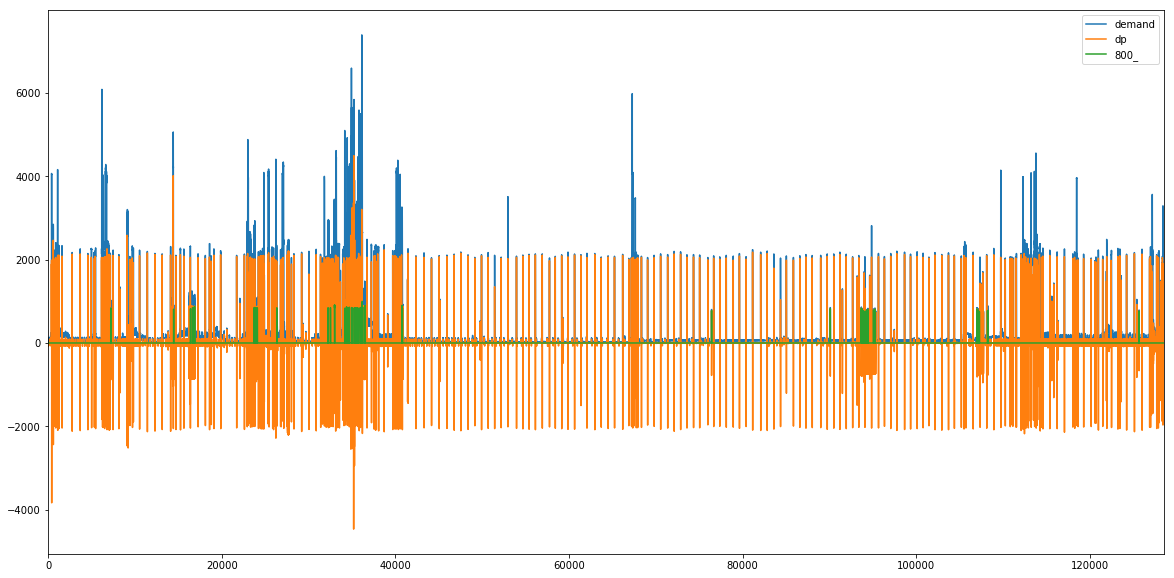

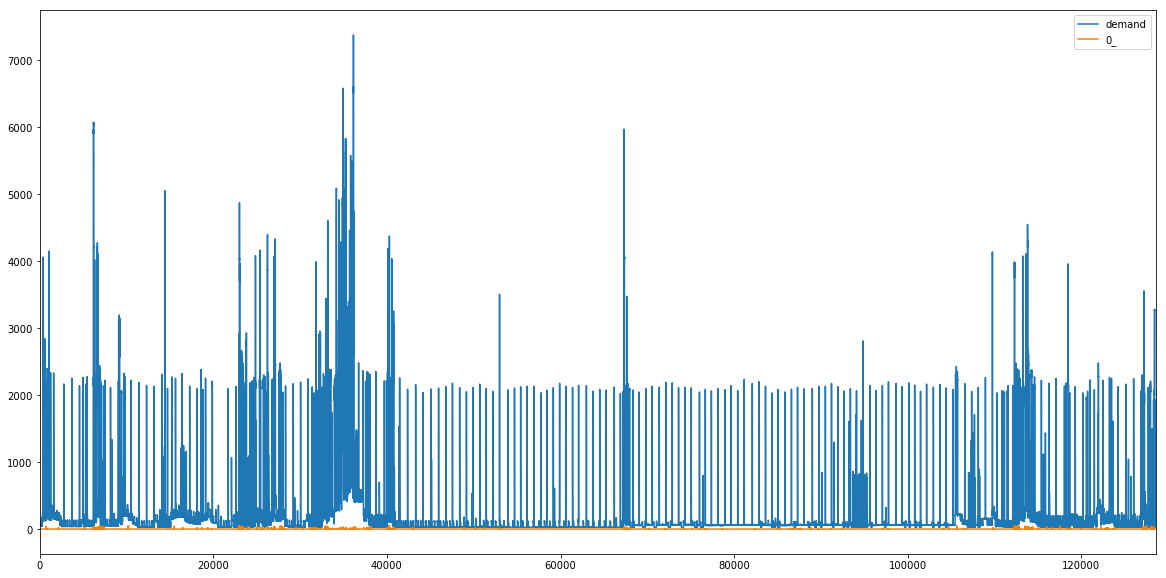

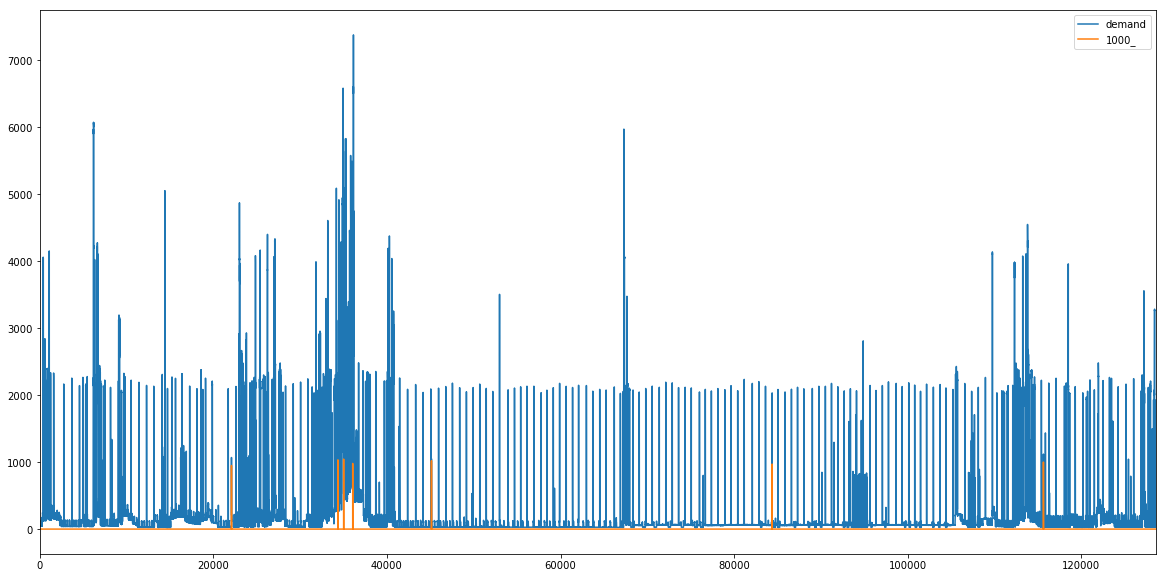

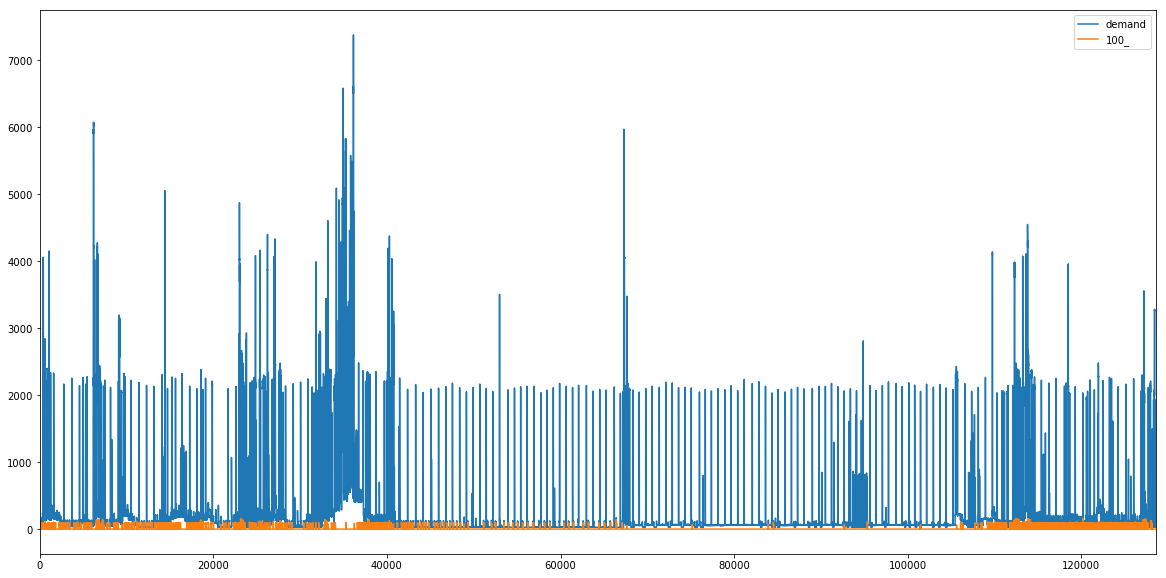

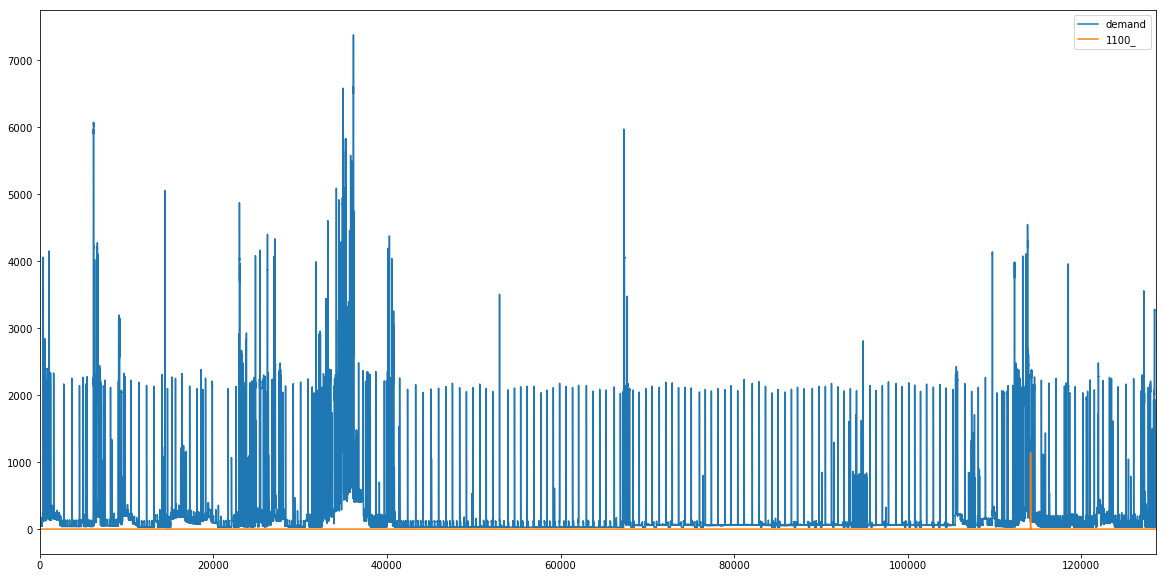

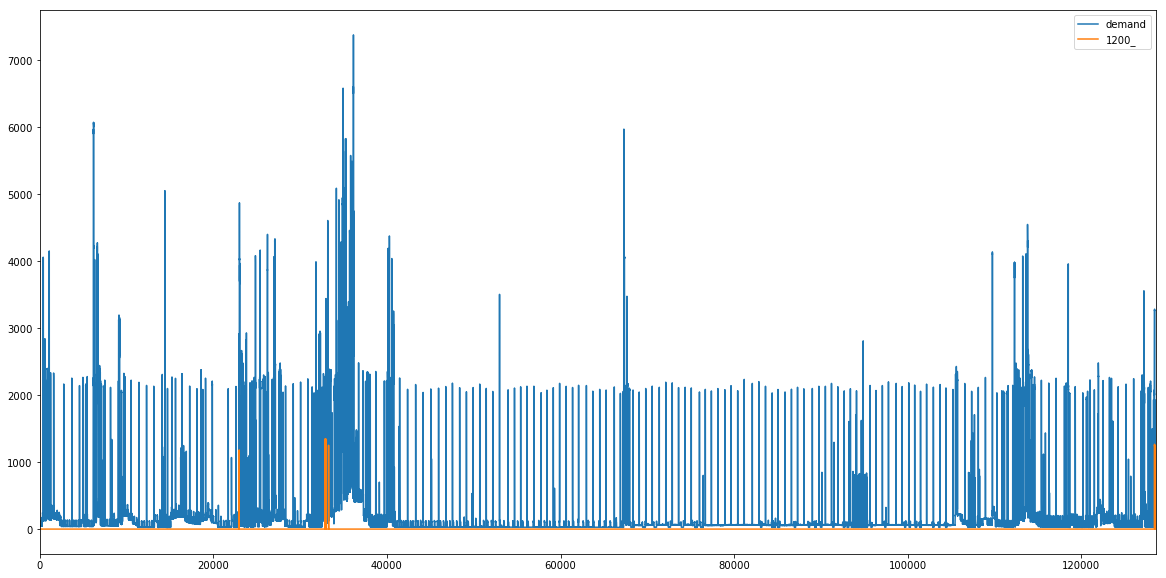

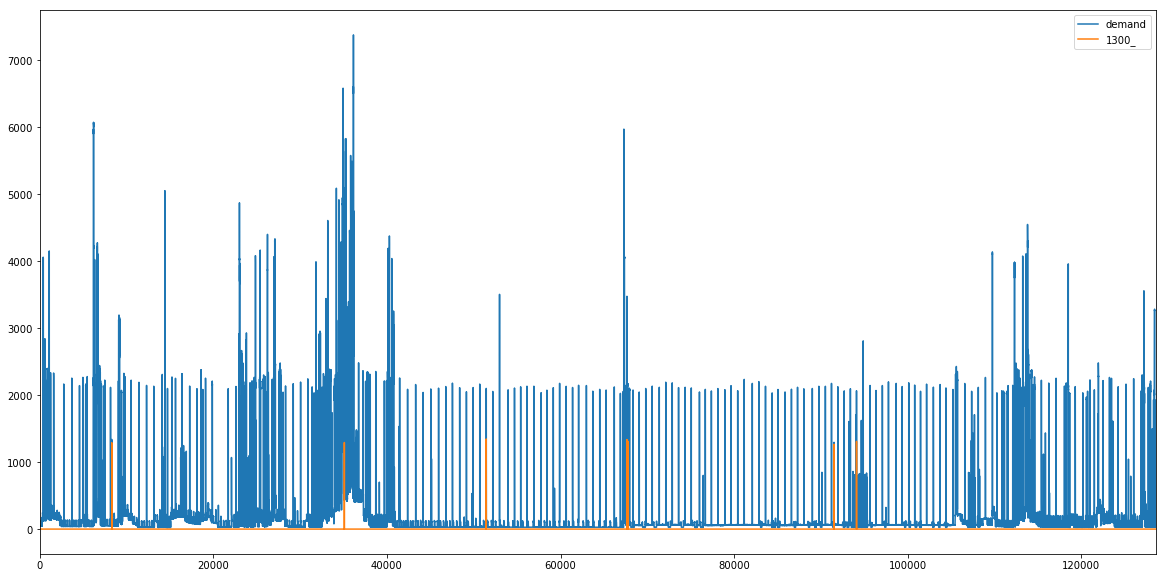

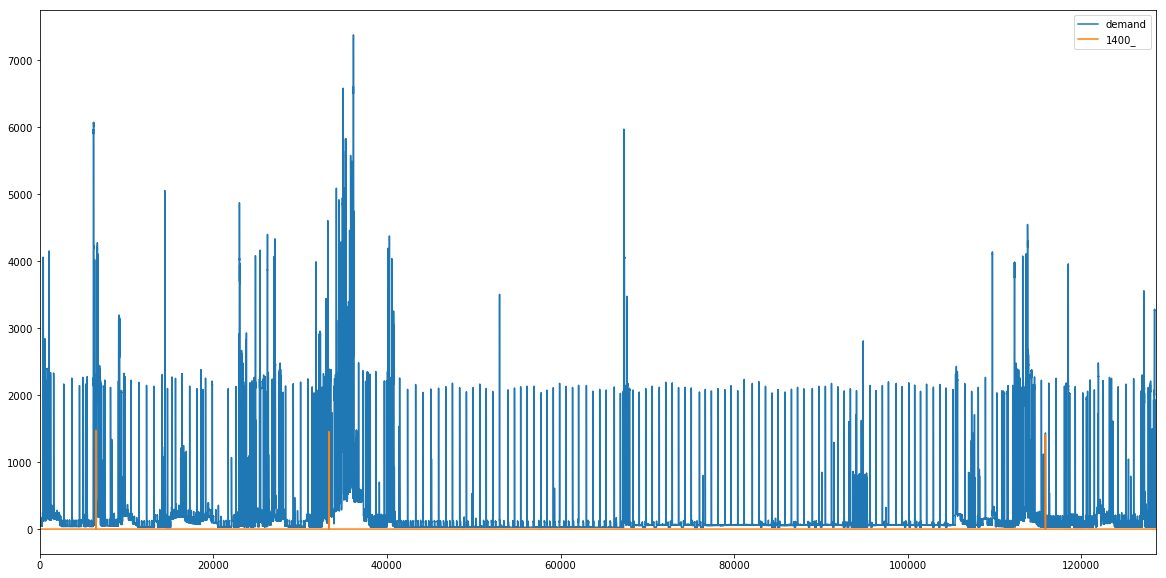

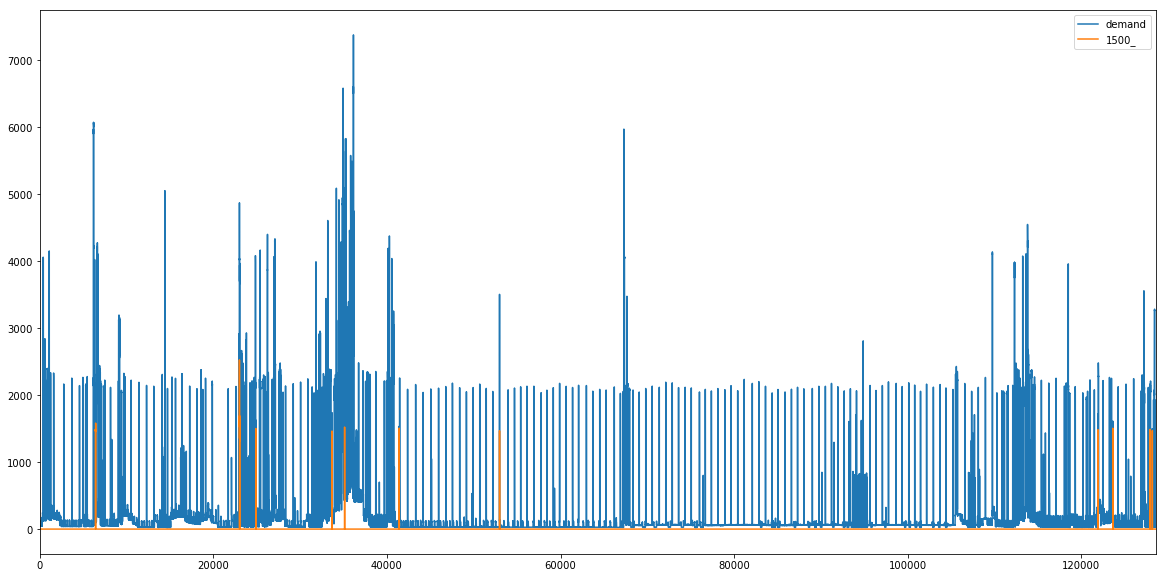

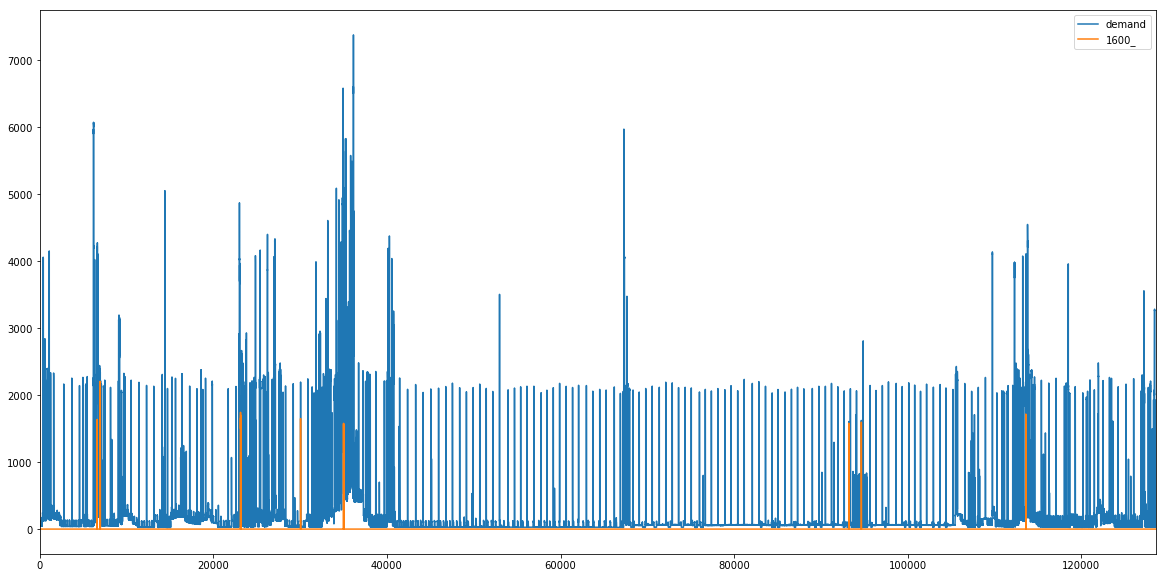

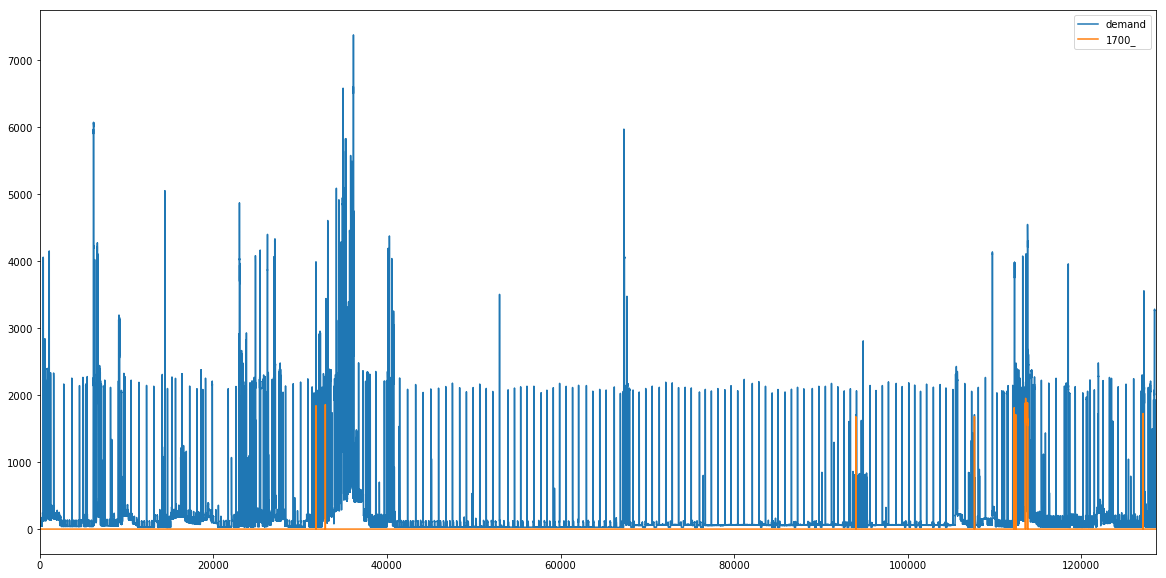

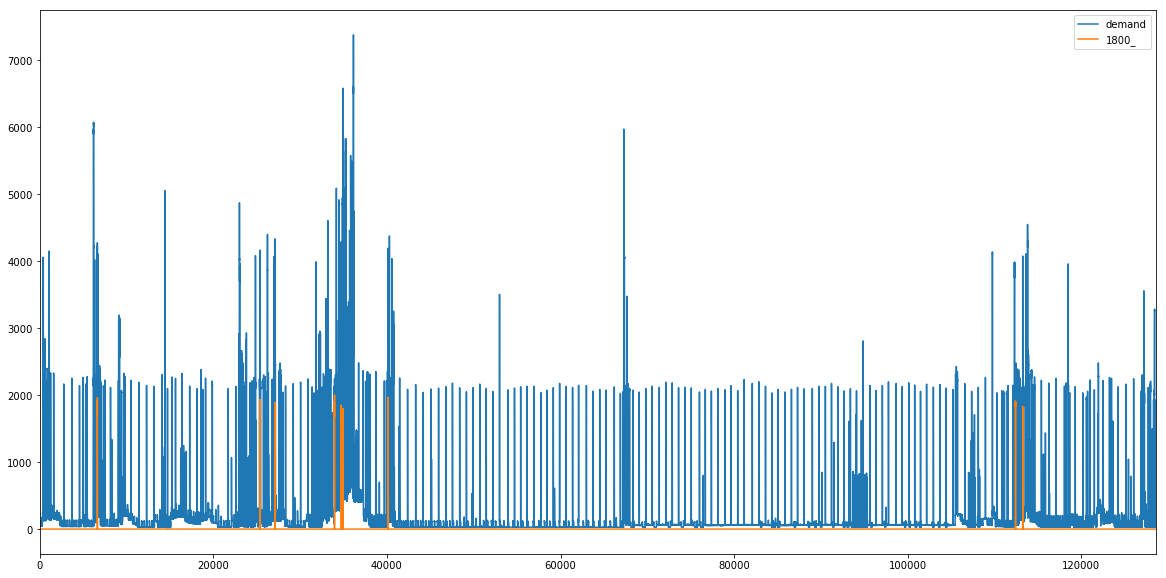

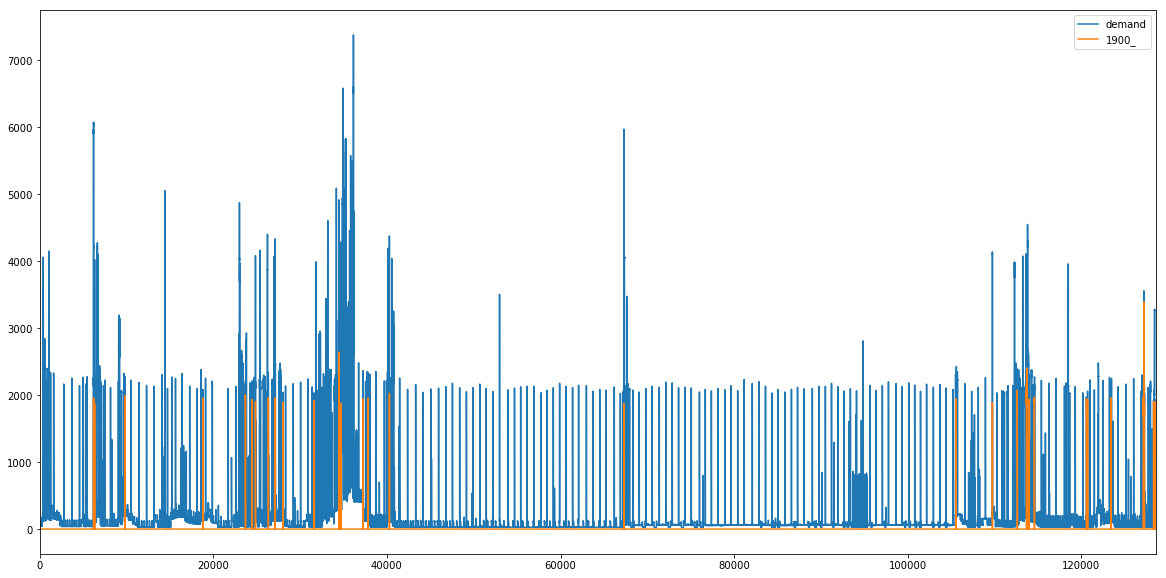

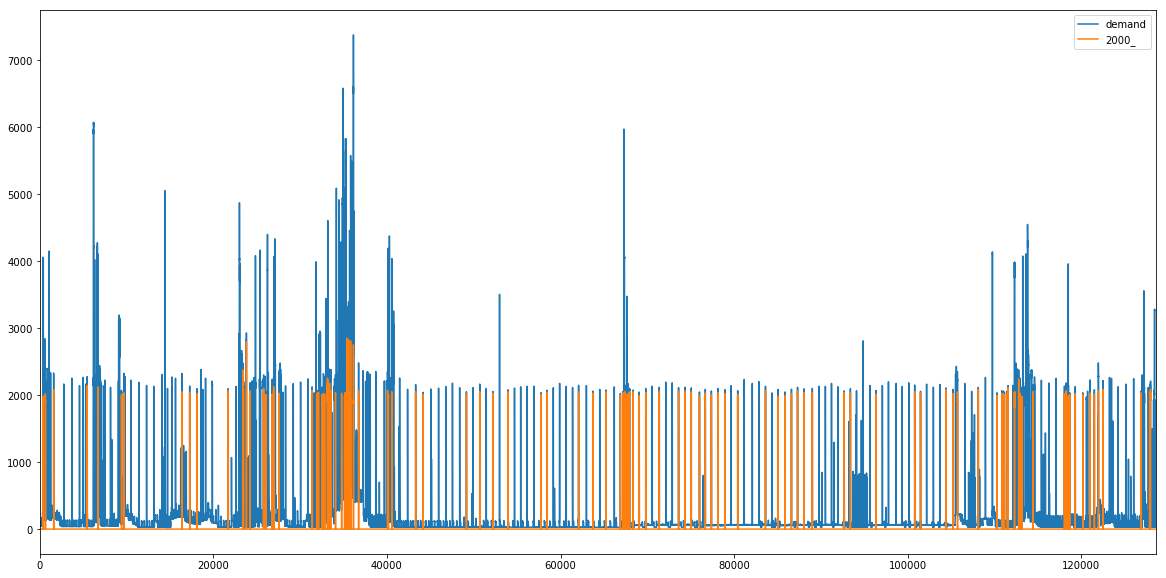

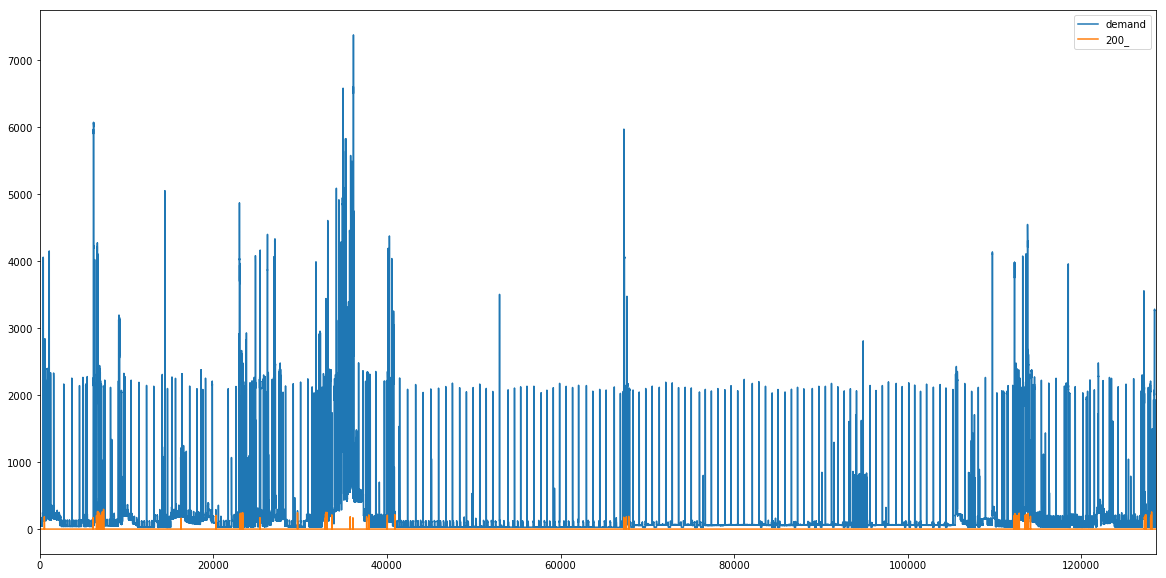

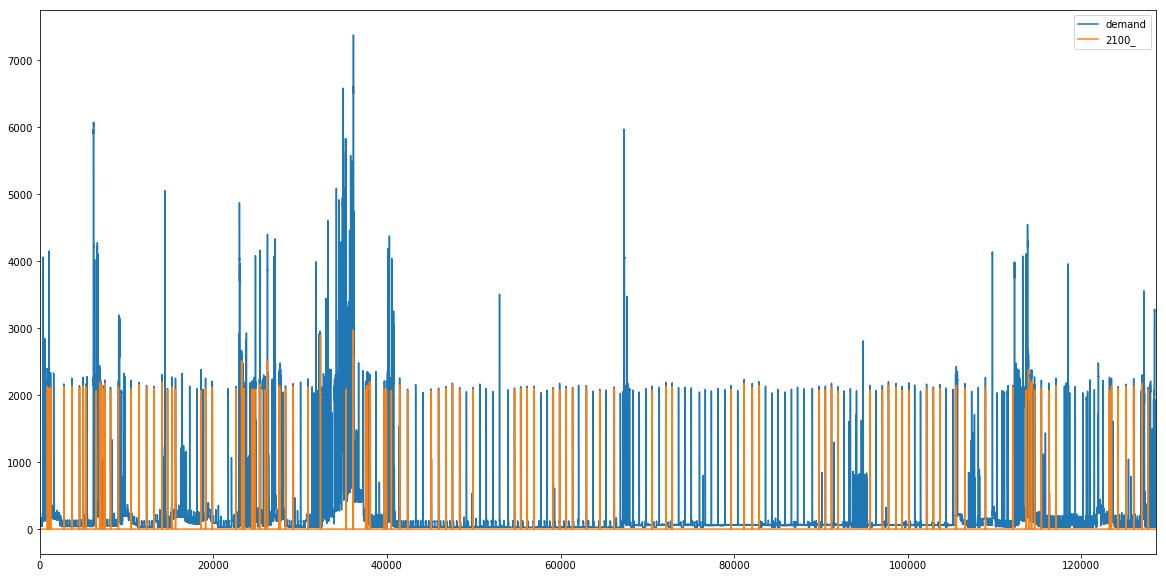

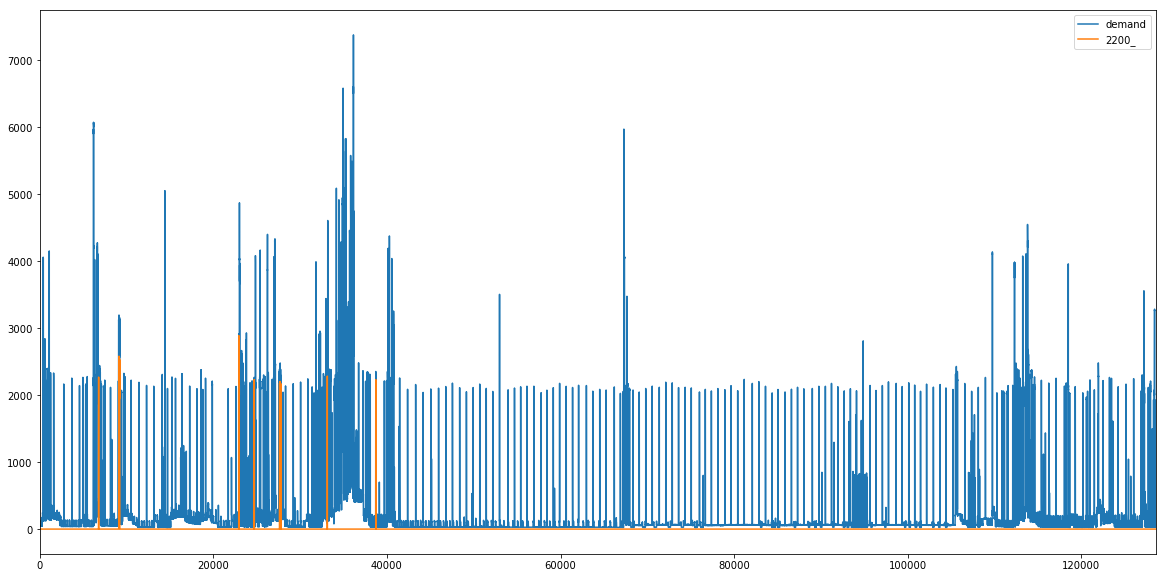

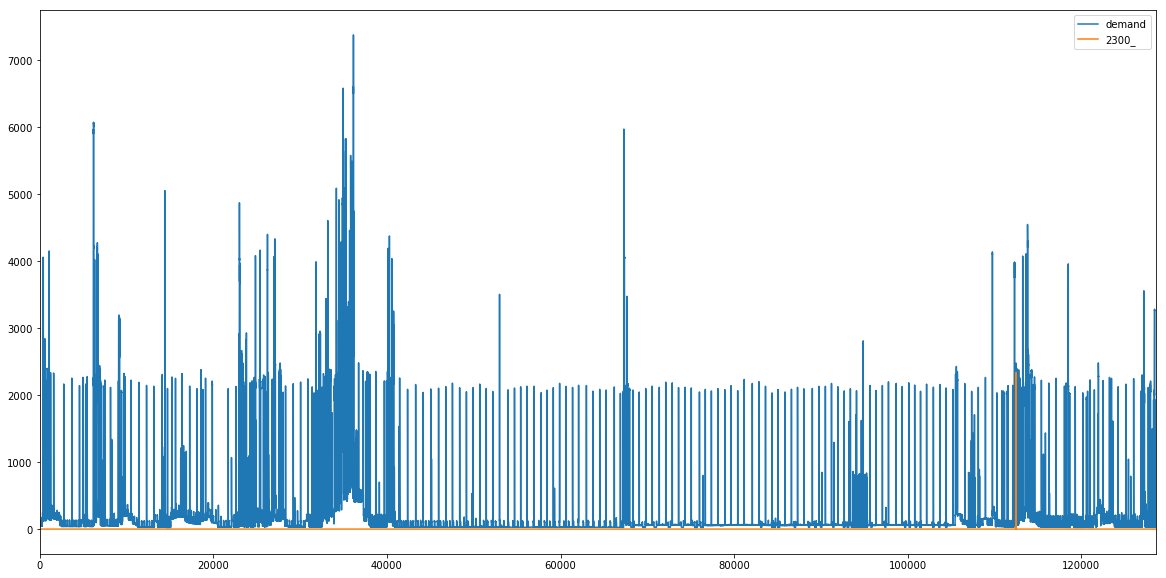

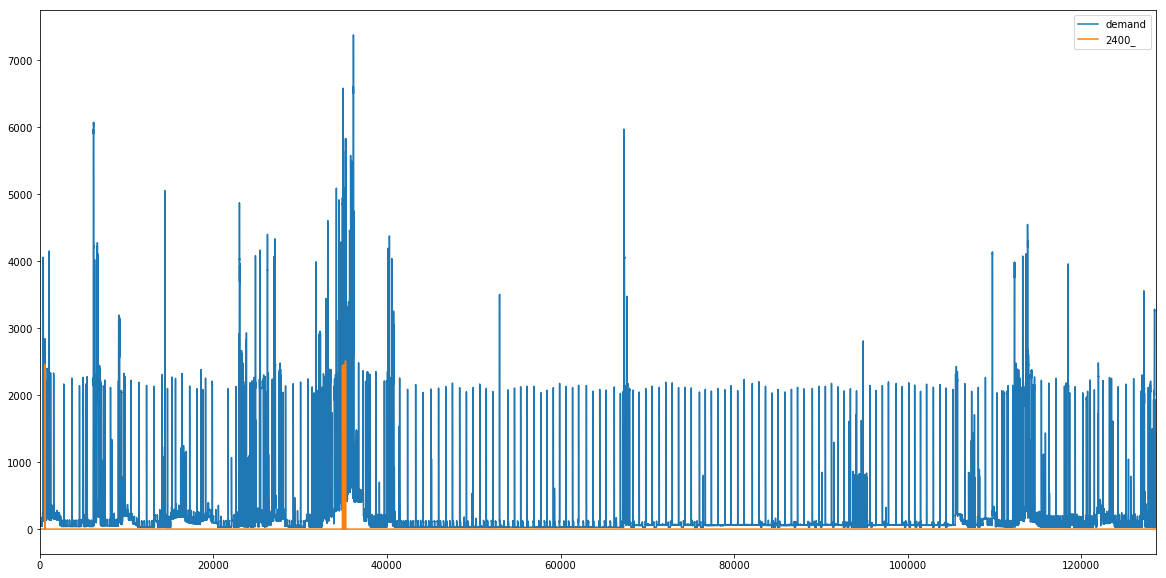

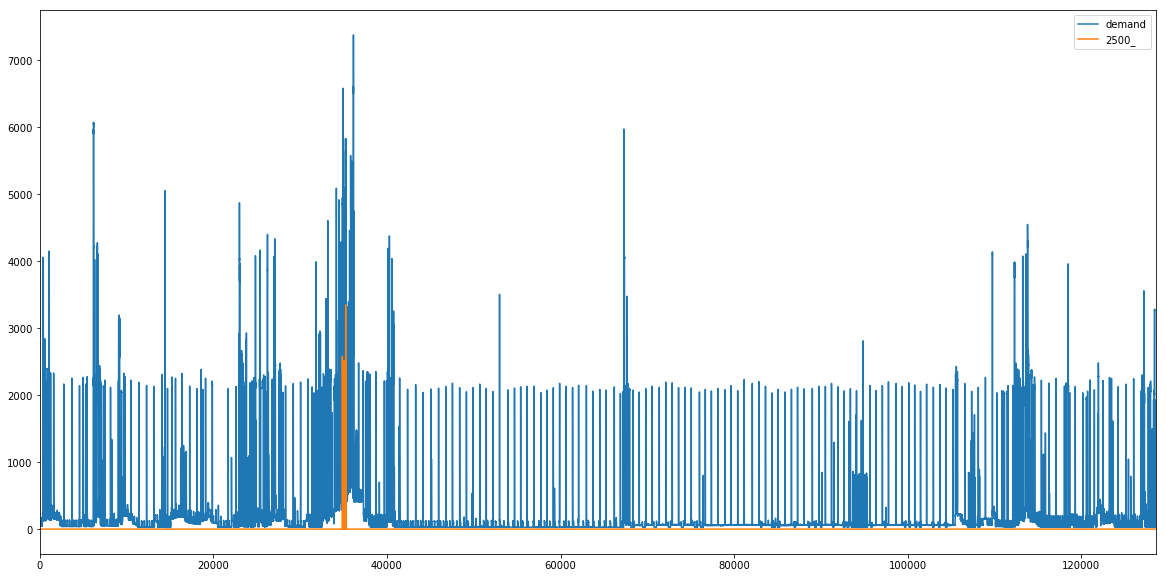

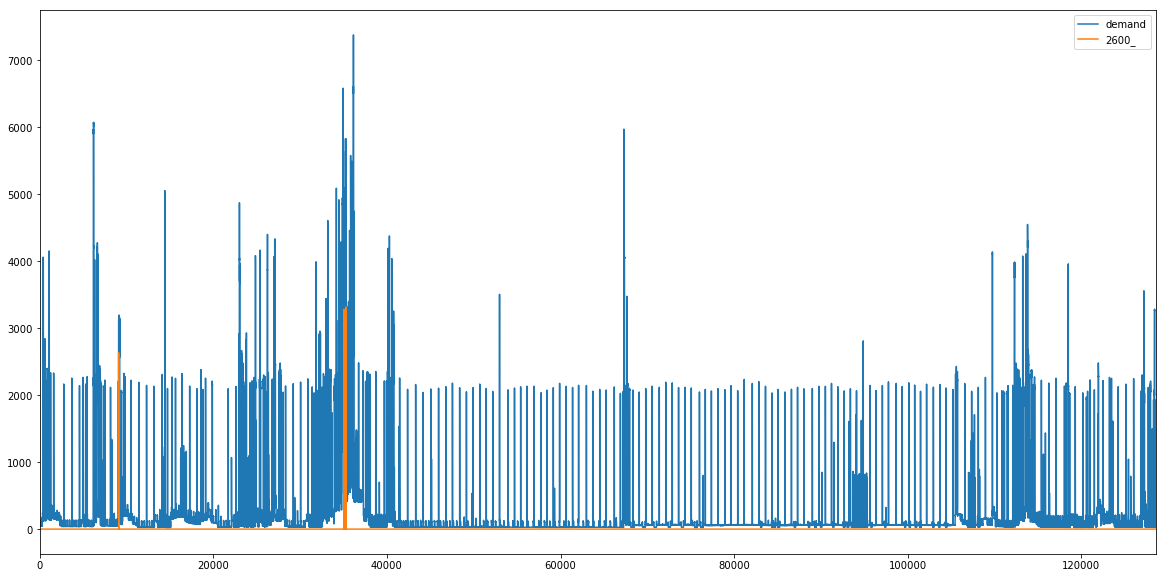

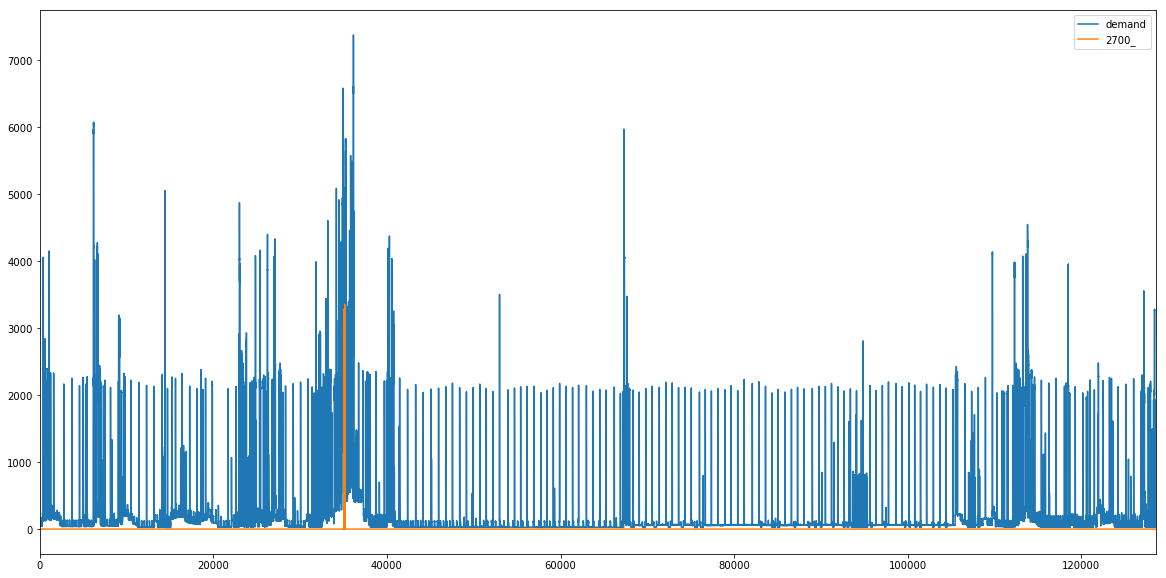

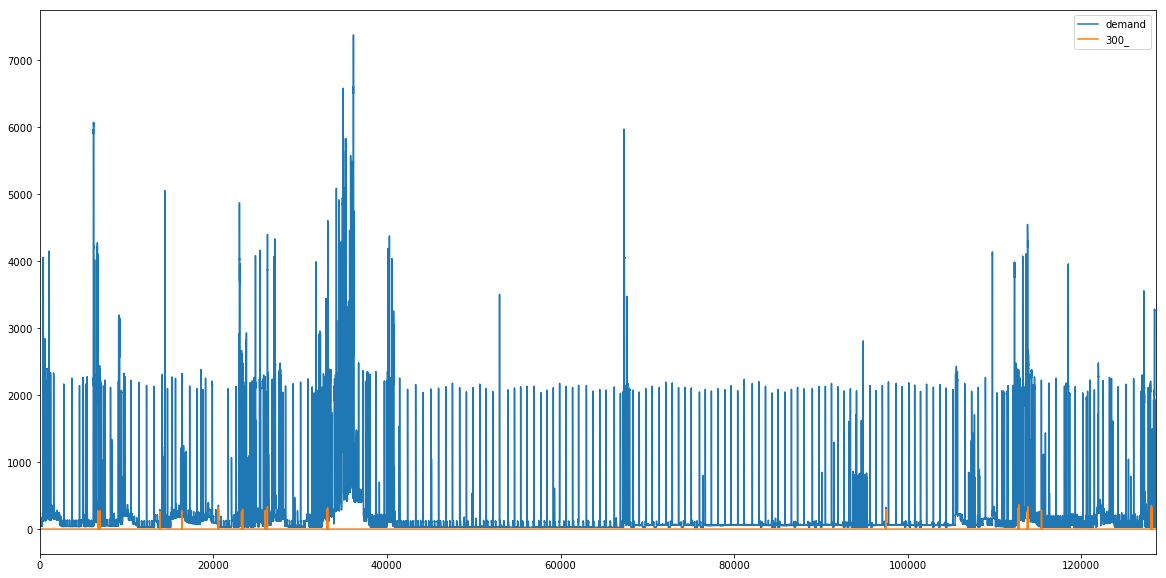

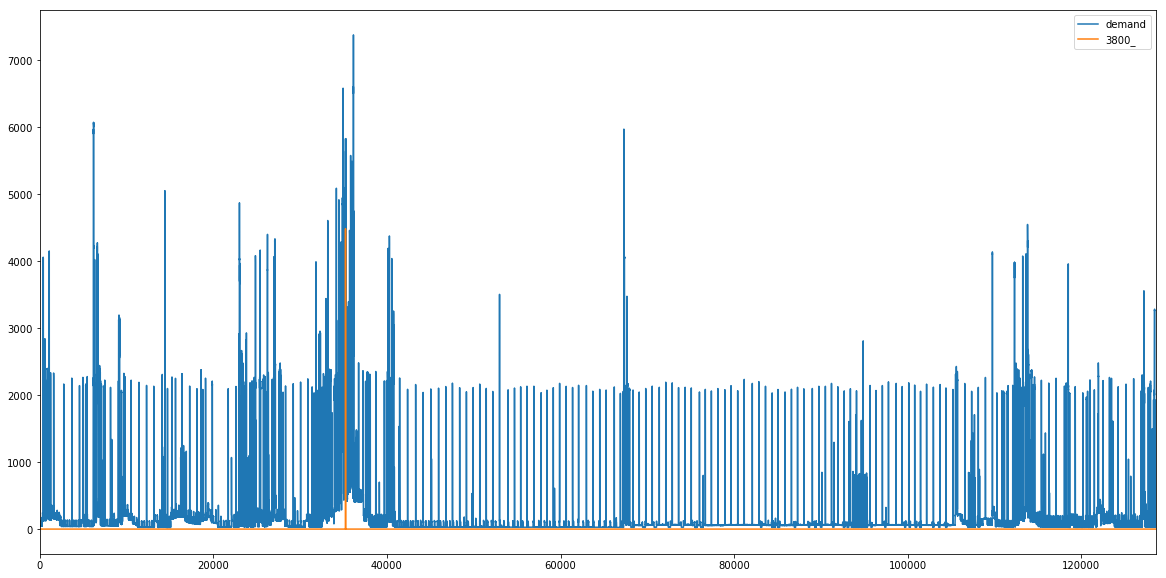

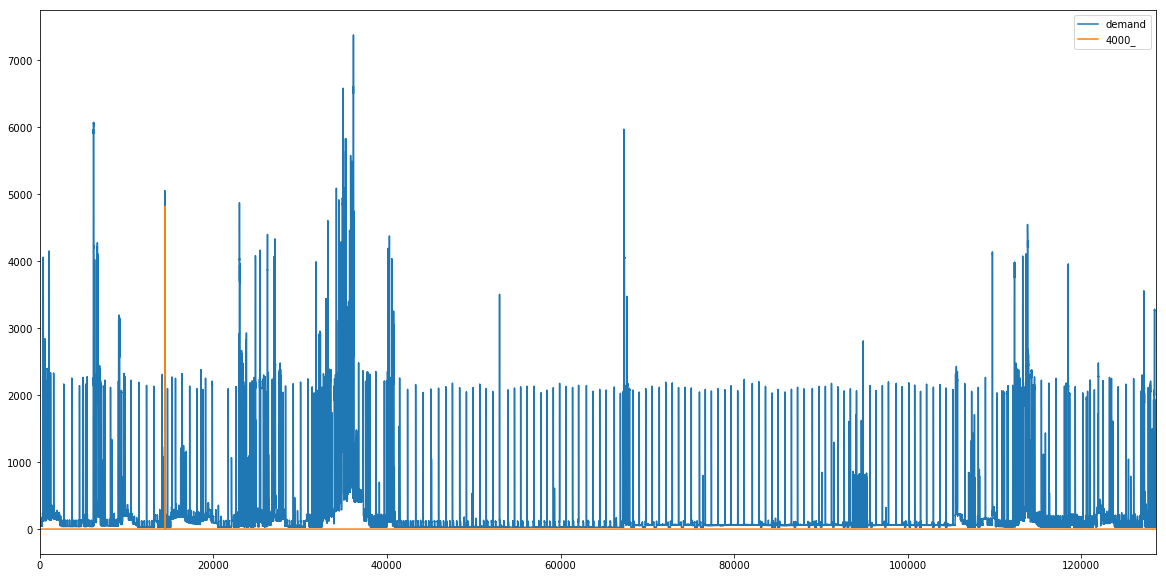

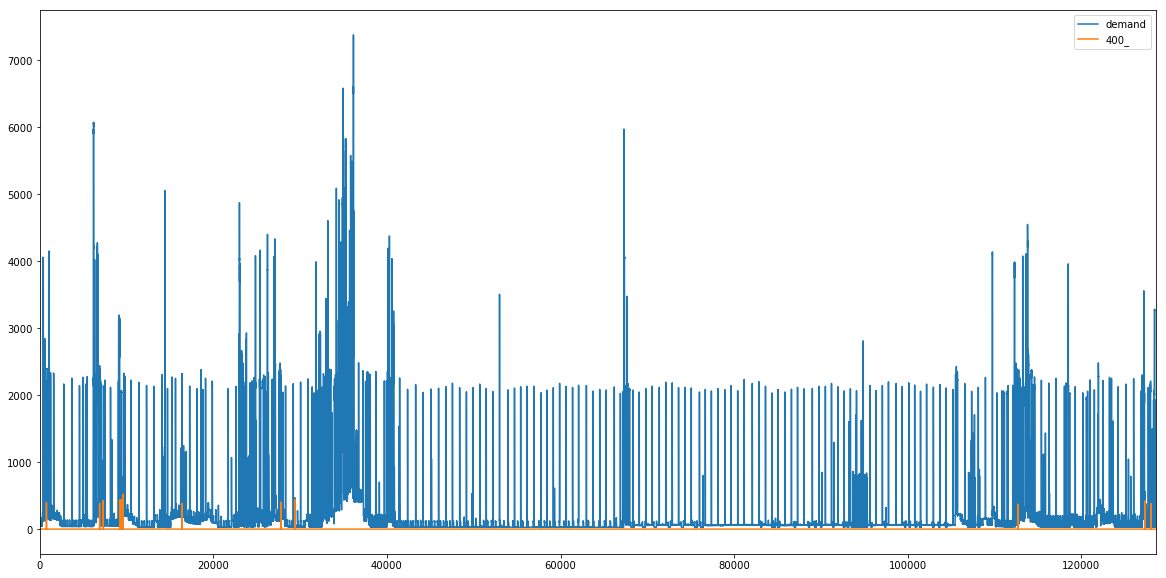

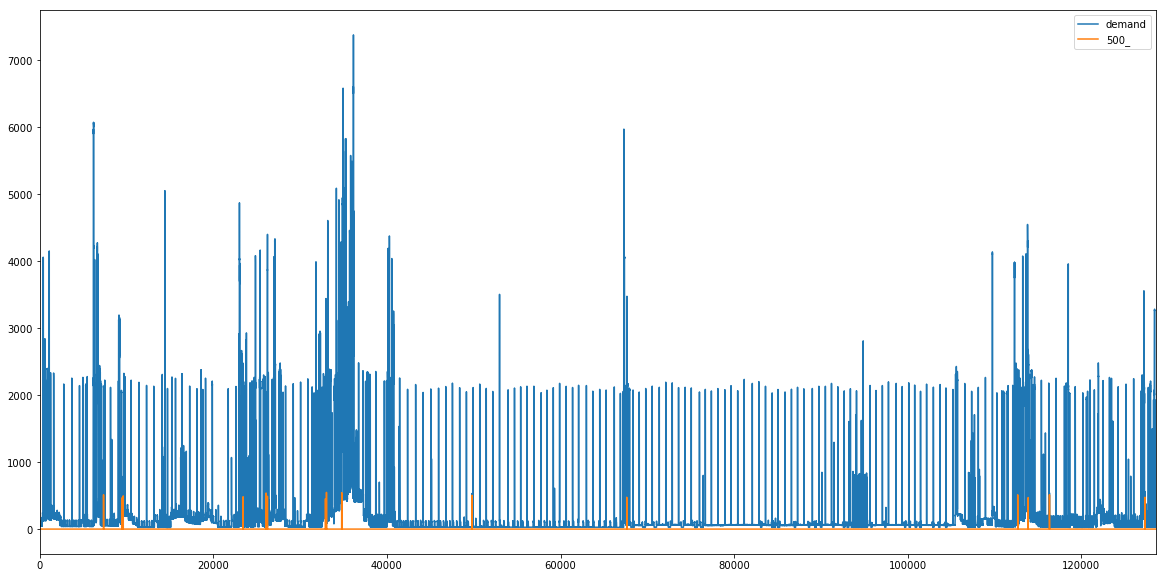

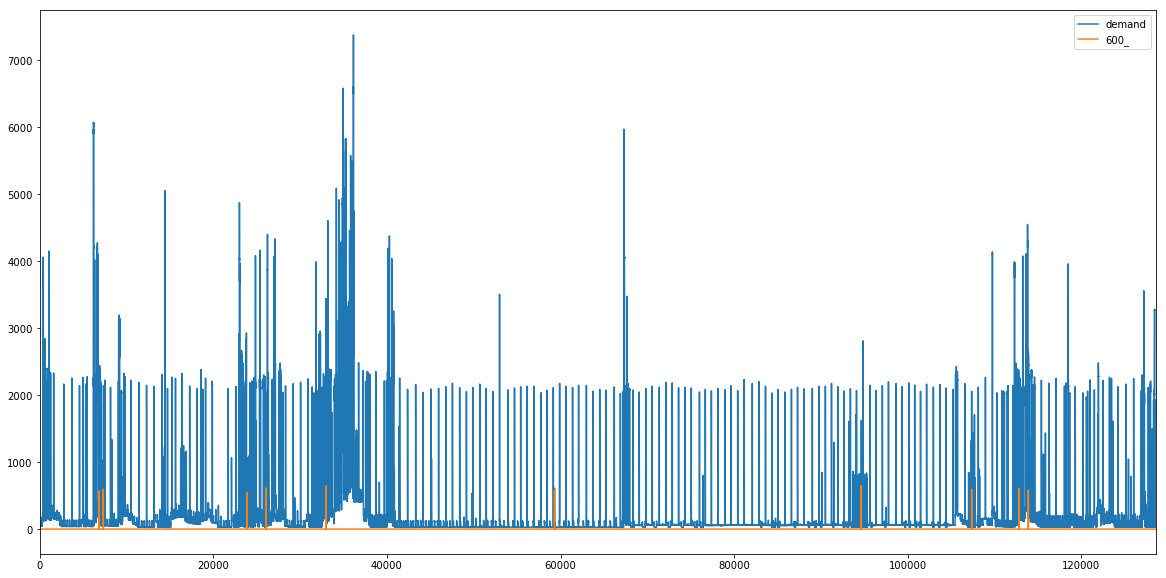

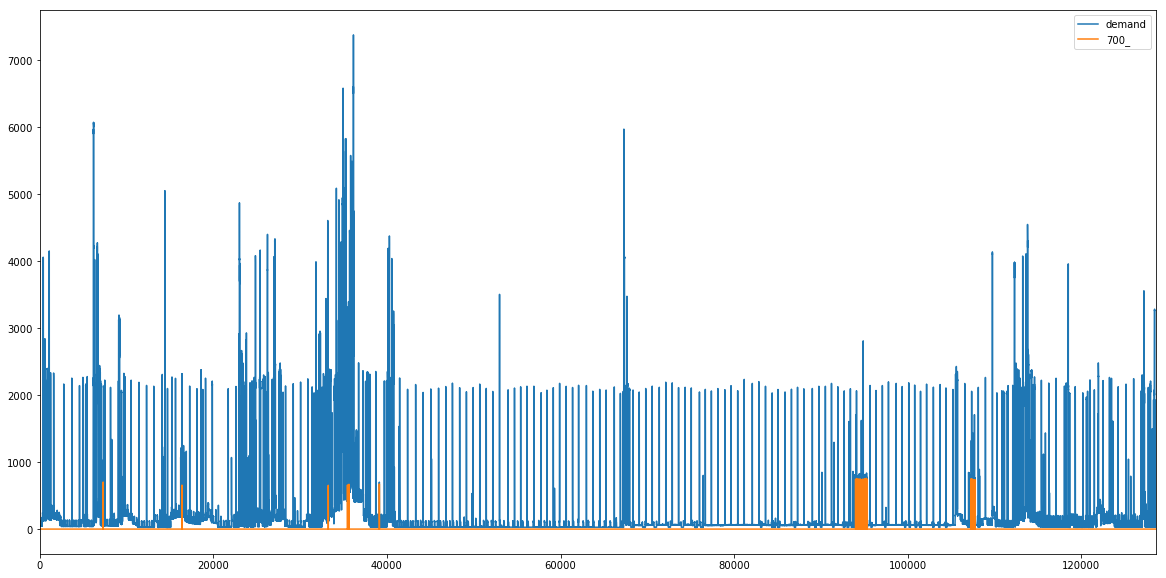

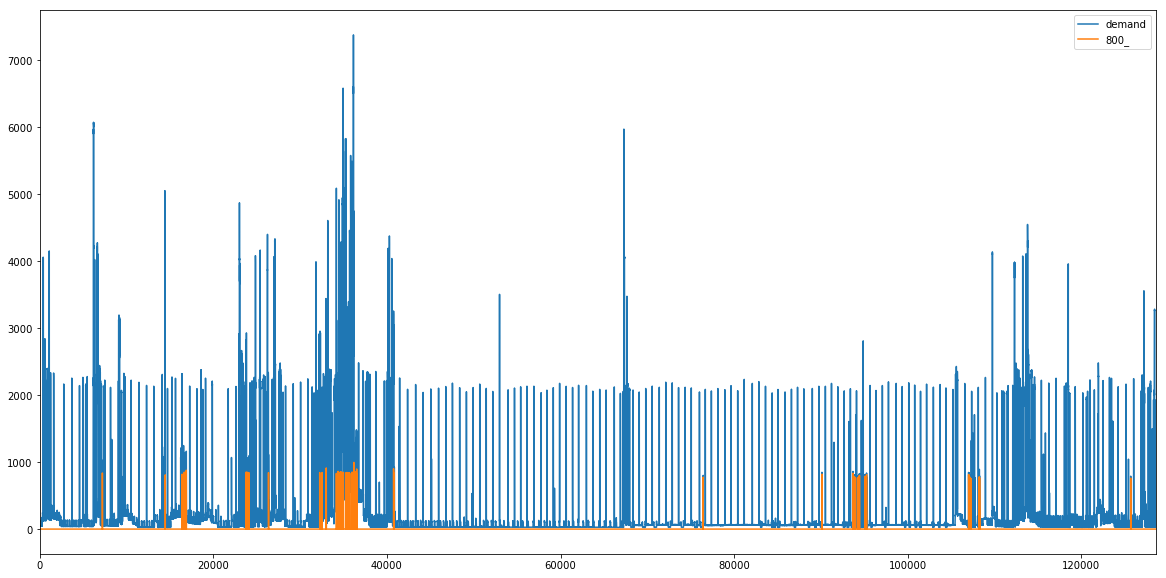

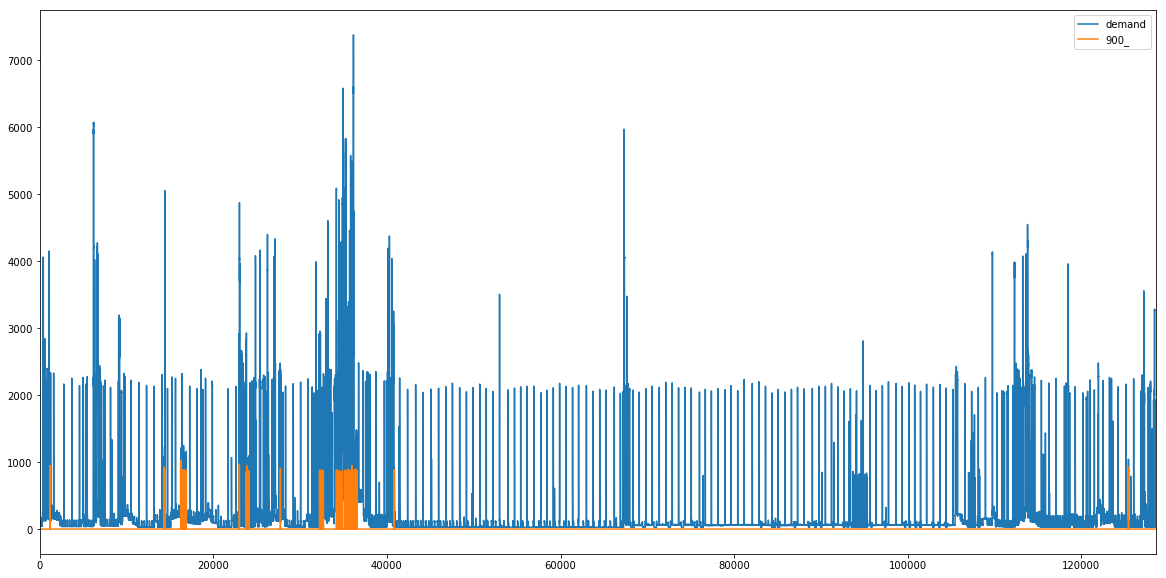

In [9]:
#print(df.loc[7770:7847,['demand','baseload','unknown','800_']])
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

df.loc[:,['demand','dp','800_']].plot(figsize=(20,10))
for i in sorted(loads):
    print(i,'has',len(loads[i]),'occurance(s)')
    df.loc[:,['demand',i]].plot(figsize=(20,10))


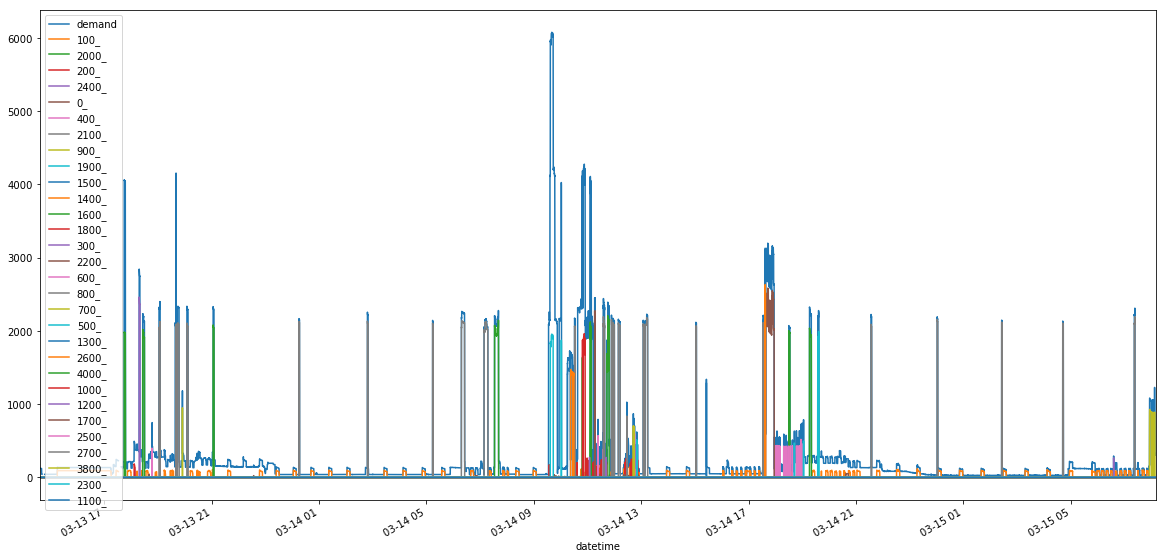

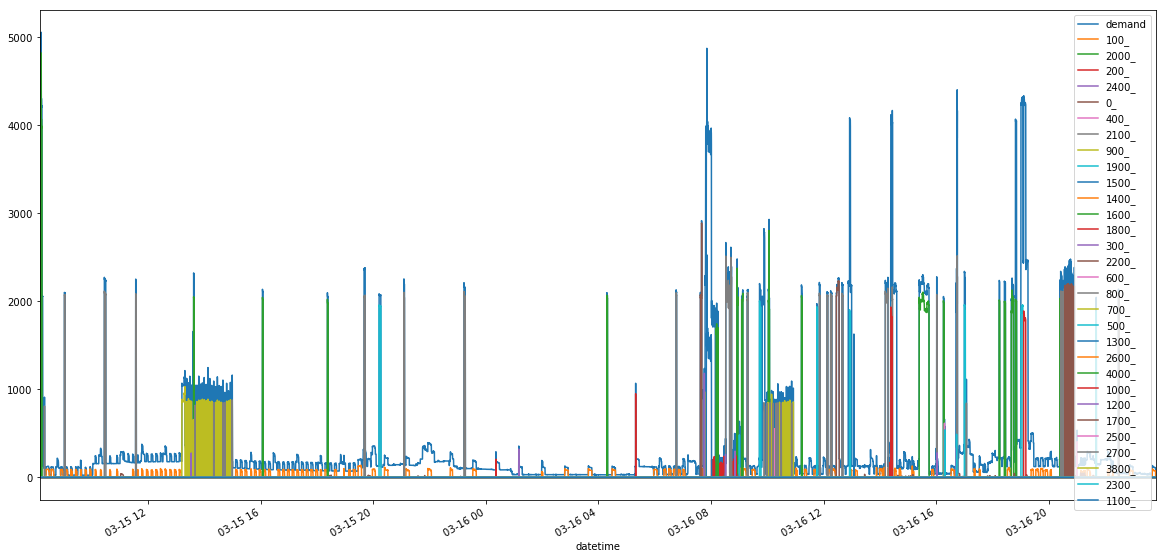

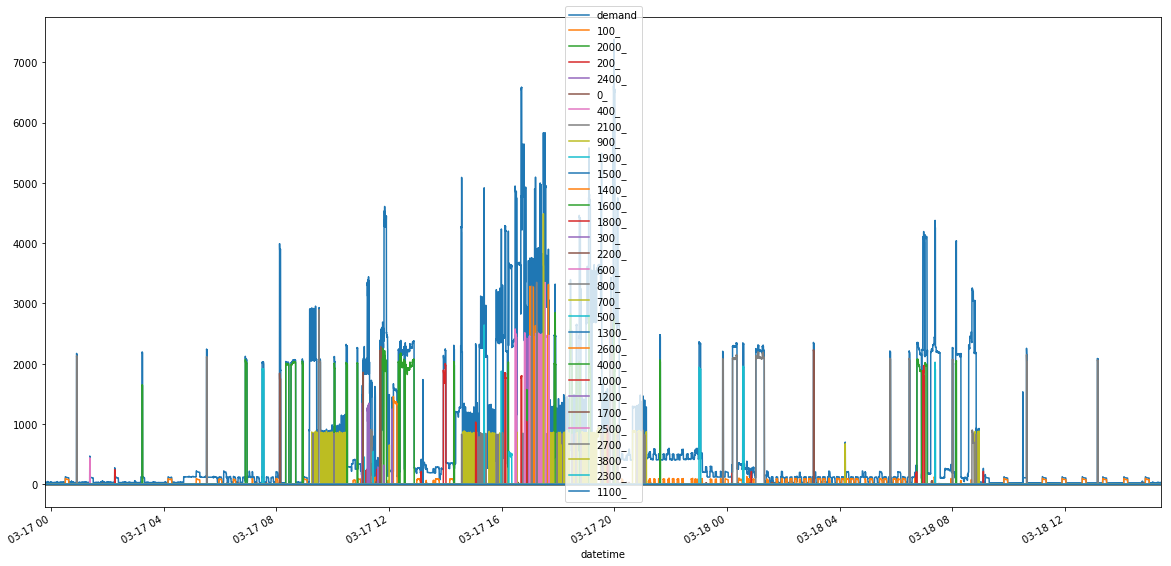

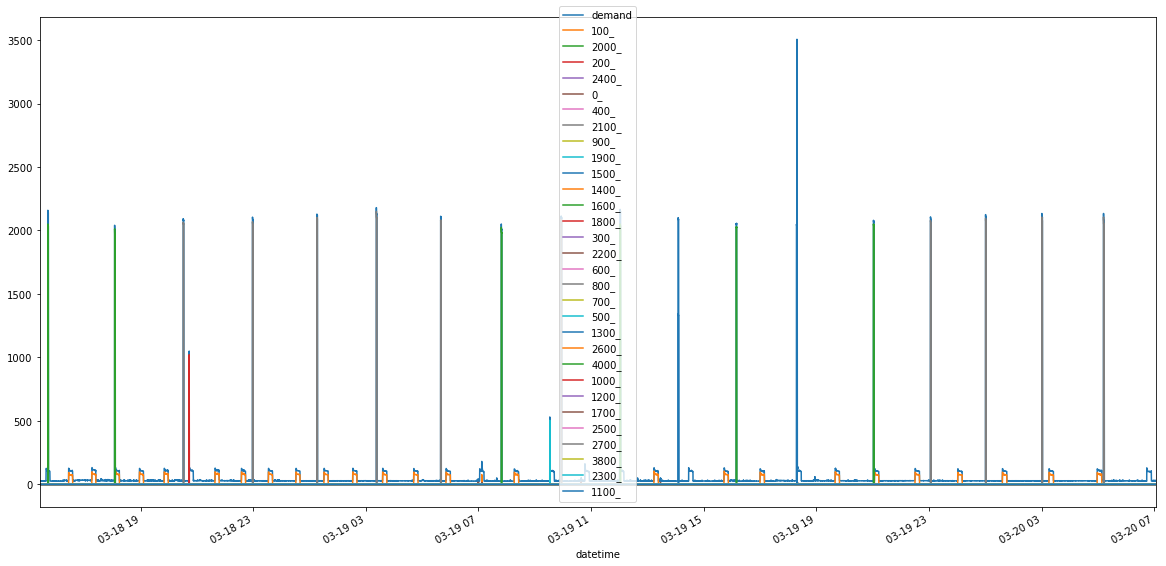

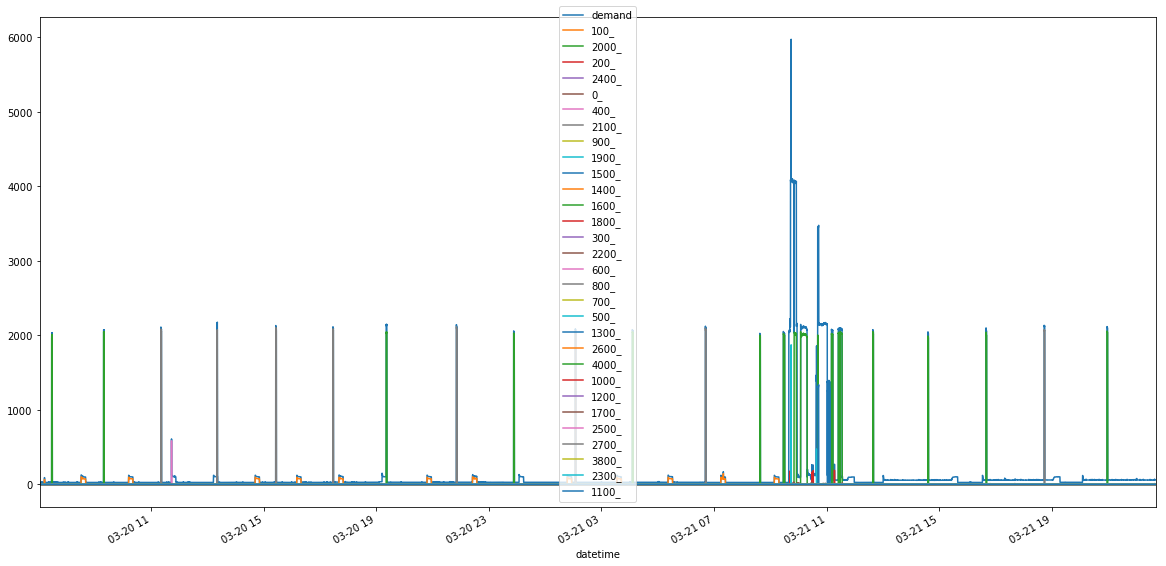

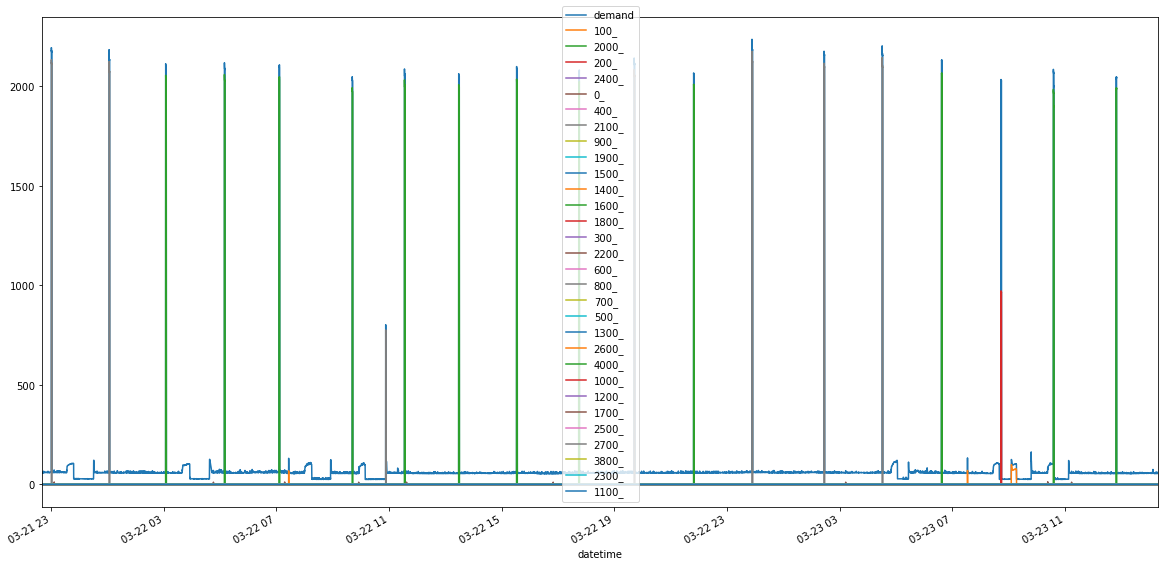

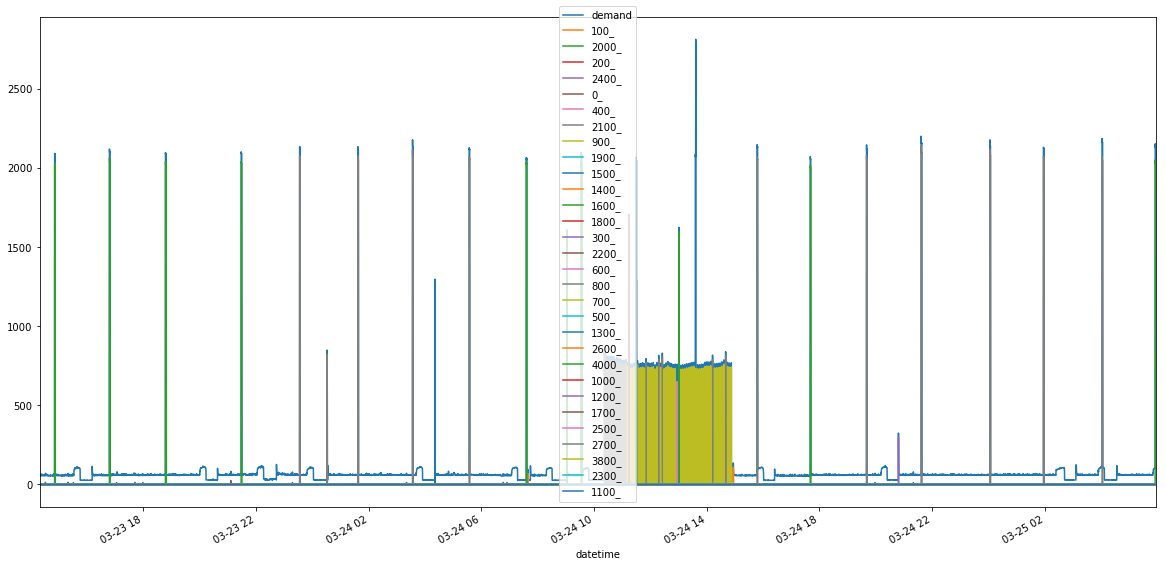

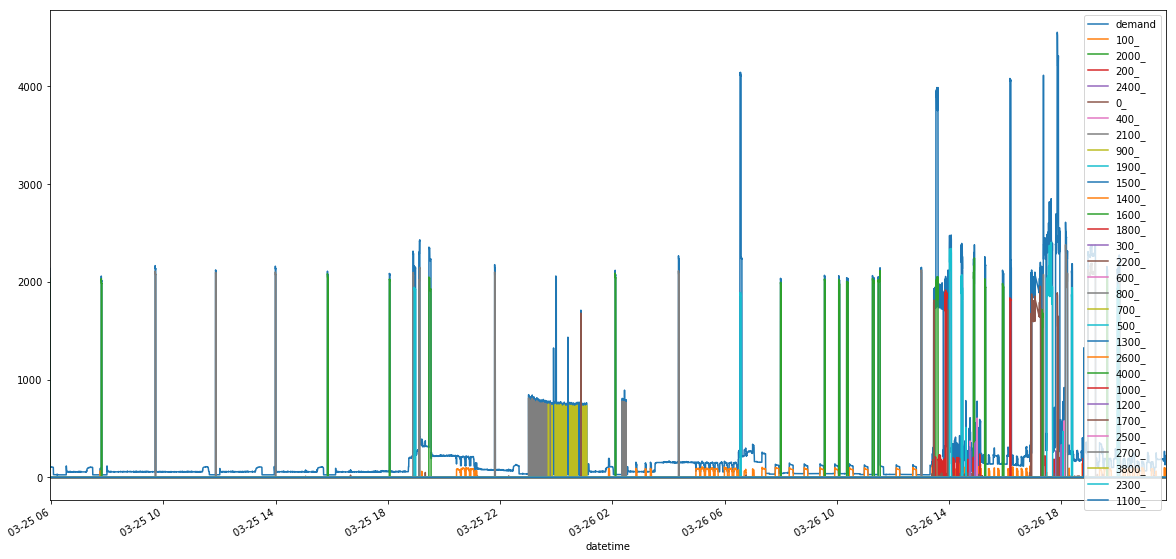

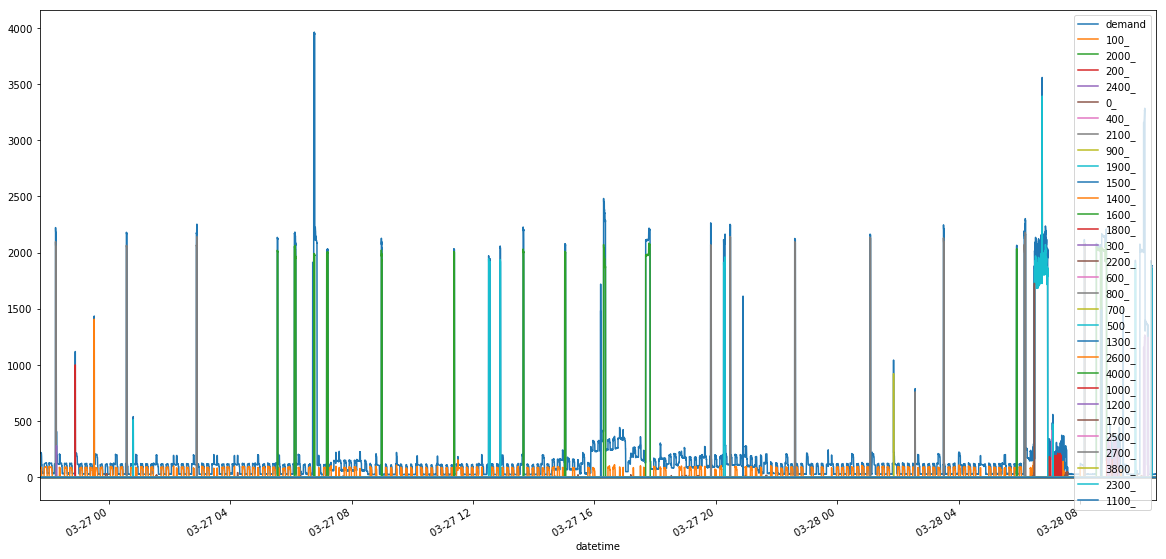

In [10]:
#print(df)
l = list(loads)
l.insert(0, 'datetime')
l.insert(1, 'demand')


step = 600*24 
for i in range(1,len(df),step):
    df.loc[i:i+step,l].plot(x=df.loc[i:i+step,'datetime'],figsize=(20,10))
                            #,kind='area')#,stacked=true)    


In [11]:
print(df.loc[i:i+step,l])

                  datetime  demand  100_  2000_  200_  2400_  0_  400_  2100_  \
115201 2018-03-26 21:43:23   215.0  85.0      0     0      0   0     0      0   
115202 2018-03-26 21:43:33   214.0  84.0      0     0      0   0     0      0   
115203 2018-03-26 21:43:42   215.0  85.0      0     0      0   0     0      0   
115204 2018-03-26 21:43:52   214.0  84.0      0     0      0   0     0      0   
115205 2018-03-26 21:44:02   215.0  85.0      0     0      0   0     0      0   
115206 2018-03-26 21:44:12   215.0  85.0      0     0      0   0     0      0   
115207 2018-03-26 21:44:22   216.0  86.0      0     0      0   0     0      0   
115208 2018-03-26 21:44:32   216.0  86.0      0     0      0   0     0      0   
115209 2018-03-26 21:44:42   217.0  87.0      0     0      0   0     0      0   
115210 2018-03-26 21:44:52   224.0  94.0      0     0      0   0     0      0   
115211 2018-03-26 21:45:02   224.0  94.0      0     0      0   0     0      0   
115212 2018-03-26 21:45:12  

In [12]:
import plotly.offline
import plotly.graph_objs as go
import cufflinks
import plotly.offline as py


# cufflinks.go_offline()

                     date  demand            datetime   dp  dp-  dp+  modem  \
7770  2018-03-14 13:58:17   138.0 2018-03-14 13:58:17 -1.0  1.0  0.0     10   
7771  2018-03-14 13:58:27   137.0 2018-03-14 13:58:27 -1.0  1.0  0.0     10   
7772  2018-03-14 13:58:37   137.0 2018-03-14 13:58:37  0.0  0.0  0.0     10   
7773  2018-03-14 13:58:47   137.0 2018-03-14 13:58:47  0.0  0.0  0.0     10   
7774  2018-03-14 13:58:57   137.0 2018-03-14 13:58:57  0.0  0.0  0.0     10   
7775  2018-03-14 13:59:06   136.0 2018-03-14 13:59:06 -1.0  1.0  0.0     10   
7776  2018-03-14 13:59:16   135.0 2018-03-14 13:59:16 -1.0  1.0  0.0     10   
7777  2018-03-14 13:59:26   136.0 2018-03-14 13:59:26  1.0  0.0  1.0     10   
7778  2018-03-14 13:59:36   135.0 2018-03-14 13:59:36 -1.0  1.0  0.0     10   
7779  2018-03-14 13:59:46   135.0 2018-03-14 13:59:46  0.0  0.0  0.0     10   
7780  2018-03-14 13:59:56   134.0 2018-03-14 13:59:56 -1.0  1.0  0.0     10   
7781  2018-03-14 14:00:06   134.0 2018-03-14 14:00:0

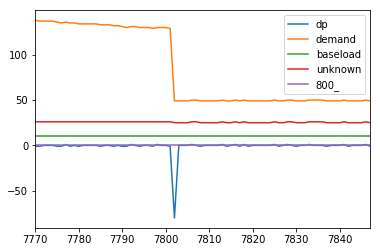

In [13]:
start = 0
points = 1000
try:
    start = plots * points
except:
    plots = 0
# plots = 0

    
res = df.set_index('datetime')
#res[start:start+points].iplot(kind='line')

plots = plots +1
print(df.loc[7770:7847])
plt = df.loc[7770:7847,['dp','demand','baseload','unknown','800_']]
plt.plot()

In [14]:
# print(list(loads['100_'][0]))
for i in sorted(loads):
    print(i,'has',len(loads[i]),'occurance(s)')
    for load in loads[i]:
        if i == '100_':
            print(round(sum(loads[i][load]['profile'])/360,1),'Wh in ',loads[i][load]['time'])
            


0_ has 290 occurance(s)
1000_ has 7 occurance(s)
100_ has 639 occurance(s)
4.3 Wh in  0 days 02:00:18
nan Wh in  0 days 00:11:31
11.7 Wh in  0 days 00:07:54
0.7 Wh in  0 days 00:00:29
2.2 Wh in  0 days 00:01:38
6.5 Wh in  0 days 00:04:36
3.8 Wh in  0 days 00:03:08
2.6 Wh in  0 days 00:01:48
0.1 Wh in  0 days 00:00:10
0.3 Wh in  0 days 00:00:10
4.1 Wh in  0 days 00:02:47
7.3 Wh in  0 days 00:05:26
0.9 Wh in  0 days 00:00:29
4.0 Wh in  0 days 00:03:18
9.9 Wh in  0 days 00:07:05
2.6 Wh in  0 days 00:01:39
9.5 Wh in  0 days 00:06:25
9.6 Wh in  0 days 00:06:35
9.4 Wh in  0 days 00:06:35
9.7 Wh in  0 days 00:06:35
9.7 Wh in  0 days 00:06:35
9.7 Wh in  0 days 00:06:35
9.8 Wh in  0 days 00:06:45
9.8 Wh in  0 days 00:06:45
10.0 Wh in  0 days 00:06:54
9.6 Wh in  0 days 00:06:45
9.9 Wh in  0 days 00:06:54
9.2 Wh in  0 days 00:06:15
5.6 Wh in  0 days 00:04:07
5.3 Wh in  0 days 00:03:58
3.1 Wh in  0 days 00:02:28
10.4 Wh in  0 days 00:07:14
9.4 Wh in  0 days 00:06:35
3.2 Wh in  0 days 00:01:29
0.3 

6.3 Wh in  0 days 00:04:27
6.5 Wh in  0 days 00:04:38
4.4 Wh in  0 days 00:03:08
6.6 Wh in  0 days 00:04:38
5.8 Wh in  0 days 00:04:18
3.2 Wh in  0 days 00:02:19
6.4 Wh in  0 days 00:04:27
6.3 Wh in  0 days 00:04:28
6.5 Wh in  0 days 00:04:27
6.6 Wh in  0 days 00:04:38
6.6 Wh in  0 days 00:04:37
0.9 Wh in  0 days 00:00:30
1.6 Wh in  0 days 00:01:09
6.6 Wh in  0 days 00:04:37
6.1 Wh in  0 days 00:04:28
1.3 Wh in  0 days 00:00:59
6.6 Wh in  0 days 00:04:37
6.1 Wh in  0 days 00:04:27
1.2 Wh in  0 days 00:01:00
0.7 Wh in  0 days 00:00:29
6.5 Wh in  0 days 00:04:38
6.3 Wh in  0 days 00:04:27
1.2 Wh in  0 days 00:00:40
6.7 Wh in  0 days 00:04:37
6.5 Wh in  0 days 00:04:28
6.0 Wh in  0 days 00:04:27
2.3 Wh in  0 days 00:01:39
6.6 Wh in  0 days 00:04:37
6.4 Wh in  0 days 00:04:27
6.2 Wh in  0 days 00:04:27
3.9 Wh in  0 days 00:02:49
5.9 Wh in  0 days 00:04:37
6.6 Wh in  0 days 00:04:38
3.7 Wh in  0 days 00:02:38
5.6 Wh in  0 days 00:03:57
0.2 Wh in  0 days 00:00:10
5.7 Wh in  0 days 00:03:58
6

In [15]:

res = df.set_index('datetime')
# res[:1000].iplot(kind='line')
# fig = res.plot()
# fig.show()
res.resample('10T').iplot(kind='line')



# res[:100]

/Applications/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning:


.resample() is now a deferred operation
You called iplot(...) on this deferred object which materialized it into a dataframe
by implicitly taking the mean.  Use .resample(...).mean() instead



PlotlyRequestError: Uh oh, an error occurred on the server. 

In [ ]:

# df[['datetime',list(loads)]].iplot()
temp = list(loads)
temp[0] = 'datetime'
temp[1] = 'baseload'
temp[2] = 'unknown'

temp[3:] =list(loads)
dp = df[temp]
dp = dp.set_index('datetime')
# dp.resample('10T').mean().iplot(kind='area',fill='tozeroy',mode='none')



In [ ]:
pie = dp.sum()
# values = pie.values/pie.sum()*100
round(pie/pie.sum()*100,1)
pie.plot(kind='pie',figsize=(10,10))

In [ ]:
print(pie)
print(pie/pie.sum())

In [ ]:
trace = go.Pie(labels=pie.index, values=pie.values)
dp.iplot([trace], filename=name)

In [ ]:
# import plotly.plotly as py
import plotly.offline as py

trace = go.Pie(labels=pie.index, values=pie.values)

py.plot([trace], filename='disaggregator_results_pie.html')

# Try to rename colums for 'kwown loads' 

In [ ]:
#relable output for known_loads
known_loads = {'100_':'Fridge','2000_':'Iron'}
for name in loads.keys():
    try:
        df=df.rename(columns = {name:known_loads[name]})
        loads[known_loads[name]] = loads[name]
    except:
        print(name,'not found known_loads')
    
for name in known_loads:
    try:
        del loads[name]
    except:
        print(name,'not found in legend')

legend = loads.keys()
print(list(legend))